# 🏠 Buildings of Iceland

---

### Overview
This notebook focuses on extracting **all buildings** from a municipality using **Mosfellsbær, Iceland**, as an example. The workflow involves:
- Retrieving building geometries from **OpenStreetMap** using the `osmnx` Python package.
- Filtering to include only polygon geometries (buildings with an area).
- Cropping individual buildings from **satellite imagery**.
- Visualizing the results as a collection of building images.

Additionally, the notebook generates **statistics** about the buildings and provides visual tools to explore the data.

---

### How to Use
Try this notebook to explore buildings in any municipality or region worldwide. All you need is the name of the location!

Run the code via free cloud platforms: [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-lmi/m-lmi.github.io/blob/master/BuildingsOfIceland/BuildingsOfIceland.ipynb)

---

### Highlights from the Analysis
- **Mosfellsbær, Iceland**, served as an example for extracting buildings.
- The notebook processes each building polygon, crops it from **satellite imagery**, and generates individual images.
- Provides a flexible template to extract buildings in other regions by simply changing the location name.

---

### Attribution
- **License**: This notebook is published under **CC BY 4.0**.
- **Author**: Marco Pizzolato
- **Tools Used**: Python, `osmnx`, and satellite imagery from Google
- **Data Sources**: [OpenStreetMap](https://www.openstreetmap.org/), Google Satellite Imagery
- **Created in**: Python with `matplotlib`, `osmnx`, and other libraries

---

**Explore the buildings of Mosfellsbær—or any other region—with this detailed, hands-on analysis.**

![Day 24 - Buildings](building.png)


# Import

In [1]:
# Install
%pip install segment-geospatial leafmap localtileserver rasterio osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.7/502.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.8 MB/

In [1]:
# Import
import os
import leafmap
from samgeo.hq_sam import (
    SamGeo,
    show_image,
    download_file,
    overlay_images,
    tms_to_geotiff,
)
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import osmnx as ox

## Interactive map to see how roundabout look like

In [2]:
# Prepare map (Leafmap in this case)
m = leafmap.Map(center=[64.1672, -21.6854], zoom=13, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[64.1672, -21.6854], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

# Shapes

In [5]:
import osmnx as ox

# Define the location for Mosfellsbær, Iceland
place_name = "Mosfellsbær, Iceland"

# Define custom filters to extract buildings
# 'building' is the key for buildings in OSM data
tags = {"building": True}

# Get buildings in Mosfellsbær
buildings_gdf = ox.geometries_from_place(place_name, tags=tags)

# Display the GeoDataFrame
buildings_gdf.head()

<ipython-input-5-e1bd0f5c098e>:11: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings_gdf = ox.geometries_from_place(place_name, tags=tags)


geometry  \
element_type osmid                                                         
way          42672516  POLYGON ((-21.74176 64.16547, -21.74154 64.165...   
             55759202  POLYGON ((-21.69786 64.16671, -21.69731 64.166...   
             56434545  POLYGON ((-21.69472 64.16581, -21.69478 64.165...   
             59616344  POLYGON ((-21.69028 64.16803, -21.69087 64.168...   
             59699823  POLYGON ((-21.69419 64.16660, -21.69438 64.166...   

                      amenity  \
element_type osmid              
way          42672516     NaN   
             55759202     NaN   
             56434545     NaN   
             59616344     NaN   
             59699823     NaN   

                                                                   nodes  \
element_type osmid                                                         
way          42672516  [533621134, 533621135, 533621136, 533621137, 5...   
             55759202  [700422718, 700422719, 700422717, 700422720, 7...   
             56434545  [707249590, 707249592, 2104338435, 2104338433,...   
             59616344  [739499684, 739499676, 739499682, 739499668, 7...   
             59699823  [740785212, 740785209, 740785214, 740785211, 7...   

                      addr:housenumber addr:postcode  addr:street building  \
element_type osmid                                                           
way          42672516                3           270  Hlíðavöllur      yes   
             55759202                2           270  Bjarkarholt   retail   
             56434545               1A           270  Bjarkarholt      yes   
             59616344                2           270       Háholt      yes   
             59699823                9           270       Háholt   retail   

                      ref:HNITNUM    source:addr       name  ... access bench  \
element_type osmid                                           ...                
way          42672516    10108602  Staðfangaskrá        NaN  ...    NaN   NaN   
             55759202    10161716  Staðfangaskrá        NaN  ...    NaN   NaN   
             56434545    10161715  Staðfangaskrá      Löður  ...    NaN   NaN   
             59616344         NaN            NaN  Hlégarður  ...    NaN   NaN   
             59699823         NaN            NaN        NaN  ...    NaN   NaN   

                      shelter_type building:colour building:material  \
element_type osmid                                                     
way          42672516          NaN             NaN               NaN   
             55759202          NaN             NaN               NaN   
             56434545          NaN             NaN               NaN   
             59616344          NaN             NaN               NaN   
             59699823          NaN             NaN               NaN   

                      roof:direction roof:height roof:orientation ways type  
element_type osmid                                                           
way          42672516            NaN         NaN              NaN  NaN  NaN  
             55759202            NaN         NaN              NaN  NaN  NaN  
             56434545            NaN         NaN              NaN  NaN  NaN  
             59616344            NaN         NaN              NaN  NaN  NaN  
             59699823            NaN         NaN              NaN  NaN  NaN  

[5 rows x 57 columns]

In [4]:
# Export the initial dataset
buildings_gdf.shape
buildings_gdf.to_file('buildings.gpkg', layer='roundabouts', driver="GPKG")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [9]:
# Remove nodes and keep the lines that make a roundabout road
polygons_gdf = buildings_gdf[buildings_gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
polygons_gdf.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3851, 57)

In [10]:
# Create a new GeoDataFrame for points using the centroids of polygons
point_gdf = gpd.GeoDataFrame(polygons_gdf.drop(columns='geometry'), geometry=polygons_gdf.geometry.centroid, crs=polygons_gdf.crs)

# Show info
point_gdf.shape

<ipython-input-10-36ef8ea11270>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point_gdf = gpd.GeoDataFrame(polygons_gdf.drop(columns='geometry'), geometry=polygons_gdf.geometry.centroid, crs=polygons_gdf.crs)


(3851, 57)

## Add the municipality boundary

In [11]:
import requests
import geopandas as gpd

# Download the municipalities GeoPackage
url_mork = "https://gis.natt.is/geoserver/IS_50V/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=IS_50V%3Amork_sveitarf_flakar&maxFeatures=100000&outputFormat=application%2Fjson"
response = requests.get(url_mork)
with open("mork.geojson", "wb") as f:
    f.write(response.content)

# Load the municipalities GeoDataFrame and reproject to EPSG:3857
mork_gdf = gpd.read_file("mork.geojson").to_crs(3857)

In [12]:
# Reproject point_gdf to EPSG:3857
point_gdf = point_gdf.to_crs(3857)

# Perform a spatial join to find the municipality for each point
point_with_mork = gpd.sjoin(
    point_gdf, mork_gdf[['geometry', 'nrsveitarfelags','sveitarfelag']],
    how='left',
    op='within')

point_gdf = point_with_mork

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
point_gdf.to_file('points_municipality.gpkg', layer='buildings', driver="GPKG")

## Get font

In [14]:
# URL of the TTF font
font_url = 'https://fonts.gstatic.com/s/supermercadoone/v27/OpNXnpQWg8jc_xps_Gi14kVVEXOn60b3MClBRTs.ttf'

# Download the font
font_path = "font.ttf"
response = requests.get(font_url)
with open(font_path, "wb") as f:
    f.write(response.content)

print(f"Font downloaded and saved to {font_path}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Font downloaded and saved to font.ttf


# Download

In [17]:
# Create an output directory for the roundabout images
output_dir = "img"
os.makedirs(output_dir, exist_ok=True)

# Loop through each roundabout polygon
for idx, row in polygons_gdf.iterrows():
    fid = str(idx[1])  # Unique identifier for each roundabout polygon
    geometry = row['geometry']  # The geometry of the roundabout polygon

    # Get the bounding box for the polygon in [minx, miny, maxx, maxy] format
    minx, miny, maxx, maxy = geometry.bounds
    bbox = [minx, miny, maxx, maxy]

    # Define the output path
    output_path = os.path.join(output_dir, f"building_{fid}.tif")

    # Download and save the satellite image for this roundabout
    tms_to_geotiff(output=output_path, bbox=bbox, zoom=17, source="Satellite", overwrite=True)
    print(f"Saved: {output_path}")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_42672516.tif
Saved: img/building_42672516.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_55759202.tif
Saved: img/building_55759202.tif
Downloaded image 1/4


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51564), raddr=('172.253.115.139', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59188), raddr=('172.253.62.138', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38000), raddr=('172.253.62.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packa

Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_56434545.tif
Saved: img/building_56434545.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_59616344.tif
Saved: img/building_59616344.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_59699823.tif
Saved: img/building_59699823.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51596), raddr=('172.253.115.139', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51580), raddr=('172.253.115.139', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=51, famil

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_61241223.tif
Saved: img/building_61241223.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_61241231.tif
Saved: img/building_61241231.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_61241236.tif
Saved: img/building_61241236.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=47, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51638), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51642), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51674), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=Sock

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_83812312.tif
Saved: img/building_83812312.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_83819233.tif
Saved: img/building_83819233.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_84022545.tif
Saved: img/building_84022545.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_128503215.tif
Saved: img/building_128503215.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51712), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51718), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51730), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51736), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_135979605.tif
Saved: img/building_135979605.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_157829129.tif
Saved: img/building_157829129.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_157829131.tif
Saved: img/building_157829131.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_157829133.tif
Saved: img/building_157829133.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288242.tif
Saved: img/building_168288242.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288243.tif
Saved: img/building_168288243.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51772), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51776), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51792), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51796), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288245.tif
Saved: img/building_168288245.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288246.tif
Saved: img/building_168288246.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288247.tif
Saved: img/building_168288247.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288248.tif
Saved: img/building_168288248.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=50, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51834), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51856), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51844), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51862), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Image saved to img/building_168288249.tif
Saved: img/building_168288249.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288250.tif
Saved: img/building_168288250.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288251.tif
Saved: img/building_168288251.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288253.tif
Saved: img/building_168288253.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288254.tif
Saved: img/building_168288254.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288256.tif
Saved: img/building_168288256.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288257.tif
Saved: img/building_168288257.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51890), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51900), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51902), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51910), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288258.tif
Saved: img/building_168288258.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288259.tif
Saved: img/building_168288259.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288262.tif
Saved: img/building_168288262.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288263.tif
Saved: img/building_168288263.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51954), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51970), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51978), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('1

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288264.tif
Saved: img/building_168288264.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288266.tif
Saved: img/building_168288266.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288979.tif
Saved: img/building_168288979.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288980.tif
Saved: img/building_168288980.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288981.tif
Saved: img/building_168288981.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51998), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52010), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52016), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52032), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288982.tif
Saved: img/building_168288982.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288983.tif
Saved: img/building_168288983.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288984.tif
Saved: img/building_168288984.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288985.tif
Saved: img/building_168288985.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288986.tif
Saved: img/building_168288986.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288987.tif
Saved: img/building_168288987.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52066), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52072), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52088), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288988.tif
Saved: img/building_168288988.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288989.tif
Saved: img/building_168288989.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288990.tif
Saved: img/building_168288990.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288992.tif
Saved: img/building_168288992.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52122), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52130), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52134), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52140), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Image saved to img/building_168288993.tif
Saved: img/building_168288993.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168288994.tif
Saved: img/building_168288994.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288996.tif
Saved: img/building_168288996.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288997.tif
Saved: img/building_168288997.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51700), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=52, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51684), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51818), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51874), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168288998.tif
Saved: img/building_168288998.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168288999.tif
Saved: img/building_168288999.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289000.tif
Saved: img/building_168289000.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289001.tif
Saved: img/building_168289001.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52210), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52200), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52218), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52224), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289005.tif
Saved: img/building_168289005.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289006.tif
Saved: img/building_168289006.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289007.tif
Saved: img/building_168289007.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289008.tif
Saved: img/building_168289008.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52264), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52280), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52284), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52288), raddr=('172.253.115.139', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at

Image saved to img/building_168289009.tif
Saved: img/building_168289009.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289010.tif
Saved: img/building_168289010.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289011.tif
Saved: img/building_168289011.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289013.tif
Saved: img/building_168289013.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289014.tif
Saved: img/building_168289014.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289016.tif
Saved: img/building_168289016.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:21: ResourceWarning: unclosed <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52304), raddr=('172.253.115.139', 443)>
  self._connection_acquired = Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:21: ResourceWarning: unclosed <ssl.SSLSocket fd=60, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52316), raddr=('172.253.115.139', 443)>
  self._connection_acquired = Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:21: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52318), raddr=('172.253.115.139', 443)>
  self._connection_acquired = Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:21: ResourceWarning: unclosed <ssl.SSLSocket

Image saved to img/building_168289135.tif
Saved: img/building_168289135.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289482.tif
Saved: img/building_168289482.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168289486.tif
Saved: img/building_168289486.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168289491.tif
Saved: img/building_168289491.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52126), raddr=('172.253.115.139', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52132), raddr=('172.253.115.139', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52142), raddr=('172.253.115.139', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: Resou

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289986.tif
Saved: img/building_168289986.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289989.tif
Saved: img/building_168289989.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289990.tif
Saved: img/building_168289990.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168289991.tif
Saved: img/building_168289991.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290626.tif
Saved: img/building_168290626.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290627.tif
Saved: img/building_168290627.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52220), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52222), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52232), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=AddressFamily.AF_INET, type=S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290628.tif
Saved: img/building_168290628.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290629.tif
Saved: img/building_168290629.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290630.tif
Saved: img/building_168290630.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290631.tif
Saved: img/building_168290631.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290632.tif
Saved: img/building_168290632.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290633.tif
Saved: img/building_168290633.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52282), raddr=('172.253.115.139', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52292), raddr=('172.253.115.139', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52286), raddr=('172.253.115.139', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 5229

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290634.tif
Saved: img/building_168290634.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290635.tif
Saved: img/building_168290635.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290636.tif
Saved: img/building_168290636.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290637.tif
Saved: img/building_168290637.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290638.tif
Saved: img/building_168290638.tif


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52338), raddr=('172.253.115.139', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52340), raddr=('172.253.115.139', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52342), raddr=('172.253.115.139', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52352), raddr=('172.253.115.139', 443)>
  self._sslobj = self

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290639.tif
Saved: img/building_168290639.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290640.tif
Saved: img/building_168290640.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168290641.tif
Saved: img/building_168290641.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290642.tif
Saved: img/building_168290642.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290643.tif
Saved: img/building_168290643.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290644.tif
Saved: img/building_168290644.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52372), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52380), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52374), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=AddressFamily.AF_INET, type=SocketKi

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290645.tif
Saved: img/building_168290645.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290647.tif
Saved: img/building_168290647.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290649.tif
Saved: img/building_168290649.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290651.tif
Saved: img/building_168290651.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290652.tif
Saved: img/building_168290652.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52440), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52450), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52466), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning

Image saved to img/building_168290653.tif
Saved: img/building_168290653.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290654.tif
Saved: img/building_168290654.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290655.tif
Saved: img/building_168290655.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290657.tif
Saved: img/building_168290657.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290658.tif
Saved: img/building_168290658.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52536), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52546), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52548), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168290699.tif
Saved: img/building_168290699.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168290700.tif
Saved: img/building_168290700.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328928.tif
Saved: img/building_168328928.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328929.tif
Saved: img/building_168328929.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328930.tif
Saved: img/building_168328930.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328931.tif
Saved: img/building_168328931.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328932.tif
Saved: img/building_168328932.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52602), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52614), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52626), raddr=('172.253.115.139', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKi

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328933.tif
Saved: img/building_168328933.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328935.tif
Saved: img/building_168328935.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328936.tif
Saved: img/building_168328936.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328937.tif
Saved: img/building_168328937.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328938.tif
Saved: img/building_168328938.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52252), raddr=('172.253.115.139', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52244), raddr=('172.253.115.139', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52290), raddr=('172.253.115.139', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-pac

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328939.tif
Saved: img/building_168328939.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328940.tif
Saved: img/building_168328940.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328941.tif
Saved: img/building_168328941.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328942.tif
Saved: img/building_168328942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328943.tif
Saved: img/building_168328943.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52730), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52744), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52734), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328944.tif
Saved: img/building_168328944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328945.tif
Saved: img/building_168328945.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168328946.tif
Saved: img/building_168328946.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328947.tif
Saved: img/building_168328947.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168328948.tif
Saved: img/building_168328948.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330691.tif
Saved: img/building_168330691.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330692.tif
Saved: img/building_168330692.tif
Downloaded image 1/2

/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52788), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52794), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52796), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSoc


Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168330697.tif
Saved: img/building_168330697.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330698.tif
Saved: img/building_168330698.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168330699.tif
Saved: img/building_168330699.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330700.tif
Saved: img/building_168330700.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330701.tif
Saved: img/building_168330701.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330702.tif
Saved: img/building_168330702.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168330703.tif
Saved: img/building_168330703.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52892), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52906), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52920), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52934), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330705.tif
Saved: img/building_168330705.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330708.tif
Saved: img/building_168330708.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330711.tif
Saved: img/building_168330711.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330713.tif
Saved: img/building_168330713.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330715.tif
Saved: img/building_168330715.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330716.tif
Saved: img/building_168330716.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52976), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52982), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52998), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330717.tif
Saved: img/building_168330717.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330722.tif
Saved: img/building_168330722.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330724.tif
Saved: img/building_168330724.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330726.tif
Saved: img/building_168330726.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330728.tif
Saved: img/building_168330728.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168330729.tif
Saved: img/building_168330729.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330731.tif
Saved: img/building_168330731.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53044), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34718), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34720), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34724), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330733.tif
Saved: img/building_168330733.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168330739.tif
Saved: img/building_168330739.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168330741.tif
Saved: img/building_168330741.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168333264.tif
Saved: img/building_168333264.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34754), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34758), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34762), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34768), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168333270.tif
Saved: img/building_168333270.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168335884.tif
Saved: img/building_168335884.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168335887.tif
Saved: img/building_168335887.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168335888.tif
Saved: img/building_168335888.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336764.tif
Saved: img/building_168336764.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336765.tif
Saved: img/building_168336765.tif
Downloaded image 1/1


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34792), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34806), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34812), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34814), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Saving GeoTIFF. Please wait...
Image saved to img/building_168336766.tif
Saved: img/building_168336766.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336767.tif
Saved: img/building_168336767.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336768.tif
Saved: img/building_168336768.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336769.tif
Saved: img/building_168336769.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168336770.tif
Saved: img/building_168336770.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34840), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34848), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34858), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34862), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336771.tif
Saved: img/building_168336771.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336772.tif
Saved: img/building_168336772.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168336795.tif
Saved: img/building_168336795.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336796.tif
Saved: img/building_168336796.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336798.tif
Saved: img/building_168336798.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336799.tif
Saved: img/building_168336799.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168336800.tif
Saved: img/building_168336800.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34896), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34912), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34918), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34920), raddr=('

Image saved to img/building_168336801.tif
Saved: img/building_168336801.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337394.tif
Saved: img/building_168337394.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337395.tif
Saved: img/building_168337395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337396.tif
Saved: img/building_168337396.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337397.tif
Saved: img/building_168337397.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337398.tif
Saved: img/building_168337398.tif


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34968), raddr=('172.253.115.139', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34972), raddr=('172.253.115.139', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34984), raddr=('172.253.115.139', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=89, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34994), raddr=('172.253.115.139', 443)>
  self.release = lock.release
/usr/lib/python3

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337399.tif
Saved: img/building_168337399.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337400.tif
Saved: img/building_168337400.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337401.tif
Saved: img/building_168337401.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337402.tif
Saved: img/building_168337402.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337403.tif
Saved: img/building_168337403.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35032), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35052), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=89, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35036), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35056), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337404.tif
Saved: img/building_168337404.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337405.tif
Saved: img/building_168337405.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337406.tif
Saved: img/building_168337406.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337407.tif
Saved: img/building_168337407.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337408.tif
Saved: img/building_168337408.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337409.tif
Saved: img/building_168337409.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=81, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52972), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52964), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53032), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34748), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337410.tif
Saved: img/building_168337410.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337411.tif
Saved: img/building_168337411.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337412.tif
Saved: img/building_168337412.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337413.tif
Saved: img/building_168337413.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=81, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35136), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35142), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35156), r

Image saved to img/building_168337414.tif
Saved: img/building_168337414.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168337415.tif
Saved: img/building_168337415.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337416.tif
Saved: img/building_168337416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337417.tif
Saved: img/building_168337417.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337418.tif
Saved: img/building_168337418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337419.tif
Saved: img/building_168337419.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337420.tif
Saved: img/building_168337420.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/b

/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=89, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35248), raddr=('172.253.115.139', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=90, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35256), raddr=('172.253.115.139', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35260), raddr=('172.253.115.139', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35272), raddr=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337423.tif
Saved: img/building_168337423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337536.tif
Saved: img/building_168337536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337537.tif
Saved: img/building_168337537.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337538.tif
Saved: img/building_168337538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337539.tif
Saved: img/building_168337539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337540.tif
Saved: img/building_168337540.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35330), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35338), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35342), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('1

Image saved to img/building_168337541.tif
Saved: img/building_168337541.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337542.tif
Saved: img/building_168337542.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337543.tif
Saved: img/building_168337543.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337544.tif
Saved: img/building_168337544.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168337545.tif
Saved: img/building_168337545.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168337546.tif
Saved: img/building_168337546.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=90, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35386), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35396), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35410), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168338257.tif
Saved: img/building_168338257.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338258.tif
Saved: img/building_168338258.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168338259.tif
Saved: img/building_168338259.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338261.tif
Saved: img/building_168338261.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168338263.tif
Saved: img/building_168338263.tif


/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35464), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35476), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35478), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35486), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338265.tif
Saved: img/building_168338265.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338272.tif
Saved: img/building_168338272.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338273.tif
Saved: img/building_168338273.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338274.tif
Saved: img/building_168338274.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168338275.tif
Saved: img/building_168338275.tif


/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35526), raddr=('172.253.115.139', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35542), raddr=('172.253.115.139', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35544), raddr=('172.253.115.139', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=96, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35552), raddr=('172.253.115.139', 443)>
  return issubclas

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338277.tif
Saved: img/building_168338277.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338279.tif
Saved: img/building_168338279.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168338285.tif
Saved: img/building_168338285.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340095.tif
Saved: img/building_168340095.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=91, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35592), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35608), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35616), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38760), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340096.tif
Saved: img/building_168340096.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340097.tif
Saved: img/building_168340097.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340098.tif
Saved: img/building_168340098.tif
Downloaded image 1/4
Downloaded image 2/4


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38800), raddr=('172.253.115.139', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38806), raddr=('172.253.115.139', 443)>
  self._sslobj = self._context._wrap_socket(
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c288a8a60>


Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168340099.tif
Saved: img/building_168340099.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340100.tif
Saved: img/building_168340100.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340101.tif
Saved: img/building_168340101.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340102.tif
Saved: img/building_168340102.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340103.tif
Saved: img/building_168340103.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340105.tif
Saved: img/building_168340105.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340106.tif
Saved: img/building_168340106.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38866), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38872), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38876), raddr=('172.253.115.139', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=105, family=AddressFamily.AF_INET, ty

Image saved to img/building_168340107.tif
Saved: img/building_168340107.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340109.tif
Saved: img/building_168340109.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340110.tif
Saved: img/building_168340110.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340112.tif
Saved: img/building_168340112.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340114.tif
Saved: img/building_168340114.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340116.tif
Saved: img/building_168340116.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340118.tif
Saved: img/building_168340118.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48132), raddr=('172.253.62.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48140), raddr=('172.253.62.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48152), raddr=('172.253.62.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_s

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340120.tif
Saved: img/building_168340120.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340121.tif
Saved: img/building_168340121.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168340123.tif
Saved: img/building_168340123.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340124.tif
Saved: img/building_168340124.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35188), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35178), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35210), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35220), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340125.tif
Saved: img/building_168340125.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168340126.tif
Saved: img/building_168340126.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344839.tif
Saved: img/building_168344839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344840.tif
Saved: img/building_168344840.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344841.tif
Saved: img/building_168344841.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344842.tif
Saved: img/building_168344842.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344843.tif
Saved: img/building_168344843.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=82, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48280), raddr=('172.253.62.113', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=84, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48296), raddr=('172.253.62.113', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48298), raddr=('172.253.62.113', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344844.tif
Saved: img/building_168344844.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168344845.tif
Saved: img/building_168344845.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344847.tif
Saved: img/building_168344847.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344848.tif
Saved: img/building_168344848.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168344849.tif
Saved: img/building_168344849.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48340), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48342), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48352), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48360), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ss

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344850.tif
Saved: img/building_168344850.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344851.tif
Saved: img/building_168344851.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344852.tif
Saved: img/building_168344852.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344853.tif
Saved: img/building_168344853.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344854.tif
Saved: img/building_168344854.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344855.tif
Saved: img/building_168344855.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168344856.tif
Saved: img/building_168344856.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48388), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48398), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48414), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48424), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ss

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446960.tif
Saved: img/building_168446960.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446961.tif
Saved: img/building_168446961.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446964.tif
Saved: img/building_168446964.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446965.tif
Saved: img/building_168446965.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446966.tif
Saved: img/building_168446966.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446969.tif
Saved: img/building_168446969.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=87, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48448), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48450), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48462), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48474), raddr=('172

Image saved to img/building_168446971.tif
Saved: img/building_168446971.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446972.tif
Saved: img/building_168446972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446973.tif
Saved: img/building_168446973.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446974.tif
Saved: img/building_168446974.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446975.tif
Saved: img/building_168446975.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446976.tif
Saved: img/building_168446976.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446977.tif
Saved: img/building_168446977.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446978.tif
Saved: img/building_168446978.tif
Downloaded image 1/1
Saving 

/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48518), raddr=('172.253.62.113', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48532), raddr=('172.253.62.113', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48548), rad

Image saved to img/building_168446979.tif
Saved: img/building_168446979.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446980.tif
Saved: img/building_168446980.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446981.tif
Saved: img/building_168446981.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168446982.tif
Saved: img/building_168446982.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168446983.tif
Saved: img/building_168446983.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447069.tif
Saved: img/building_168447069.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447070.tif
Saved: img/building_168447070.tif


/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=88, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48596), raddr=('172.253.62.113', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48610), raddr=('172.253.62.113', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48618), raddr=('172.253.62.113', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48620), raddr=('172.253.62.113', 443)>
  self._tstate_lock = _set

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447074.tif
Saved: img/building_168447074.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447075.tif
Saved: img/building_168447075.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447076.tif
Saved: img/building_168447076.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447077.tif
Saved: img/building_168447077.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447078.tif
Saved: img/building_168447078.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48666), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48670), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48686), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447080.tif
Saved: img/building_168447080.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447082.tif
Saved: img/building_168447082.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447083.tif
Saved: img/building_168447083.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447084.tif
Saved: img/building_168447084.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447086.tif
Saved: img/building_168447086.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447087.tif
Saved: img/building_168447087.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:92: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58542), raddr=('172.253.62.113', 443)>
  return match.groupdict()
/usr/local/lib/python3.10/dist-packages/h11/_util.py:92: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58552), raddr=('172.253.62.113', 443)>
  return match.groupdict()
/usr/local/lib/python3.10/dist-packages/h11/_util.py:92: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58562), raddr=('172.253.62.113', 443)>
  return match.groupdict()
/usr/local/lib/python3.10/dist-packages/h11/_util.py:92: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58570), raddr=('172

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447088.tif
Saved: img/building_168447088.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447089.tif
Saved: img/building_168447089.tif


/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58602), raddr=('172.253.62.113', 443)>
  return obj.isoformat().replace('+00:00', 'Z')
/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLSocket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58592), raddr=('172.253.62.113', 443)>
  return obj.isoformat().replace('+00:00', 'Z')


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168447091.tif
Saved: img/building_168447091.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447092.tif
Saved: img/building_168447092.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447294.tif
Saved: img/building_168447294.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447295.tif
Saved: img/building_168447295.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447297.tif
Saved: img/building_168447297.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447298.tif
Saved: img/building_168447298.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=106, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58676), raddr=('172.253.62.113', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58672), raddr=('172.253.62.113', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58680), raddr=('172.253.62.113', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447299.tif
Saved: img/building_168447299.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447300.tif
Saved: img/building_168447300.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447301.tif
Saved: img/building_168447301.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447302.tif
Saved: img/building_168447302.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168447303.tif
Saved: img/building_168447303.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=106, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58744), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58756), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58772), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58784), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168447304.tif
Saved: img/building_168447304.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448148.tif
Saved: img/building_168448148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448149.tif
Saved: img/building_168448149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448152.tif
Saved: img/building_168448152.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448153.tif
Saved: img/building_168448153.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448154.tif
Saved: img/building_168448154.tif


/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48384), raddr=('172.253.62.113', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=96, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48442), raddr=('172.253.62.113', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48502), raddr=('172.253.62.113', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58616), raddr=('172.253.62.113', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_168448155.tif
Saved: img/building_168448155.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448156.tif
Saved: img/building_168448156.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448157.tif
Saved: img/building_168448157.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168448158.tif
Saved: img/building_168448158.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_168448160.tif
Saved: img/building_168448160.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448161.tif
Saved: img/building_168448161.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58872), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58880), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58892), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58900), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448162.tif
Saved: img/building_168448162.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448163.tif
Saved: img/building_168448163.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448164.tif
Saved: img/building_168448164.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448165.tif
Saved: img/building_168448165.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448167.tif
Saved: img/building_168448167.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_168448168.tif
Saved: img/building_168448168.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_170496639.tif
Saved: img/building_170496639.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_170496640.tif
Saved: img

/usr/lib/python3.10/typing.py:994: ResourceWarning: unclosed <ssl.SSLSocket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58960), raddr=('172.253.62.113', 443)>
  return self.__subclasscheck__(type(obj))
/usr/lib/python3.10/typing.py:994: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58976), raddr=('172.253.62.113', 443)>
  return self.__subclasscheck__(type(obj))
/usr/lib/python3.10/typing.py:994: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58986), raddr=('172.253.62.113', 443)>
  return self.__subclasscheck__(type(obj))
/usr/lib/python3.10/typing.py:994: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58992), raddr=('172.253.62.113', 443)>
  return self.__subc

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_193658032.tif
Saved: img/building_193658032.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196316368.tif
Saved: img/building_196316368.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196316369.tif
Saved: img/building_196316369.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196316370.tif
Saved: img/building_196316370.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196316371.tif
Saved: img/building_196316371.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59024), raddr=('172.253.62.113', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59032), raddr=('172.253.62.113', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59034), raddr=('172.253.62.113', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59038), raddr=('172.253.62.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196316372.tif
Saved: img/building_196316372.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196316373.tif
Saved: img/building_196316373.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196316374.tif
Saved: img/building_196316374.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196316375.tif
Saved: img/building_196316375.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979446.tif
Saved: img/building_196979446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979447.tif
Saved: img/building_196979447.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979448.tif
Saved: img/building_196979448.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=100, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59084), raddr=('172.253.62.113', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59088), raddr=('172.253.62.113', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59104), raddr=('172.253.62.113', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57650), raddr=('172.253.62.113', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979449.tif
Saved: img/building_196979449.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979450.tif
Saved: img/building_196979450.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979451.tif
Saved: img/building_196979451.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196979452.tif
Saved: img/building_196979452.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196979453.tif
Saved: img/building_196979453.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=101, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57692), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57694), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57698), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57702), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979454.tif
Saved: img/building_196979454.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979455.tif
Saved: img/building_196979455.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979456.tif
Saved: img/building_196979456.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979461.tif
Saved: img/building_196979461.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=102, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57742), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57750), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57756), raddr=('172.253.62.113', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c288a93c0>


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196979462.tif
Saved: img/building_196979462.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_196979463.tif
Saved: img/building_196979463.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979464.tif
Saved: img/building_196979464.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_196979465.tif
Saved: img/building_196979465.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57770), raddr=('172.253.62.113', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=103, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57780), raddr=('172.253.62.113', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57790), raddr=('172.253.62.113', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=AddressFamily.AF_INET, typ

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_196979466.tif
Saved: img/building_196979466.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_200444019.tif
Saved: img/building_200444019.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_200444020.tif
Saved: img/building_200444020.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_200444021.tif
Saved: img/building_200444021.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_200444022.tif
Saved: img/building_200444022.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57828), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57830), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=116, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57842), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57856), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_200444023.tif
Saved: img/building_200444023.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_200444024.tif
Saved: img/building_200444024.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_200444026.tif
Saved: img/building_200444026.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_201292730.tif
Saved: img/building_201292730.tif


/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57882), raddr=('172.253.62.113', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57898), raddr=('172.253.62.113', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57914), raddr=('172.253.62.113', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57928), raddr=('172.253.62.113', 443)>
  self._cond = Condition(Lock())
/usr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_201292731.tif
Saved: img/building_201292731.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299473.tif
Saved: img/building_202299473.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58002), raddr=('172.253.62.113', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58008), raddr=('172.253.62.113', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58014), raddr=('172.253.62.113', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=AddressFamily.AF_INET, type=SocketK

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_202299474.tif
Saved: img/building_202299474.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299475.tif
Saved: img/building_202299475.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58056), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58046), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58028), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58042), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_202299476.tif
Saved: img/building_202299476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299477.tif
Saved: img/building_202299477.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299478.tif
Saved: img/building_202299478.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299479.tif
Saved: img/building_202299479.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299480.tif
Saved: img/building_202299480.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299481.tif
Saved: img/building_202299481.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58946), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57736), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57758), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57764), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299482.tif
Saved: img/building_202299482.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299483.tif
Saved: img/building_202299483.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299484.tif
Saved: img/building_202299484.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299485.tif
Saved: img/building_202299485.tif
Downloaded image 1/2


/usr/lib/python3.10/encodings/idna.py:161: ResourceWarning: unclosed <ssl.SSLSocket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58172), raddr=('172.253.62.113', 443)>
  for label in labels[:-1]:
/usr/lib/python3.10/encodings/idna.py:161: ResourceWarning: unclosed <ssl.SSLSocket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58182), raddr=('172.253.62.113', 443)>
  for label in labels[:-1]:
/usr/lib/python3.10/encodings/idna.py:161: ResourceWarning: unclosed <ssl.SSLSocket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58196), raddr=('172.253.62.113', 443)>
  for label in labels[:-1]:
/usr/lib/python3.10/encodings/idna.py:161: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58216), raddr=('172.253.62.113', 443)>
  for label in labels[:-1]:
/usr

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299486.tif
Saved: img/building_202299486.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299487.tif
Saved: img/building_202299487.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299488.tif
Saved: img/building_202299488.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202299489.tif
Saved: img/building_202299489.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58264), raddr=('172.253.62.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58268), raddr=('172.253.62.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58292), raddr=('172.253.62.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58276), raddr=('172.253.62.113', 443)>
  super(SSLSocket, self)

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_202299490.tif
Saved: img/building_202299490.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_202299491.tif
Saved: img/building_202299491.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58328), raddr=('172.253.62.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58342), raddr=('172.253.62.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58340), raddr=('172.253.62.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_202300211.tif
Saved: img/building_202300211.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_202300212.tif
Saved: img/building_202300212.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666248.tif
Saved: img/building_210666248.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666249.tif
Saved: img/building_210666249.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666251.tif
Saved: img/building_210666251.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666253.tif
Saved: img/building_210666253.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666255.tif
Saved: img/building_210666255.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58382), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58388), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58398), raddr=('172.253.62.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58410), raddr=(

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666256.tif
Saved: img/building_210666256.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210666257.tif
Saved: img/building_210666257.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667422.tif
Saved: img/building_210667422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667423.tif
Saved: img/building_210667423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667424.tif
Saved: img/building_210667424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667425.tif
Saved: img/building_210667425.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667426.tif
Saved: img/building_210667426.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667427.tif
Saved: img

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58434), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58444), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58454), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=116, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58460), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667428.tif
Saved: img/building_210667428.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667429.tif
Saved: img/building_210667429.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667430.tif
Saved: img/building_210667430.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667431.tif
Saved: img/building_210667431.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667432.tif
Saved: img/building_210667432.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_210667433.tif
Saved: img/building_210667433.tif
Downloaded image 1/4
Downloaded image 2/4


/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58490), raddr=('172.253.62.113', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58508), raddr=('172.253.62.113', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58514), raddr=('172.253.62.113', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSoc

Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220285210.tif
Saved: img/building_220285210.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285211.tif
Saved: img/building_220285211.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285212.tif
Saved: img/building_220285212.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285213.tif
Saved: img/building_220285213.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285214.tif
Saved: img/building_220285214.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285215.tif
Saved: img/building_220285215.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58596), raddr=('172.253.62.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=118, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58606), raddr=('172.253.62.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=121, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58636), raddr=('172.253.62.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-pac

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285216.tif
Saved: img/building_220285216.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285217.tif
Saved: img/building_220285217.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285218.tif
Saved: img/building_220285218.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285219.tif
Saved: img/building_220285219.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285220.tif
Saved: img/building_220285220.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285221.tif
Saved: img/building_220285221.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285222.tif
Saved: img/building_220285222.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35532), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=118, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35542), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=119, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35546), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=120, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35560), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285224.tif
Saved: img/building_220285224.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285225.tif
Saved: img/building_220285225.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285226.tif
Saved: img/building_220285226.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285227.tif
Saved: img/building_220285227.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=114, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35620), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35628), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=118, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35632), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=119, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35644), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285228.tif
Saved: img/building_220285228.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285229.tif
Saved: img/building_220285229.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285230.tif
Saved: img/building_220285230.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285231.tif
Saved: img/building_220285231.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285484.tif
Saved: img/building_220285484.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285485.tif
Saved: img/building_220285485.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=117, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35684), raddr=('172.253.62.113', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=118, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35688), raddr=('172.253.62.113', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=119, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35696), raddr=('172.253.62.113', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285486.tif
Saved: img/building_220285486.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285487.tif
Saved: img/building_220285487.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285488.tif
Saved: img/building_220285488.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285489.tif
Saved: img/building_220285489.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285490.tif
Saved: img/building_220285490.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285491.tif
Saved: img/building_220285491.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285492.tif
Saved: img/building_220285492.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=119, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35728), raddr=('172.253.62.113', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=120, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35734), raddr=('172.253.62.113', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35746), raddr=('172.253.62.113', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=127, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35750), raddr=('172.253.62.113

Image saved to img/building_220285493.tif
Saved: img/building_220285493.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285494.tif
Saved: img/building_220285494.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285495.tif
Saved: img/building_220285495.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285496.tif
Saved: img/building_220285496.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285498.tif
Saved: img/building_220285498.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285603.tif
Saved: img/building_220285603.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285604.tif
Saved: img/building_220285604.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285605.tif
Saved: img/building_220285605.tif
Downloaded image 1/2
Downloa

/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=122, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58430), raddr=('172.253.62.113', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35608), raddr=('172.253.62.113', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35680), raddr=('172.253.62.113', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=121, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35674), raddr=('172.253.62.113', 443)>
  self._is_owned = lock._is_owned


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285607.tif
Saved: img/building_220285607.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285608.tif
Saved: img/building_220285608.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285610.tif
Saved: img/building_220285610.tif
Downloaded image 1/4
Downloaded image 2/4


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=121, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35884), raddr=('172.253.62.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=122, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35892), raddr=('172.253.62.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35908), raddr=('172.253.62.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=120, family=AddressFamily.AF_I

Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220285611.tif
Saved: img/building_220285611.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285612.tif
Saved: img/building_220285612.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285613.tif
Saved: img/building_220285613.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285614.tif
Saved: img/building_220285614.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285616.tif
Saved: img/building_220285616.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285617.tif
Saved: img/building_220285617.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=122, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35954), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=121, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35950), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35964), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35980), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285618.tif
Saved: img/building_220285618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285620.tif
Saved: img/building_220285620.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285621.tif
Saved: img/building_220285621.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285622.tif
Saved: img/building_220285622.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=122, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36040), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36054), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36068), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36082), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285624.tif
Saved: img/building_220285624.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285625.tif
Saved: img/building_220285625.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220285626.tif
Saved: img/building_220285626.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285627.tif
Saved: img/building_220285627.tif
Downloaded image 1/2


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=122, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36112), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36114), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36130), raddr=('172.253.62.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=129, famil

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285628.tif
Saved: img/building_220285628.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220285629.tif
Saved: img/building_220285629.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36156), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=129, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36164), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36180), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=124, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36184), raddr=('172.253.62.113', 443)>
  self.gen = func(*args, **kwds)


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285631.tif
Saved: img/building_220285631.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220285632.tif
Saved: img/building_220285632.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340797.tif
Saved: img/building_220340797.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340799.tif
Saved: img/building_220340799.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340801.tif
Saved: img/building_220340801.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220340802.tif
Saved: img/building_220340802.tif


/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=125, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36206), raddr=('172.253.62.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36218), raddr=('172.253.62.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=129, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36220), raddr=('172.253.62.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=134, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36236), raddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340803.tif
Saved: img/building_220340803.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340804.tif
Saved: img/building_220340804.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340805.tif
Saved: img/building_220340805.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340806.tif
Saved: img/building_220340806.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36298), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36304), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36306), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=138, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36308), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340807.tif
Saved: img/building_220340807.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340808.tif
Saved: img/building_220340808.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340925.tif
Saved: img/building_220340925.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340926.tif
Saved: img/building_220340926.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340928.tif
Saved: img/building_220340928.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340929.tif
Saved: img/building_220340929.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220340930.tif
Saved: img/building_220340930.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36314), raddr=('172.253.62.113', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=129, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36328), raddr=('172.253.62.113', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=134, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36330), raddr=('172.253.62.113', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36338), raddr=('172.253.62.113', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340932.tif
Saved: img/building_220340932.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340933.tif
Saved: img/building_220340933.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220340934.tif
Saved: img/building_220340934.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341424.tif
Saved: img/building_220341424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341425.tif
Saved: img/building_220341425.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341426.tif
Saved: img/building_220341426.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=126, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42838), raddr=('172.253.62.113', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=129, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42852), raddr=('172.253.62.113', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=134, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42862), raddr=('172.253.62.113', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 428

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341427.tif
Saved: img/building_220341427.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341428.tif
Saved: img/building_220341428.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341429.tif
Saved: img/building_220341429.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341430.tif
Saved: img/building_220341430.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341431.tif
Saved: img/building_220341431.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341432.tif
Saved: img/building_220341432.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=129, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42892), raddr=('172.253.62.113', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=134, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40396), raddr=('172.253.115.138', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40402), raddr=('172.253.115.138', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40408), raddr=('172.253.115.138', 443)>
  return issubc

Image saved to img/building_220341434.tif
Saved: img/building_220341434.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341436.tif
Saved: img/building_220341436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341437.tif
Saved: img/building_220341437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341439.tif
Saved: img/building_220341439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341441.tif
Saved: img/building_220341441.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40442), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40454), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=140, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40468), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=141, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40480), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341447.tif
Saved: img/building_220341447.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341449.tif
Saved: img/building_220341449.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341451.tif
Saved: img/building_220341451.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341452.tif
Saved: img/building_220341452.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341453.tif
Saved: img/building_220341453.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=128, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36098), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=127, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36094), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=130, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36140), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=131, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36148), raddr=('172.253.62.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341454.tif
Saved: img/building_220341454.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341456.tif
Saved: img/building_220341456.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341458.tif
Saved: img/building_220341458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341937.tif
Saved: img/building_220341937.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341939.tif
Saved: img/building_220341939.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341940.tif
Saved: img/building_220341940.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=128, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40582), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=130, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40584), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=131, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40598), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=132, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40612), raddr=('172.253.115.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341942.tif
Saved: img/building_220341942.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341943.tif
Saved: img/building_220341943.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341944.tif
Saved: img/building_220341944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341945.tif
Saved: img/building_220341945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341946.tif
Saved: img/building_220341946.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341947.tif
Saved: img/building_220341947.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=130, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40638), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=131, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40646), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=132, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40658), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40662), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341948.tif
Saved: img/building_220341948.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341949.tif
Saved: img/building_220341949.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341950.tif
Saved: img/building_220341950.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341951.tif
Saved: img/building_220341951.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=131, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40698), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=132, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40708), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40718), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40728), raddr=('172.253.115.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341952.tif
Saved: img/building_220341952.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341953.tif
Saved: img/building_220341953.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341954.tif
Saved: img/building_220341954.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341955.tif
Saved: img/building_220341955.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=132, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40760), raddr=('172.253.115.138', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40776), raddr=('172.253.115.138', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=141, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40804), raddr=('172.253.115.138', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341956.tif
Saved: img/building_220341956.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341957.tif
Saved: img/building_220341957.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341958.tif
Saved: img/building_220341958.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341959.tif
Saved: img/building_220341959.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=136, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40840), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40844), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=141, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40858), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=143, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40872), raddr=('172.253.115.138', 443)>
  v = self[i]
sys:1: ResourceWarning: Unclosed socket <zmq

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341960.tif
Saved: img/building_220341960.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341961.tif
Saved: img/building_220341961.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341962.tif
Saved: img/building_220341962.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220341963.tif
Saved: img/building_220341963.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341964.tif
Saved: img/building_220341964.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341965.tif
Saved: img/building_220341965.tif


/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40916), raddr=('172.253.115.138', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=141, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40932), raddr=('172.253.115.138', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=143, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40946), raddr=('172.253.115.138', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSL

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341966.tif
Saved: img/building_220341966.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220341967.tif
Saved: img/building_220341967.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342153.tif
Saved: img/building_220342153.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342154.tif
Saved: img/building_220342154.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342155.tif
Saved: img/building_220342155.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342156.tif
Saved: img/building_220342156.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342157.tif
Saved: img/building_220342157.tif


/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=143, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40994), raddr=('172.253.115.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41010), raddr=('172.253.115.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=148, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41012), raddr=('172.253.115.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41026), raddr=('172.253.115.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342158.tif
Saved: img/building_220342158.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342159.tif
Saved: img/building_220342159.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342160.tif
Saved: img/building_220342160.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342161.tif
Saved: img/building_220342161.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342162.tif
Saved: img/building_220342162.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342163.tif
Saved: img/building_220342163.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=137, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41078), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41092), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=148, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41108), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41116), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342164.tif
Saved: img/building_220342164.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342165.tif
Saved: img/building_220342165.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342166.tif
Saved: img/building_220342166.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342167.tif
Saved: img/building_220342167.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342168.tif
Saved: img/building_220342168.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342169.tif
Saved: img/building_220342169.tif


/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=143, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56952), raddr=('172.253.115.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56960), raddr=('172.253.115.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=148, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56966), raddr=('172.253.115.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56978), ra

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342170.tif
Saved: img/building_220342170.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342171.tif
Saved: img/building_220342171.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342172.tif
Saved: img/building_220342172.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342173.tif
Saved: img/building_220342173.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=148, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57022), raddr=('172.253.115.138', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57036), raddr=('172.253.115.138', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=150, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57044), raddr=('172.253.115.138', 443)>
  queued_requests = [request for request in self._requests i

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220342174.tif
Saved: img/building_220342174.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342175.tif
Saved: img/building_220342175.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342176.tif
Saved: img/building_220342176.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342177.tif
Saved: img/building_220342177.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342178.tif
Saved: img/building_220342178.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342179.tif
Saved: img/building_220342179.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57086), raddr=('172.253.115.138', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=154, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57108), raddr=('172.253.115.138', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57098), raddr=('172.253.115.138', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, l

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342180.tif
Saved: img/building_220342180.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342181.tif
Saved: img/building_220342181.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342182.tif
Saved: img/building_220342182.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342637.tif
Saved: img/building_220342637.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342638.tif
Saved: img/building_220342638.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220342639.tif
Saved: img/building_220342639.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=135, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40628), raddr=('172.253.115.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=133, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40614), raddr=('172.253.115.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=139, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40688), raddr=('172.253.115.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=138, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40734), raddr=('172.253.115.138', 443)>
  self

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342640.tif
Saved: img/building_220342640.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342641.tif
Saved: img/building_220342641.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342642.tif
Saved: img/building_220342642.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342643.tif
Saved: img/building_220342643.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342644.tif
Saved: img/building_220342644.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342645.tif
Saved: img/building_220342645.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=140, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57270), raddr=('172.253.115.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57290), raddr=('172.253.115.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=144, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57286), raddr=('172.253.115.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342646.tif
Saved: img/building_220342646.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342647.tif
Saved: img/building_220342647.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342648.tif
Saved: img/building_220342648.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342649.tif
Saved: img/building_220342649.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342650.tif
Saved: img/building_220342650.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=138, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57348), raddr=('172.253.115.138', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=144, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57360), raddr=('172.253.115.138', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57372), raddr=('172.253.115.138', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342651.tif
Saved: img/building_220342651.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342652.tif
Saved: img/building_220342652.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342653.tif
Saved: img/building_220342653.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342654.tif
Saved: img/building_220342654.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342655.tif
Saved: img/building_220342655.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342656.tif
Saved: img/building_220342656.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=138, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57422), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=140, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57434), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=144, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57446), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57462), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342657.tif
Saved: img/building_220342657.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342658.tif
Saved: img/building_220342658.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342659.tif
Saved: img/building_220342659.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342660.tif
Saved: img/building_220342660.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=140, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57498), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=144, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57510), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57522), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57536), raddr=('172.253.115.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342661.tif
Saved: img/building_220342661.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342662.tif
Saved: img/building_220342662.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342663.tif
Saved: img/building_220342663.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342664.tif
Saved: img/building_220342664.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342665.tif
Saved: img/building_220342665.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342666.tif
Saved: img/building_220342666.tif
Downloaded image 1/2
Downloaded image 2/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=144, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57556), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57570), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57576), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=154, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57588), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Saving GeoTIFF. Please wait...
Image saved to img/building_220342667.tif
Saved: img/building_220342667.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220342668.tif
Saved: img/building_220342668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220342669.tif
Saved: img/building_220342669.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378125.tif
Saved: img/building_220378125.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378128.tif
Saved: img/building_220378128.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378130.tif
Saved: img/building_220378130.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=146, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57622), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57636), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=154, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57638), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=155, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57644), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_220378131.tif
Saved: img/building_220378131.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378133.tif
Saved: img/building_220378133.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378134.tif
Saved: img/building_220378134.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220378135.tif
Saved: img/building_220378135.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220378136.tif
Saved: img/building_220378136.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=147, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57700), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=154, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57710), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=155, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57722), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=158, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57738), raddr=('172.253.115.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378137.tif
Saved: img/building_220378137.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378138.tif
Saved: img/building_220378138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378139.tif
Saved: img/building_220378139.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378140.tif
Saved: img/building_220378140.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378141.tif
Saved: img/building_220378141.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378143.tif
Saved: img/building_220378143.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378146.tif
Saved: img/building_220378146.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:282: ResourceWarning: unclosed <ssl.SSLSocket fd=154, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57758), raddr=('172.253.115.138', 443)>
  self._event = threading.Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:282: ResourceWarning: unclosed <ssl.SSLSocket fd=155, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57774), raddr=('172.253.115.138', 443)>
  self._event = threading.Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:282: ResourceWarning: unclosed <ssl.SSLSocket fd=158, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57780), raddr=('172.253.115.138', 443)>
  self._event = threading.Event()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:282: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378149.tif
Saved: img/building_220378149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378150.tif
Saved: img/building_220378150.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378151.tif
Saved: img/building_220378151.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220378154.tif
Saved: img/building_220378154.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378156.tif
Saved: img/building_220378156.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378157.tif
Saved: img/building_220378157.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=158, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57824), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57836), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=163, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57842), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=164, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57848), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378159.tif
Saved: img/building_220378159.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378160.tif
Saved: img/building_220378160.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378161.tif
Saved: img/building_220378161.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378162.tif
Saved: img/building_220378162.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378164.tif
Saved: img/building_220378164.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378166.tif
Saved: img/building_220378166.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378417.tif
Saved: img/building_220378417.tif
Downloaded image 1/1

/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=158, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57892), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57902), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=163, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57914), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=164, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57918), raddr=('172.253.115.138', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043


Saving GeoTIFF. Please wait...
Image saved to img/building_220378418.tif
Saved: img/building_220378418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220378419.tif
Saved: img/building_220378419.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509472.tif
Saved: img/building_220509472.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509473.tif
Saved: img/building_220509473.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509474.tif
Saved: img/building_220509474.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509475.tif
Saved: img/building_220509475.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509476.tif
Saved: img/building_220509476.tif


/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59716), raddr=('172.253.115.138', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=163, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59722), raddr=('172.253.115.138', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=164, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59732), raddr=('172.253.115.138', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=165, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59736), raddr=('172.253.115.138', 443)>
  self._started = Event()
/usr/lib/python3.10/threadin

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220509477.tif
Saved: img/building_220509477.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509479.tif
Saved: img/building_220509479.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220509482.tif
Saved: img/building_220509482.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509483.tif
Saved: img/building_220509483.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57410), raddr=('172.253.115.138', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57488), raddr=('172.253.115.138', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=148, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57482)

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509484.tif
Saved: img/building_220509484.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220509485.tif
Saved: img/building_220509485.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220509487.tif
Saved: img/building_220509487.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220509488.tif
Saved: img/building_220509488.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220509489.tif
Saved: img/building_220509489.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59858), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59870), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59878), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59884), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_220510033.tif
Saved: img/building_220510033.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220510034.tif
Saved: img/building_220510034.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510035.tif
Saved: img/building_220510035.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510036.tif
Saved: img/building_220510036.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510037.tif
Saved: img/building_220510037.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59920), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59930), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59926), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59938), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510039.tif
Saved: img/building_220510039.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510041.tif
Saved: img/building_220510041.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510042.tif
Saved: img/building_220510042.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510044.tif
Saved: img/building_220510044.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510045.tif
Saved: img/building_220510045.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510047.tif
Saved: img/building_220510047.tif


/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:246: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59982), raddr=('172.253.115.138', 443)>
  data = array.array("B" if precision == 1 else "H", s[1:qt_length])
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:246: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59984), raddr=('172.253.115.138', 443)>
  data = array.array("B" if precision == 1 else "H", s[1:qt_length])
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:246: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59996), raddr=('172.253.115.138', 443)>
  data = array.array("B" if precision == 1 else "H", s[1:qt_length])
/usr/local/lib/python3.10/dist-packages/PIL/JpegImag

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220510050.tif
Saved: img/building_220510050.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510051.tif
Saved: img/building_220510051.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510053.tif
Saved: img/building_220510053.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220510054.tif
Saved: img/building_220510054.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539775.tif
Saved: img/building_220539775.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539776.tif
Saved: img/building_220539776.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539777.tif
Saved: img/building_220539777.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60018), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60032), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60036), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60048), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539778.tif
Saved: img/building_220539778.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539779.tif
Saved: img/building_220539779.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220539781.tif
Saved: img/building_220539781.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539782.tif
Saved: img/building_220539782.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=151, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60068), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60084), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60098), raddr=('172.253.115.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60104), raddr=('172.253.115.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220539783.tif
Saved: img/building_220539783.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539784.tif
Saved: img/building_220539784.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220539785.tif
Saved: img/building_220539785.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539786.tif
Saved: img/building_220539786.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539787.tif
Saved: img/building_220539787.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539788.tif
Saved: img/building_220539788.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220539789.tif
Saved: img/building_220539789.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=152, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60138), raddr=('172.253.115.138', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59282), raddr=('172.253.115.138', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59288), raddr=('172.253.115.138', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=164, family=AddressFa

Image saved to img/building_220539790.tif
Saved: img/building_220539790.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220539791.tif
Saved: img/building_220539791.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540106.tif
Saved: img/building_220540106.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540107.tif
Saved: img/building_220540107.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540109.tif
Saved: img/building_220540109.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540110.tif
Saved: img/building_220540110.tif


/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=153, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59314), raddr=('172.253.115.138', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59322), raddr=('172.253.115.138', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=164, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59332), raddr=('172.253.115.138', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540111.tif
Saved: img/building_220540111.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540113.tif
Saved: img/building_220540113.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540115.tif
Saved: img/building_220540115.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540116.tif
Saved: img/building_220540116.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540117.tif
Saved: img/building_220540117.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540118.tif
Saved: img/building_220540118.tif


/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=165, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48136), raddr=('172.253.115.100', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=166, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48140), raddr=('172.253.115.100', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48150), raddr=('172.253.115.100', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=169, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220540119.tif
Saved: img/building_220540119.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540120.tif
Saved: img/building_220540120.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540121.tif
Saved: img/building_220540121.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540122.tif
Saved: img/building_220540122.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540124.tif
Saved: img/building_220540124.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48218), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=169, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48234), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48246), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48254), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540125.tif
Saved: img/building_220540125.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540126.tif
Saved: img/building_220540126.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540127.tif
Saved: img/building_220540127.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540128.tif
Saved: img/building_220540128.tif


/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=165, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48280), raddr=('172.253.115.100', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48276), raddr=('172.253.115.100', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=166, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48288), raddr=('172.253.115.100', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48294), raddr=('172.253.115.100', 443)>
  return _iterencode(o, 0)
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540129.tif
Saved: img/building_220540129.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540130.tif
Saved: img/building_220540130.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540131.tif
Saved: img/building_220540131.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540132.tif
Saved: img/building_220540132.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540133.tif
Saved: img/building_220540133.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540134.tif
Saved: img/building_220540134.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540135.tif
Saved: img/building_220540135.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=156, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48342), raddr=('172.253.115.100', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=165, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48352), raddr=('172.253.115.100', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=166, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48362), raddr=('172.253.115.100', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540136.tif
Saved: img/building_220540136.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540137.tif
Saved: img/building_220540137.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540138.tif
Saved: img/building_220540138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540139.tif
Saved: img/building_220540139.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540140.tif
Saved: img/building_220540140.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=159, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59914), raddr=('172.253.115.138', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=157, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59898), raddr=('172.253.115.138', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=161, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59966), raddr=('172.253.115.138', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: Re

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220540306.tif
Saved: img/building_220540306.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540307.tif
Saved: img/building_220540307.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540308.tif
Saved: img/building_220540308.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540309.tif
Saved: img/building_220540309.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540310.tif
Saved: img/building_220540310.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540312.tif
Saved: img/building_220540312.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540313.tif
Saved: img/building_220540313.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=160, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48468), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=161, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48474), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48480), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=163, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48484), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540315.tif
Saved: img/building_220540315.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540316.tif
Saved: img/building_220540316.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540317.tif
Saved: img/building_220540317.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540318.tif
Saved: img/building_220540318.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540319.tif
Saved: img/building_220540319.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540320.tif
Saved: img/building_220540320.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220540321.tif
Saved: img/building_220540321.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=159, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48526), raddr=('172.253.115.100', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=160, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48542), raddr=('172.253.115.100', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=161, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48548), raddr=('172.253.115.100', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Image saved to img/building_220542028.tif
Saved: img/building_220542028.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542070.tif
Saved: img/building_220542070.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542071.tif
Saved: img/building_220542071.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542072.tif
Saved: img/building_220542072.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=160, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48588), raddr=('172.253.115.100', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=161, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48590), raddr=('172.253.115.100', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48592), raddr=('172.253.115.100', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220542073.tif
Saved: img/building_220542073.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542074.tif
Saved: img/building_220542074.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542075.tif
Saved: img/building_220542075.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542076.tif
Saved: img/building_220542076.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542383.tif
Saved: img/building_220542383.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542384.tif
Saved: img/building_220542384.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542386.tif
Saved: img/building_220542386.tif

/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=166, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48674), raddr=('172.253.115.100', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48684), raddr=('172.253.115.100', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48690), raddr=('172.253.115.100', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48702), raddr=('172.253.115.100', 443)>
  super(SSLSocket, s

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542387.tif
Saved: img/building_220542387.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542389.tif
Saved: img/building_220542389.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542391.tif
Saved: img/building_220542391.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542394.tif
Saved: img/building_220542394.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542568.tif
Saved: img/building_220542568.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542569.tif
Saved: img/building_220542569.tif


/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=161, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48746), raddr=('172.253.115.100', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48754), raddr=('172.253.115.100', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=166, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48770), raddr=('172.253.115.100', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48776), raddr=('172.253.115.100', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542570.tif
Saved: img/building_220542570.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542571.tif
Saved: img/building_220542571.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542572.tif
Saved: img/building_220542572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542573.tif
Saved: img/building_220542573.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542574.tif
Saved: img/building_220542574.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542575.tif
Saved: img/building_220542575.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542576.tif
Saved: img/building_220542576.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48818), raddr=('172.253.115.100', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=169, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48826), raddr=('172.253.115.100', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48840), raddr=('172.253.115.100', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48856), raddr=('172.253.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542577.tif
Saved: img/building_220542577.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542578.tif
Saved: img/building_220542578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542579.tif
Saved: img/building_220542579.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542580.tif
Saved: img/building_220542580.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542581.tif
Saved: img/building_220542581.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542582.tif
Saved: img/building_220542582.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=162, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41462), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41472), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=169, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41476), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41486), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542583.tif
Saved: img/building_220542583.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542584.tif
Saved: img/building_220542584.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542585.tif
Saved: img/building_220542585.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542586.tif
Saved: img/building_220542586.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41508), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=169, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41512), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41520), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41536), raddr=('172.253.115.100', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542587.tif
Saved: img/building_220542587.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542588.tif
Saved: img/building_220542588.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542589.tif
Saved: img/building_220542589.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542590.tif
Saved: img/building_220542590.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220542591.tif
Saved: img/building_220542591.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542592.tif
Saved: img/building_220542592.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41560), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41570), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41586), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41600), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542593.tif
Saved: img/building_220542593.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542594.tif
Saved: img/building_220542594.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220542595.tif
Saved: img/building_220542595.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799524.tif
Saved: img/building_220799524.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=170, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41644), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41660), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41672), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41682), raddr=('172.253.115.100', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799525.tif
Saved: img/building_220799525.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799526.tif
Saved: img/building_220799526.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799527.tif
Saved: img/building_220799527.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799528.tif
Saved: img/building_220799528.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799529.tif
Saved: img/building_220799529.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799530.tif
Saved: img/building_220799530.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=171, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41700), raddr=('172.253.115.100', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41716), raddr=('172.253.115.100', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41722), raddr=('172.253.115.100', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799531.tif
Saved: img/building_220799531.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799532.tif
Saved: img/building_220799532.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799533.tif
Saved: img/building_220799533.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799534.tif
Saved: img/building_220799534.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799535.tif
Saved: img/building_220799535.tif
Downloaded image 1/2
Downloaded image 2/2


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=167, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48518), raddr=('172.253.115.100', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=165, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48576), raddr=('172.253.115.100', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=175, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41496), raddr=('172.253.115.100', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=172, family=Address

Saving GeoTIFF. Please wait...
Image saved to img/building_220799536.tif
Saved: img/building_220799536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799537.tif
Saved: img/building_220799537.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799538.tif
Saved: img/building_220799538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799539.tif
Saved: img/building_220799539.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799540.tif
Saved: img/building_220799540.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220799541.tif
Saved: img/building_220799541.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=167, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41852), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41856), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=172, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41860), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41864), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799542.tif
Saved: img/building_220799542.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799543.tif
Saved: img/building_220799543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799544.tif
Saved: img/building_220799544.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220799545.tif
Saved: img/building_220799545.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800754.tif
Saved: img/building_220800754.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800756.tif
Saved: img/building_220800756.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=167, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41890), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41904), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=172, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41918), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41926), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800757.tif
Saved: img/building_220800757.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800758.tif
Saved: img/building_220800758.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800759.tif
Saved: img/building_220800759.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800760.tif
Saved: img/building_220800760.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800761.tif
Saved: img/building_220800761.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=168, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41982), raddr=('172.253.115.100', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=172, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41984), raddr=('172.253.115.100', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=173, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41992), raddr=('172.253.115.100', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.A

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800762.tif
Saved: img/building_220800762.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800763.tif
Saved: img/building_220800763.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800764.tif
Saved: img/building_220800764.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800767.tif
Saved: img/building_220800767.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800768.tif
Saved: img/building_220800768.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800769.tif
Saved: img/building_220800769.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=175, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42038), raddr=('172.253.115.100', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42054), raddr=('172.253.115.100', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=176, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42070), raddr=('172.253.115.100', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=177, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800770.tif
Saved: img/building_220800770.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800771.tif
Saved: img/building_220800771.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800772.tif
Saved: img/building_220800772.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800773.tif
Saved: img/building_220800773.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=172, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42112), raddr=('172.253.115.100', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42120), raddr=('172.253.115.100', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=175, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42130), raddr=('172.253.115.100', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarn

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220800775.tif
Saved: img/building_220800775.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800776.tif
Saved: img/building_220800776.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800778.tif
Saved: img/building_220800778.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800779.tif
Saved: img/building_220800779.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800780.tif
Saved: img/building_220800780.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800781.tif
Saved: img/building_220800781.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800782.tif
Saved: img/building_220800782.tif


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=176, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42156), raddr=('172.253.115.100', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42162), raddr=('172.253.115.100', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42164), raddr=('172.253.115.100', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42168), raddr=('172.253.115.100', 443)>
  self._sslobj = 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800783.tif
Saved: img/building_220800783.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800784.tif
Saved: img/building_220800784.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800786.tif
Saved: img/building_220800786.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800787.tif
Saved: img/building_220800787.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800788.tif
Saved: img/building_220800788.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800790.tif
Saved: img/building_220800790.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800791.tif
Saved: img/building_220800791.tif


/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:235: ResourceWarning: unclosed <ssl.SSLSocket fd=174, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42204), raddr=('172.253.115.100', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:235: ResourceWarning: unclosed <ssl.SSLSocket fd=176, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42214), raddr=('172.253.115.100', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:235: ResourceWarning: unclosed <ssl.SSLSocket fd=177, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42230), raddr=('172.253.115.100', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:235: ResourceWarning: unclosed <ssl.SSLSocket fd=179, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800792.tif
Saved: img/building_220800792.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800793.tif
Saved: img/building_220800793.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800794.tif
Saved: img/building_220800794.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800795.tif
Saved: img/building_220800795.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800796.tif
Saved: img/building_220800796.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800797.tif
Saved: img/building_220800797.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=177, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53234), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=179, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53238), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53240), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53256), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800798.tif
Saved: img/building_220800798.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800799.tif
Saved: img/building_220800799.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800800.tif
Saved: img/building_220800800.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800801.tif
Saved: img/building_220800801.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800802.tif
Saved: img/building_220800802.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800803.tif
Saved: img/building_220800803.tif


/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=177, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53280), raddr=('172.253.115.100', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=179, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53288), raddr=('172.253.115.100', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53298), raddr=('172.253.115.100', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53302), raddr=('172.253.115.100', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800804.tif
Saved: img/building_220800804.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800805.tif
Saved: img/building_220800805.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800806.tif
Saved: img/building_220800806.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800807.tif
Saved: img/building_220800807.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800808.tif
Saved: img/building_220800808.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800809.tif
Saved: img/building_220800809.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800810.tif
Saved: img/building_220800810.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53364), raddr=('172.253.115.100', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53378), raddr=('172.253.115.100', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=182, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53386), raddr=('172.253.115.100', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, ty

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800811.tif
Saved: img/building_220800811.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800812.tif
Saved: img/building_220800812.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53444), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53452), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53478), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=182, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53468), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220800813.tif
Saved: img/building_220800813.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800814.tif
Saved: img/building_220800814.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800815.tif
Saved: img/building_220800815.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220800816.tif
Saved: img/building_220800816.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801308.tif
Saved: img/building_220801308.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801309.tif
Saved: img/building_220801309.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801310.tif
Saved: img/building_220801310.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=178, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41968), raddr=('172.253.115.100', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53278), raddr=('172.253.115.100', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=188, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53486), raddr=('172.253.115.100', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=186, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53482), raddr=('172.253.115.100', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801312.tif
Saved: img/building_220801312.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801313.tif
Saved: img/building_220801313.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220801314.tif
Saved: img/building_220801314.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801316.tif
Saved: img/building_220801316.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801317.tif
Saved: img/building_220801317.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220801318.tif
Saved: img/building_220801318.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=180, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53584), raddr=('172.253.115.100', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53598), raddr=('172.253.115.100', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=182, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53596), raddr=('172.253.115.100', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53612), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801319.tif
Saved: img/building_220801319.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801320.tif
Saved: img/building_220801320.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801323.tif
Saved: img/building_220801323.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220801628.tif
Saved: img/building_220801628.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801629.tif
Saved: img/building_220801629.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801630.tif
Saved: img/building_220801630.tif
Downloaded image 1/1


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53640), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=186, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53654), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53664), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53670), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Saving GeoTIFF. Please wait...
Image saved to img/building_220801631.tif
Saved: img/building_220801631.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801632.tif
Saved: img/building_220801632.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801633.tif
Saved: img/building_220801633.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801634.tif
Saved: img/building_220801634.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220801635.tif
Saved: img/building_220801635.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802096.tif
Saved: img/building_220802096.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802097.tif
Saved: img/building_220802097.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802098.tif
Saved: img/building_220802098.t

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=181, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53714), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53722), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=186, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53730), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53746), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Saving GeoTIFF. Please wait...
Image saved to img/building_220802100.tif
Saved: img/building_220802100.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802102.tif
Saved: img/building_220802102.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802104.tif
Saved: img/building_220802104.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220802106.tif
Saved: img/building_220802106.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802108.tif
Saved: img/building_220802108.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802110.tif
Saved: img/building_220802110.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=185, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53786), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=186, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53788), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53792), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53808), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802112.tif
Saved: img/building_220802112.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802113.tif
Saved: img/building_220802113.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802115.tif
Saved: img/building_220802115.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802116.tif
Saved: img/building_220802116.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220802120.tif
Saved: img/building_220802120.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=186, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53826), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53836), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=188, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53852), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53856), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802122.tif
Saved: img/building_220802122.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802124.tif
Saved: img/building_220802124.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802125.tif
Saved: img/building_220802125.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802127.tif
Saved: img/building_220802127.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802129.tif
Saved: img/building_220802129.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802132.tif
Saved: img/building_220802132.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802134.tif
Saved: img/building_220802134.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802136.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=187, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53902), raddr=('172.253.115.100', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=188, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53910), raddr=('172.253.115.100', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53918), raddr=('172.253.115.100', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=191, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802138.tif
Saved: img/building_220802138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802188.tif
Saved: img/building_220802188.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802189.tif
Saved: img/building_220802189.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802190.tif
Saved: img/building_220802190.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=188, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53952), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53956), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=191, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53970), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37546), raddr=('172.253.115.100', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220802191.tif
Saved: img/building_220802191.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802232.tif
Saved: img/building_220802232.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802233.tif
Saved: img/building_220802233.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802234.tif
Saved: img/building_220802234.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802235.tif
Saved: img/building_220802235.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802236.tif
Saved: img/building_220802236.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220802238.tif
Saved: img/building_220802238.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=188, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37584), raddr=('172.253.115.100', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52912), raddr=('172.253.115.101', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=191, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52920), raddr=('172.253.115.101', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803445.tif
Saved: img/building_220803445.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803446.tif
Saved: img/building_220803446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803447.tif
Saved: img/building_220803447.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803448.tif
Saved: img/building_220803448.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803449.tif
Saved: img/building_220803449.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803450.tif
Saved: img/building_220803450.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52970), raddr=('172.253.115.101', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=191, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52972), raddr=('172.253.115.101', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52976), raddr=('172.253.115.101', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52978), raddr=('172.253.115.101', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803451.tif
Saved: img/building_220803451.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803452.tif
Saved: img/building_220803452.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803453.tif
Saved: img/building_220803453.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803454.tif
Saved: img/building_220803454.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803455.tif
Saved: img/building_220803455.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=189, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53026), raddr=('172.253.115.101', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=191, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53036), raddr=('172.253.115.101', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53046), raddr=('172.253.115.101', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=Address

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220803456.tif
Saved: img/building_220803456.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803459.tif
Saved: img/building_220803459.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803460.tif
Saved: img/building_220803460.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803461.tif
Saved: img/building_220803461.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=200, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53092), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53094), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53108), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53116), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_220803536.tif
Saved: img/building_220803536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803537.tif
Saved: img/building_220803537.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803538.tif
Saved: img/building_220803538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803539.tif
Saved: img/building_220803539.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803540.tif
Saved: img/building_220803540.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803541.tif
Saved: img/building_220803541.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803542.tif
Saved: img/building_220803542.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=192, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53706), raddr=('172.253.115.100', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=190, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53776), raddr=('172.253.115.100', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53822), raddr=('172.253.115.100', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=195, family=AddressFamily.AF_INET, type=SocketKind.SOCK

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803543.tif
Saved: img/building_220803543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803544.tif
Saved: img/building_220803544.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803545.tif
Saved: img/building_220803545.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803546.tif
Saved: img/building_220803546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803547.tif
Saved: img/building_220803547.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220803548.tif
Saved: img/building_220803548.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=192, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53218), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53234), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53240), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=195, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53256), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220803549.tif
Saved: img/building_220803549.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220803550.tif
Saved: img/building_220803550.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804111.tif
Saved: img/building_220804111.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220804112.tif
Saved: img/building_220804112.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220804113.tif
Saved: img/building_220804113.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53308), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53312), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=198, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53328), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804114.tif
Saved: img/building_220804114.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804115.tif
Saved: img/building_220804115.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220804116.tif
Saved: img/building_220804116.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804117.tif
Saved: img/building_220804117.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804118.tif
Saved: img/building_220804118.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804119.tif
Saved: img/building_220804119.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=192, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53390), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53396), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53404), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53408), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804120.tif
Saved: img/building_220804120.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804121.tif
Saved: img/building_220804121.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804122.tif
Saved: img/building_220804122.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804123.tif
Saved: img/building_220804123.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50816), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50826), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50828), raddr=('172.253.115.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220804124.tif
Saved: img/building_220804124.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804125.tif
Saved: img/building_220804125.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804126.tif
Saved: img/building_220804126.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804127.tif
Saved: img/building_220804127.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804128.tif
Saved: img/building_220804128.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804129.tif
Saved: img/building_220804129.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220804130.tif
Saved: img/building_220804130.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50858), raddr=('172.253.115.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50862), raddr=('172.253.115.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50866), raddr=('172.253.115.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50872), raddr=('172.253.115.101', 443)>
  self

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809726.tif
Saved: img/building_220809726.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809727.tif
Saved: img/building_220809727.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809729.tif
Saved: img/building_220809729.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809733.tif
Saved: img/building_220809733.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809738.tif
Saved: img/building_220809738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809745.tif
Saved: img/building_220809745.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50942), raddr=('172.253.115.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50948), raddr=('172.253.115.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50950), raddr=('172.253.115.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_I

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809746.tif
Saved: img/building_220809746.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809748.tif
Saved: img/building_220809748.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809749.tif
Saved: img/building_220809749.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809751.tif
Saved: img/building_220809751.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809753.tif
Saved: img/building_220809753.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809754.tif
Saved: img/building_220809754.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50992), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51008), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51024), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51036), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809758.tif
Saved: img/building_220809758.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809760.tif
Saved: img/building_220809760.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809763.tif
Saved: img/building_220809763.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809765.tif
Saved: img/building_220809765.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51074), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51086), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51098), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51102), raddr=('172.253.115.101', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809770.tif
Saved: img/building_220809770.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809772.tif
Saved: img/building_220809772.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809773.tif
Saved: img/building_220809773.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=196, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51126), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51138), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51148), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51154), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_220809775.tif
Saved: img/building_220809775.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809779.tif
Saved: img/building_220809779.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809782.tif
Saved: img/building_220809782.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809787.tif
Saved: img/building_220809787.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809788.tif
Saved: img/building_220809788.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=197, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51196), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51210), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51220), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51226), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_220809792.tif
Saved: img/building_220809792.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809793.tif
Saved: img/building_220809793.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809795.tif
Saved: img/building_220809795.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809796.tif
Saved: img/building_220809796.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809801.tif
Saved: img/building_220809801.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809806.tif
Saved: img/building_220809806.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51270), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51276), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51290), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220809808.tif
Saved: img/building_220809808.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220809809.tif
Saved: img/building_220809809.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811092.tif
Saved: img/building_220811092.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811093.tif
Saved: img/building_220811093.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811095.tif
Saved: img/building_220811095.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811096.tif
Saved: img/building_220811096.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811098.tif
Saved: img/building_220811098.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=200, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50814), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50842), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=198, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50840), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=206, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50990), raddr=('172.253.115.101', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811100.tif
Saved: img/building_220811100.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811101.tif
Saved: img/building_220811101.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811103.tif
Saved: img/building_220811103.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811104.tif
Saved: img/building_220811104.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811106.tif
Saved: img/building_220811106.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811107.tif
Saved: img/building_220811107.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51410), raddr=('172.253.115.101', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51422), raddr=('172.253.115.101', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51424), raddr=('172.253.115.101', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220811109.tif
Saved: img/building_220811109.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811110.tif
Saved: img/building_220811110.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220811112.tif
Saved: img/building_220811112.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921380.tif
Saved: img/building_220921380.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921382.tif
Saved: img/building_220921382.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921384.tif
Saved: img/building_220921384.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921386.tif
Saved: img/building_220921386.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=198, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51468), raddr=('172.253.115.101', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51470), raddr=('172.253.115.101', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51478), raddr=('172.253.115.101', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51482), raddr=('172.253.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921390.tif
Saved: img/building_220921390.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921391.tif
Saved: img/building_220921391.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921392.tif
Saved: img/building_220921392.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921394.tif
Saved: img/building_220921394.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921395.tif
Saved: img/building_220921395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921397.tif
Saved: img/building_220921397.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=198, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51508), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51518), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51526), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51540), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921398.tif
Saved: img/building_220921398.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921400.tif
Saved: img/building_220921400.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921402.tif
Saved: img/building_220921402.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921404.tif
Saved: img/building_220921404.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51562), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51570), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51586), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51590), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921405.tif
Saved: img/building_220921405.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921407.tif
Saved: img/building_220921407.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921408.tif
Saved: img/building_220921408.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921635.tif
Saved: img/building_220921635.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921636.tif
Saved: img/building_220921636.tif


/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35104), raddr=('172.253.115.101', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=203, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35118), raddr=('172.253.115.101', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35120), raddr=('172.253.115.101', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3.10/threading.py:995: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35130), raddr=('172.253.115.101', 443)>
  with _shutdown_locks_lock:
/usr/lib/python3

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921637.tif
Saved: img/building_220921637.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921638.tif
Saved: img/building_220921638.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921639.tif
Saved: img/building_220921639.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921640.tif
Saved: img/building_220921640.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35196), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35202), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35212), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35226), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921641.tif
Saved: img/building_220921641.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921642.tif
Saved: img/building_220921642.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921643.tif
Saved: img/building_220921643.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921644.tif
Saved: img/building_220921644.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921645.tif
Saved: img/building_220921645.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921646.tif
Saved: img/building_220921646.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35248), raddr=('172.253.115.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35264), raddr=('172.253.115.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35276), raddr=('172.253.115.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35286), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921647.tif
Saved: img/building_220921647.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921648.tif
Saved: img/building_220921648.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921649.tif
Saved: img/building_220921649.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921650.tif
Saved: img/building_220921650.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35320), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35326), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35336), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921651.tif
Saved: img/building_220921651.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921652.tif
Saved: img/building_220921652.tif
Downloaded image 1/4
Downloaded image 2/4


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35390), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35378), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=202, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35374), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35372), raddr=('172.253.115.101', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220921653.tif
Saved: img/building_220921653.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921654.tif
Saved: img/building_220921654.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220921655.tif
Saved: img/building_220921655.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220921656.tif
Saved: img/building_220921656.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35428), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35442), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35458), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=218, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35466), raddr=('172.253.115.101', 443)>
  next(self.gen)


Image saved to img/building_220921657.tif
Saved: img/building_220921657.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922262.tif
Saved: img/building_220922262.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922263.tif
Saved: img/building_220922263.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220922264.tif
Saved: img/building_220922264.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922265.tif
Saved: img/building_220922265.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922266.tif
Saved: img/building_220922266.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:218: ResourceWarning: unclosed <ssl.SSLSocket fd=204, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35504), raddr=('172.253.115.101', 443)>
  with self._optional_thread_lock:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:218: ResourceWarning: unclosed <ssl.SSLSocket fd=205, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35512), raddr=('172.253.115.101', 443)>
  with self._optional_thread_lock:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:218: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35518), raddr=('172.253.115.101', 443)>
  with self._optional_thread_lock:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:218: ResourceWarning: unclosed <ssl.SSLSocket f

Image saved to img/building_220922267.tif
Saved: img/building_220922267.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922268.tif
Saved: img/building_220922268.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922269.tif
Saved: img/building_220922269.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922270.tif
Saved: img/building_220922270.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220922271.tif
Saved: img/building_220922271.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220922272.tif
Saved: img/building_220922272.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220924539.tif
Saved: img/building_220924539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220924541.tif
Saved: img/building_220924541.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51456), raddr=('172.253.115.101', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51454), raddr=('172.253.115.101', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51558), raddr=('172.253.115.101', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sy

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220924542.tif
Saved: img/building_220924542.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220924546.tif
Saved: img/building_220924546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220924550.tif
Saved: img/building_220924550.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925109.tif
Saved: img/building_220925109.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925110.tif
Saved: img/building_220925110.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220925111.tif
Saved: img/building_220925111.tif


/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=206, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35652), raddr=('172.253.115.101', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35658), raddr=('172.253.115.101', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35674), raddr=('172.253.115.101', 443)>
  self._started = Event()
/usr/lib/python3.10/threading.py:876: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35684), raddr=('172.253.115.101', 443)>
  self._started = Event()
/usr/lib/python3.10/threadin

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220925112.tif
Saved: img/building_220925112.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220925113.tif
Saved: img/building_220925113.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925114.tif
Saved: img/building_220925114.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925115.tif
Saved: img/building_220925115.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35744), raddr=('172.253.115.101', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35748), raddr=('172.253.115.101', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35760), raddr=('172.253.115.101', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35770), raddr=('172.253.115.101', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925116.tif
Saved: img/building_220925116.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925117.tif
Saved: img/building_220925117.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220925119.tif
Saved: img/building_220925119.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932576.tif
Saved: img/building_220932576.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932578.tif
Saved: img/building_220932578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932580.tif
Saved: img/building_220932580.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932585.tif
Saved: img/building_220932585.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=206, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35814), raddr=('172.253.115.101', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=207, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35826), raddr=('172.253.115.101', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35828), raddr=('172.253.115.101', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35832), raddr=('172.253.115.101', 443)>
  return self.sslsocket_class._create(


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932587.tif
Saved: img/building_220932587.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220932588.tif
Saved: img/building_220932588.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935849.tif
Saved: img/building_220935849.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220935850.tif
Saved: img/building_220935850.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35866), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35874), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35880), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35892), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220935851.tif
Saved: img/building_220935851.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220935853.tif
Saved: img/building_220935853.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935854.tif
Saved: img/building_220935854.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935855.tif
Saved: img/building_220935855.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935857.tif
Saved: img/building_220935857.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935860.tif
Saved: img/building_220935860.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=208, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35920), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=209, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35930), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35932), raddr=('172.253.115.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, 

Image saved to img/building_220935869.tif
Saved: img/building_220935869.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220935870.tif
Saved: img/building_220935870.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936528.tif
Saved: img/building_220936528.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936529.tif
Saved: img/building_220936529.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936530.tif
Saved: img/building_220936530.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936531.tif
Saved: img/building_220936531.tif


/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35978), raddr=('172.253.115.101', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35988), raddr=('172.253.115.101', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36004), raddr=('172.253.115.101', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936532.tif
Saved: img/building_220936532.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936533.tif
Saved: img/building_220936533.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936535.tif
Saved: img/building_220936535.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936536.tif
Saved: img/building_220936536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936537.tif
Saved: img/building_220936537.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936538.tif
Saved: img/building_220936538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936539.tif
Saved: img/building_220936539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41158), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41168), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41170), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41182), raddr=('172.253.115.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936541.tif
Saved: img/building_220936541.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936542.tif
Saved: img/building_220936542.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936543.tif
Saved: img/building_220936543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936544.tif
Saved: img/building_220936544.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936545.tif
Saved: img/building_220936545.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45162), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45164), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45180), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45190), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936546.tif
Saved: img/building_220936546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936547.tif
Saved: img/building_220936547.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936548.tif
Saved: img/building_220936548.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936550.tif
Saved: img/building_220936550.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936551.tif
Saved: img/building_220936551.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936552.tif
Saved: img/building_220936552.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936554.tif
Saved: img/building_220936554.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45234), raddr=('172.253.115.102', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45248), raddr=('172.253.115.102', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45258), raddr=('172.253.115.102', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45272), raddr=('172.253.115.102', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936555.tif
Saved: img/building_220936555.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936556.tif
Saved: img/building_220936556.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936557.tif
Saved: img/building_220936557.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936558.tif
Saved: img/building_220936558.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=210, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45312), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45324), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45332), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45338), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936559.tif
Saved: img/building_220936559.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936561.tif
Saved: img/building_220936561.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936562.tif
Saved: img/building_220936562.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936858.tif
Saved: img/building_220936858.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936861.tif
Saved: img/building_220936861.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936862.tif
Saved: img/building_220936862.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45360), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45376), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45384), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45392), raddr=('172.253.115.102', 443)>
  next(self.gen)


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936863.tif
Saved: img/building_220936863.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936865.tif
Saved: img/building_220936865.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936869.tif
Saved: img/building_220936869.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936871.tif
Saved: img/building_220936871.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936873.tif
Saved: img/building_220936873.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936875.tif
Saved: img/building_220936875.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35912), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=214, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35904), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=219, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41206), raddr=('172.253.115.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936877.tif
Saved: img/building_220936877.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936879.tif
Saved: img/building_220936879.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936882.tif
Saved: img/building_220936882.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936883.tif
Saved: img/building_220936883.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936885.tif
Saved: img/building_220936885.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936888.tif
Saved: img/building_220936888.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936890.tif
Saved: img/building_220936890.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45504), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45518), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45524), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936892.tif
Saved: img/building_220936892.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936893.tif
Saved: img/building_220936893.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936894.tif
Saved: img/building_220936894.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936895.tif
Saved: img/building_220936895.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=211, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45598), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45590), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=213, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45600), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=214, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45614), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936896.tif
Saved: img/building_220936896.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936897.tif
Saved: img/building_220936897.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936898.tif
Saved: img/building_220936898.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936899.tif
Saved: img/building_220936899.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220936900.tif
Saved: img/building_220936900.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220936901.tif
Saved: img/building_220936901.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=214, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45646), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45658), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45664), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=217, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45678), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938343.tif
Saved: img/building_220938343.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938344.tif
Saved: img/building_220938344.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938346.tif
Saved: img/building_220938346.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938347.tif
Saved: img/building_220938347.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938348.tif
Saved: img/building_220938348.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938350.tif
Saved: img/building_220938350.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938351.tif
Saved: img/building_220938351.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938353.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45700), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=214, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45710), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45716), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938354.tif
Saved: img/building_220938354.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938355.tif
Saved: img/building_220938355.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938357.tif
Saved: img/building_220938357.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938358.tif
Saved: img/building_220938358.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938519.tif
Saved: img/building_220938519.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938520.tif
Saved: img/building_220938520.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=212, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45362), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=214, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45374), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45378), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.A

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938521.tif
Saved: img/building_220938521.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938522.tif
Saved: img/building_220938522.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938523.tif
Saved: img/building_220938523.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938524.tif
Saved: img/building_220938524.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45424), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45426), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=217, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45440), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45442), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938525.tif
Saved: img/building_220938525.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938526.tif
Saved: img/building_220938526.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938527.tif
Saved: img/building_220938527.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938528.tif
Saved: img/building_220938528.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=215, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45482), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=216, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45498), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=217, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45514), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=219, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45526), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220938529.tif
Saved: img/building_220938529.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220938530.tif
Saved: img/building_220938530.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939838.tif
Saved: img/building_220939838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939841.tif
Saved: img/building_220939841.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939843.tif
Saved: img/building_220939843.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939844.tif
Saved: img/building_220939844.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939845.tif
Saved: img/building_220939845.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:376: ResourceWarning: unclosed <ssl.SSLSocket fd=217, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45564), raddr=('172.253.115.102', 443)>
  merge_url = URL(url)
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:376: ResourceWarning: unclosed <ssl.SSLSocket fd=219, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45566), raddr=('172.253.115.102', 443)>
  merge_url = URL(url)
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:376: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45572), raddr=('172.253.115.102', 443)>
  merge_url = URL(url)
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:376: ResourceWarning: unclosed <ssl.SSLSocket fd=227, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45586),

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220939846.tif
Saved: img/building_220939846.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220939847.tif
Saved: img/building_220939847.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220939850.tif
Saved: img/building_220939850.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220940556.tif
Saved: img/building_220940556.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45628), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45626), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=227, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45634), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=229, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45650), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220940560.tif
Saved: img/building_220940560.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220940564.tif
Saved: img/building_220940564.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220940575.tif
Saved: img/building_220940575.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220949932.tif
Saved: img/building_220949932.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45676), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45692), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=227, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45702), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=217, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45712), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949933.tif
Saved: img/building_220949933.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220949934.tif
Saved: img/building_220949934.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949935.tif
Saved: img/building_220949935.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220949936.tif
Saved: img/building_220949936.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=220, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45744), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45762), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=227, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45754), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949937.tif
Saved: img/building_220949937.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949938.tif
Saved: img/building_220949938.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949939.tif
Saved: img/building_220949939.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949940.tif
Saved: img/building_220949940.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949941.tif
Saved: img/building_220949941.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949942.tif
Saved: img/building_220949942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949943.tif
Saved: img/building_220949943.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=218, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45582), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=221, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45696), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=222, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45746), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=226, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM,

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_220949944.tif
Saved: img/building_220949944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949945.tif
Saved: img/building_220949945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220949946.tif
Saved: img/building_220949946.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=221, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45870), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45882), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=222, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45884), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=

Image saved to img/building_220950750.tif
Saved: img/building_220950750.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950752.tif
Saved: img/building_220950752.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950753.tif
Saved: img/building_220950753.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950755.tif
Saved: img/building_220950755.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950758.tif
Saved: img/building_220950758.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220950762.tif
Saved: img/building_220950762.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=222, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45954), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45970), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45980), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=226, family=Address

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_220950763.tif
Saved: img/building_220950763.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950764.tif
Saved: img/building_220950764.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_220950768.tif
Saved: img/building_220950768.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221035917.tif
Saved: img/building_221035917.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221035919.tif
Saved: img/building_221035919.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221035920.tif
Saved: img/building_221035920.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46018), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46026), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=226, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46032), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46042), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221035921.tif
Saved: img/building_221035921.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221035922.tif
Saved: img/building_221035922.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221035926.tif
Saved: img/building_221035926.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221035929.tif
Saved: img/building_221035929.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46062), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46076), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=226, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46084), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221035931.tif
Saved: img/building_221035931.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221039353.tif
Saved: img/building_221039353.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039356.tif
Saved: img/building_221039356.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039358.tif
Saved: img/building_221039358.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039359.tif
Saved: img/building_221039359.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039360.tif
Saved: img/building_221039360.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46138), raddr=('172.253.115.102', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46140), raddr=('172.253.115.102', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46152), raddr=('172.253.115.102', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46156), raddr=('172.253.115.102', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarnin

Image saved to img/building_221039361.tif
Saved: img/building_221039361.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039363.tif
Saved: img/building_221039363.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039364.tif
Saved: img/building_221039364.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221039730.tif
Saved: img/building_221039730.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46202), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46208), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46222), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=223, family=AddressFamily.AF_INET, 

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221039731.tif
Saved: img/building_221039731.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039733.tif
Saved: img/building_221039733.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039735.tif
Saved: img/building_221039735.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221039737.tif
Saved: img/building_221039737.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=224, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46264), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46272), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46278), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=238, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46284), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221039738.tif
Saved: img/building_221039738.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221041917.tif
Saved: img/building_221041917.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221041918.tif
Saved: img/building_221041918.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221041920.tif
Saved: img/building_221041920.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221041922.tif
Saved: img/building_221041922.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221041929.tif
Saved: img/building_221041929.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46344), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46342), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46354), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=Sock

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221042158.tif
Saved: img/building_221042158.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221043091.tif
Saved: img/building_221043091.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043096.tif
Saved: img/building_221043096.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46434), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46440), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46448), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46460), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043098.tif
Saved: img/building_221043098.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221043099.tif
Saved: img/building_221043099.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043101.tif
Saved: img/building_221043101.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043104.tif
Saved: img/building_221043104.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043105.tif
Saved: img/building_221043105.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043106.tif
Saved: img/building_221043106.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043107.tif
Saved: img/building_221043107.tif


/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46500), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=231, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46514), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46518), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 32994), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221043110.tif
Saved: img/building_221043110.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221043111.tif
Saved: img/building_221043111.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221043113.tif
Saved: img/building_221043113.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043114.tif
Saved: img/building_221043114.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33032), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33042), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33052), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33058), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221043115.tif
Saved: img/building_221043115.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221043116.tif
Saved: img/building_221043116.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221045285.tif
Saved: img/building_221045285.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221045287.tif
Saved: img/building_221045287.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221045288.tif
Saved: img/building_221045288.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221045291.tif
Saved: img/building_221045291.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=228, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45930), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=229, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45946), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=230, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46016), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=227, family=AddressFamily.AF_INET, type=

Image saved to img/building_221047667.tif
Saved: img/building_221047667.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047668.tif
Saved: img/building_221047668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047669.tif
Saved: img/building_221047669.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221047670.tif
Saved: img/building_221047670.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047672.tif
Saved: img/building_221047672.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047673.tif
Saved: img/building_221047673.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=228, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33168), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=229, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33170), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33180), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=230, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33184), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221047674.tif
Saved: img/building_221047674.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047675.tif
Saved: img/building_221047675.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047676.tif
Saved: img/building_221047676.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221047677.tif
Saved: img/building_221047677.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078144.tif
Saved: img/building_221078144.tif
Downloaded image 1/4


/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=230, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33238), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33248), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33250), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33262), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/thre

Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221078145.tif
Saved: img/building_221078145.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078147.tif
Saved: img/building_221078147.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078148.tif
Saved: img/building_221078148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078150.tif
Saved: img/building_221078150.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078151.tif
Saved: img/building_221078151.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33306), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33318), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33334), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33344), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_221078152.tif
Saved: img/building_221078152.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078154.tif
Saved: img/building_221078154.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221078163.tif
Saved: img/building_221078163.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078164.tif
Saved: img/building_221078164.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078166.tif
Saved: img/building_221078166.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078172.tif
Saved: img/building_221078172.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078936.tif
Saved: img/building_221078936.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=230, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33370), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=233, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33378), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33382), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33388), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/pyt

Image saved to img/building_221078937.tif
Saved: img/building_221078937.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221078939.tif
Saved: img/building_221078939.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221078940.tif
Saved: img/building_221078940.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221078942.tif
Saved: img/building_221078942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221079237.tif
Saved: img/building_221079237.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33442), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33458), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33462), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33478), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Image saved to img/building_221079238.tif
Saved: img/building_221079238.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221079239.tif
Saved: img/building_221079239.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221079240.tif
Saved: img/building_221079240.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221079241.tif
Saved: img/building_221079241.tif


/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=232, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33528), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33538), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33552), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33556), raddr=('172.253.115.102', 443)>
  sel

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221079243.tif
Saved: img/building_221079243.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221082995.tif
Saved: img/building_221082995.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221082996.tif
Saved: img/building_221082996.tif


/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33606), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33620), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33614), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33628), raddr=('172.253.115.102', 443)>
  return issub

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221082997.tif
Saved: img/building_221082997.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221082998.tif
Saved: img/building_221082998.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090937.tif
Saved: img/building_221090937.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090939.tif
Saved: img/building_221090939.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33662), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33664), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33672), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=240, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33676), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090940.tif
Saved: img/building_221090940.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090942.tif
Saved: img/building_221090942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090943.tif
Saved: img/building_221090943.tif
Downloaded image 1/4


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=234, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33688), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33704), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:1026: ResourceWarning: unclosed <ssl.SSLSocket fd=236, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33720), raddr=('172.253.115.102', 443)>
  with request_context(request=request):
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c28610640>


Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221090944.tif
Saved: img/building_221090944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090946.tif
Saved: img/building_221090946.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090947.tif
Saved: img/building_221090947.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090949.tif
Saved: img/building_221090949.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=241, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33782), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33792), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=246, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33806), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=247, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33812), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090951.tif
Saved: img/building_221090951.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090954.tif
Saved: img/building_221090954.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090956.tif
Saved: img/building_221090956.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090958.tif
Saved: img/building_221090958.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090961.tif
Saved: img/building_221090961.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090963.tif
Saved: img/building_221090963.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=235, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33854), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=237, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33862), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=240, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47184), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=241, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47198), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090966.tif
Saved: img/building_221090966.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090972.tif
Saved: img/building_221090972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090975.tif
Saved: img/building_221090975.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090977.tif
Saved: img/building_221090977.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090982.tif
Saved: img/building_221090982.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090985.tif
Saved: img/building_221090985.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090986.tif
Saved: img/building_221090986.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=238, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33366), raddr=('172.253.115.102', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=239, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33358), raddr=('172.253.115.102', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 33684), raddr=('172.253.115.102', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=242, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090988.tif
Saved: img/building_221090988.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090991.tif
Saved: img/building_221090991.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090993.tif
Saved: img/building_221090993.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090995.tif
Saved: img/building_221090995.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221090997.tif
Saved: img/building_221090997.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221090999.tif
Saved: img/building_221090999.tif


/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=238, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47320), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=239, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47336), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=240, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47346), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=241, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47356), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221091000.tif
Saved: img/building_221091000.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221091002.tif
Saved: img/building_221091002.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221091004.tif
Saved: img/building_221091004.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221091007.tif
Saved: img/building_221091007.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=239, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47404), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=240, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47414), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=238, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47390), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, 

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221091009.tif
Saved: img/building_221091009.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221091011.tif
Saved: img/building_221091011.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092216.tif
Saved: img/building_221092216.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092217.tif
Saved: img/building_221092217.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=239, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47460), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=247, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47480), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=240, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47492), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092218.tif
Saved: img/building_221092218.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092219.tif
Saved: img/building_221092219.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092220.tif
Saved: img/building_221092220.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092221.tif
Saved: img/building_221092221.tif
Downloaded image 1/2

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=241, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47536), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=242, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47540), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47548), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47556), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl


Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092222.tif
Saved: img/building_221092222.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092223.tif
Saved: img/building_221092223.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092224.tif
Saved: img/building_221092224.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092225.tif
Saved: img/building_221092225.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092226.tif
Saved: img/building_221092226.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092227.tif
Saved: img/building_221092227.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092228.tif
Saved: img/building_221092228.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=241, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47578), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=242, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47590), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47596), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47610), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092229.tif
Saved: img/building_221092229.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092230.tif
Saved: img/building_221092230.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092231.tif
Saved: img/building_221092231.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092232.tif
Saved: img/building_221092232.tif


/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:433: ResourceWarning: unclosed <ssl.SSLSocket fd=242, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47648), raddr=('172.253.115.102', 443)>
  data = buf.getvalue()
/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:433: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47652), raddr=('172.253.115.102', 443)>
  data = buf.getvalue()
/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:433: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47660), raddr=('172.253.115.102', 443)>
  data = buf.getvalue()
/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:433: ResourceWarning: unclosed <ssl.SSLSocket fd=249, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092233.tif
Saved: img/building_221092233.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221092234.tif
Saved: img/building_221092234.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092235.tif
Saved: img/building_221092235.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221092236.tif
Saved: img/building_221092236.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=242, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47712), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47716), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47718), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=246, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47724), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128815.tif
Saved: img/building_221128815.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128816.tif
Saved: img/building_221128816.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128817.tif
Saved: img/building_221128817.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128818.tif
Saved: img/building_221128818.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128819.tif
Saved: img/building_221128819.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128820.tif
Saved: img/building_221128820.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=244, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47754), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47760), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=246, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47772), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=251, family=AddressFamily.AF_INET, ty

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128821.tif
Saved: img/building_221128821.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128822.tif
Saved: img/building_221128822.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128823.tif
Saved: img/building_221128823.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128825.tif
Saved: img/building_221128825.tif


/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=245, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47824), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=246, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47836), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=251, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47852), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=252, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47856),

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128826.tif
Saved: img/building_221128826.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128827.tif
Saved: img/building_221128827.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128828.tif
Saved: img/building_221128828.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128829.tif
Saved: img/building_221128829.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128830.tif
Saved: img/building_221128830.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128831.tif
Saved: img/building_221128831.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128832.tif
Saved: img/building_221128832.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=246, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47884), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=252, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47886), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=251, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47896), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128833.tif
Saved: img/building_221128833.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128834.tif
Saved: img/building_221128834.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128835.tif
Saved: img/building_221128835.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128836.tif
Saved: img/building_221128836.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=251, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47920), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=252, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47928), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47930), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128837.tif
Saved: img/building_221128837.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128838.tif
Saved: img/building_221128838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128839.tif
Saved: img/building_221128839.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128942.tif
Saved: img/building_221128942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128943.tif
Saved: img/building_221128943.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=247, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47564), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=248, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47560), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=250, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47638), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Image saved to img/building_221128944.tif
Saved: img/building_221128944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128945.tif
Saved: img/building_221128945.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221128946.tif
Saved: img/building_221128946.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128947.tif
Saved: img/building_221128947.tif

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=249, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48050), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=247, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48046), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48034), raddr=('172.253.115.102', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c28613100>



Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128948.tif
Saved: img/building_221128948.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128949.tif
Saved: img/building_221128949.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128950.tif
Saved: img/building_221128950.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128952.tif
Saved: img/building_221128952.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221128953.tif
Saved: img/building_221128953.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=249, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48090), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=255, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48098), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48102), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48116), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128955.tif
Saved: img/building_221128955.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221128957.tif
Saved: img/building_221128957.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129516.tif
Saved: img/building_221129516.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221129519.tif
Saved: img/building_221129519.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129521.tif
Saved: img/building_221129521.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=255, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48164), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48166), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48168), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=261, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129522.tif
Saved: img/building_221129522.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129524.tif
Saved: img/building_221129524.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129525.tif
Saved: img/building_221129525.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129527.tif
Saved: img/building_221129527.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129528.tif
Saved: img/building_221129528.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221129529.tif
Saved: img/building_221129529.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129530.tif
Saved: img/building_221129530.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=255, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51004), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51012), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51024), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=258, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51040), raddr=('172.253.115.102', 443)>


Image saved to img/building_221129532.tif
Saved: img/building_221129532.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129533.tif
Saved: img/building_221129533.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129534.tif
Saved: img/building_221129534.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129536.tif
Saved: img/building_221129536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129537.tif
Saved: img/building_221129537.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129539.tif
Saved: img/building_221129539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129541.tif
Saved: img/building_221129541.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221129543.tif
Saved: img/building_221129543.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=255, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51094), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51108), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51120), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=258, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51128), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129545.tif
Saved: img/building_221129545.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129547.tif
Saved: img/building_221129547.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129549.tif
Saved: img/building_221129549.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129551.tif
Saved: img/building_221129551.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=255, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51182), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51190), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51200), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=258, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51214), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_221129554.tif
Saved: img/building_221129554.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129556.tif
Saved: img/building_221129556.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221129558.tif
Saved: img/building_221129558.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129559.tif
Saved: img/building_221129559.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129561.tif
Saved: img/building_221129561.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221129562.tif
Saved: img/building_221129562.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51246), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=257, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51262), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=258, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51272), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=261, family=AddressFamily.AF_INET, 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130510.tif
Saved: img/building_221130510.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130511.tif
Saved: img/building_221130511.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130512.tif
Saved: img/building_221130512.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130513.tif
Saved: img/building_221130513.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130514.tif
Saved: img/building_221130514.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130515.tif
Saved: img/building_221130515.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130516.tif
Saved: img/building_221130516.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=258, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51328), raddr=('172.253.115.102', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=261, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51334), raddr=('172.253.115.102', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=262, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51340), raddr=('172.253.115.102', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarn

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130517.tif
Saved: img/building_221130517.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130518.tif
Saved: img/building_221130518.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130519.tif
Saved: img/building_221130519.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130520.tif
Saved: img/building_221130520.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130521.tif
Saved: img/building_221130521.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=261, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51384), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=262, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51400), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51404), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=264, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51416), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130522.tif
Saved: img/building_221130522.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130523.tif
Saved: img/building_221130523.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130524.tif
Saved: img/building_221130524.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221130525.tif
Saved: img/building_221130525.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221130526.tif
Saved: img/building_221130526.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131431.tif
Saved: img/building_221131431.tif


/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=262, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51480), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=264, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51498), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51492), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51506), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131433.tif
Saved: img/building_221131433.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131434.tif
Saved: img/building_221131434.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131435.tif
Saved: img/building_221131435.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131436.tif
Saved: img/building_221131436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131437.tif
Saved: img/building_221131437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131438.tif
Saved: img/building_221131438.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131439.tif
Saved: img/building_221131439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131440.tif
Saved: img

/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51562), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=264, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51568), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51572), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51582), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221131441.tif
Saved: img/building_221131441.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131442.tif
Saved: img/building_221131442.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221131444.tif
Saved: img/building_221131444.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131445.tif
Saved: img/building_221131445.tif


/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48078), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=253, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48086), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=250, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48058), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=252, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48068), raddr=('172.253.115.102', 443)>


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221131446.tif
Saved: img/building_221131446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131448.tif
Saved: img/building_221131448.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221131450.tif
Saved: img/building_221131450.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131451.tif
Saved: img/building_221131451.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131453.tif
Saved: img/building_221131453.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131454.tif
Saved: img/building_221131454.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=253, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51726), raddr=('172.253.115.102', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51728), raddr=('172.253.115.102', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51738), raddr=('172.253.115.102', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131455.tif
Saved: img/building_221131455.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131456.tif
Saved: img/building_221131456.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131457.tif
Saved: img/building_221131457.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131458.tif
Saved: img/building_221131458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131459.tif
Saved: img/building_221131459.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131460.tif
Saved: img/building_221131460.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131462.tif
Saved: img/building_221131462.tif


/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=252, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51790), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=253, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48186), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48194), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48200), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221131463.tif
Saved: img/building_221131463.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221131464.tif
Saved: img/building_221131464.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221131466.tif
Saved: img/building_221131466.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221396616.tif
Saved: img/building_221396616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396617.tif
Saved: img/building_221396617.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48238), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48266), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48252), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396618.tif
Saved: img/building_221396618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396619.tif
Saved: img/building_221396619.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221396620.tif
Saved: img/building_221396620.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396621.tif
Saved: img/building_221396621.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396622.tif
Saved: img/building_221396622.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396623.tif
Saved: img/building_221396623.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=253, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48320), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48330), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48334), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48336), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221396624.tif
Saved: img/building_221396624.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221396625.tif
Saved: img/building_221396625.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396626.tif
Saved: img/building_221396626.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396627.tif
Saved: img/building_221396627.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=254, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48386), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48400), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48432), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48416), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_221396628.tif
Saved: img/building_221396628.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221396629.tif
Saved: img/building_221396629.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221396998.tif
Saved: img/building_221396998.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397001.tif
Saved: img/building_221397001.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397002.tif
Saved: img/building_221397002.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397003.tif
Saved: img/building_221397003.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397004.tif
Saved: img/building_221397004.tif


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=256, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48452), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48476), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48468), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48478), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221397006.tif
Saved: img/building_221397006.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397008.tif
Saved: img/building_221397008.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397011.tif
Saved: img/building_221397011.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397013.tif
Saved: img/building_221397013.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397015.tif
Saved: img/building_221397015.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397017.tif
Saved: img/building_221397017.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397019.tif
Saved: img/building_221397019.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48536), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48544), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=267, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48554), raddr=('172.253.115.102', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM,

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397021.tif
Saved: img/building_221397021.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397024.tif
Saved: img/building_221397024.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397026.tif
Saved: img/building_221397026.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397028.tif
Saved: img/building_221397028.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397030.tif
Saved: img/building_221397030.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397032.tif
Saved: img/building_221397032.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397034.tif
Saved: img/building_221397034.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48606), raddr=('172.253.115.102', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48622), raddr=('172.253.115.102', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=263, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48624), raddr=('172.253.115.102', 443)>
  with Trace("connect_tcp", logger, request, kwargs) as trace:
/usr/local/lib/python3.10/dist-packages/httpcore/_sy

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397038.tif
Saved: img/building_221397038.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221397040.tif
Saved: img/building_221397040.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397044.tif
Saved: img/building_221397044.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397047.tif
Saved: img/building_221397047.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221397049.tif
Saved: img/building_221397049.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=267, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48654), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48660), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48674), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests i

Image saved to img/building_221398775.tif
Saved: img/building_221398775.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398776.tif
Saved: img/building_221398776.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398777.tif
Saved: img/building_221398777.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398778.tif
Saved: img/building_221398778.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398779.tif
Saved: img/building_221398779.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398780.tif
Saved: img/building_221398780.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=267, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48740), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48756), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48762), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48766), raddr=('172.253.115.102', 443)>
  self

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398781.tif
Saved: img/building_221398781.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398782.tif
Saved: img/building_221398782.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398783.tif
Saved: img/building_221398783.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398784.tif
Saved: img/building_221398784.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398785.tif
Saved: img/building_221398785.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398786.tif
Saved: img/building_221398786.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398787.tif
Saved: img/building_221398787.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48796), raddr=('172.253.115.102', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48800), raddr=('172.253.115.102', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48804), raddr=('172.253.115.102', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=272, family=AddressFamily.AF_I

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398788.tif
Saved: img/building_221398788.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398789.tif
Saved: img/building_221398789.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398790.tif
Saved: img/building_221398790.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398791.tif
Saved: img/building_221398791.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 51784), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48314), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48372), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.S

Image saved to img/building_221398792.tif
Saved: img/building_221398792.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398793.tif
Saved: img/building_221398793.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398794.tif
Saved: img/building_221398794.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398795.tif
Saved: img/building_221398795.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398797.tif
Saved: img/building_221398797.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398799.tif
Saved: img/building_221398799.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=259, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48894), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=260, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48900), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48910), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48914), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398800.tif
Saved: img/building_221398800.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398801.tif
Saved: img/building_221398801.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398803.tif
Saved: img/building_221398803.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398804.tif
Saved: img/building_221398804.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398805.tif
Saved: img/building_221398805.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398806.tif
Saved: img/building_221398806.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53138), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53148), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53154), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398807.tif
Saved: img/building_221398807.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398808.tif
Saved: img/building_221398808.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398809.tif
Saved: img/building_221398809.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398810.tif
Saved: img/building_221398810.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398811.tif
Saved: img/building_221398811.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398812.tif
Saved: img/building_221398812.tif


/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39190), raddr=('172.253.115.139', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39184), raddr=('172.253.115.139', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39204), raddr=('172.253.115.139', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398813.tif
Saved: img/building_221398813.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398814.tif
Saved: img/building_221398814.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398815.tif
Saved: img/building_221398815.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398816.tif
Saved: img/building_221398816.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398817.tif
Saved: img/building_221398817.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398819.tif
Saved: img/building_221398819.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39258), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39266), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39274)

Image saved to img/building_221398820.tif
Saved: img/building_221398820.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398821.tif
Saved: img/building_221398821.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398822.tif
Saved: img/building_221398822.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398823.tif
Saved: img/building_221398823.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398824.tif
Saved: img/building_221398824.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398825.tif
Saved: img/building_221398825.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398826.tif
Saved: img/building_221398826.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=265, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39330), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39338), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39350), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39360), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398827.tif
Saved: img/building_221398827.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398828.tif
Saved: img/building_221398828.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398829.tif
Saved: img/building_221398829.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398831.tif
Saved: img/building_221398831.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398833.tif
Saved: img/building_221398833.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398834.tif
Saved: img/building_221398834.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39384), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39396), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39402), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398836.tif
Saved: img/building_221398836.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221398837.tif
Saved: img/building_221398837.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398838.tif
Saved: img/building_221398838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398839.tif
Saved: img/building_221398839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398840.tif
Saved: img/building_221398840.tif


/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39460), raddr=('172.253.115.139', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39468), raddr=('172.253.115.139', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39480), raddr=('172.253.115.139', 443)>
  w = _WorkItem(f, fn, args, kwargs)
/usr/lib/python3.10/concurrent/futures/thread.py:173: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221398841.tif
Saved: img/building_221398841.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398842.tif
Saved: img/building_221398842.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398843.tif
Saved: img/building_221398843.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398844.tif
Saved: img/building_221398844.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398845.tif
Saved: img/building_221398845.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398846.tif
Saved: img/building_221398846.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39516), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39522), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39528), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398847.tif
Saved: img/building_221398847.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398848.tif
Saved: img/building_221398848.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398849.tif
Saved: img/building_221398849.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398850.tif
Saved: img/building_221398850.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398851.tif
Saved: img/building_221398851.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398852.tif
Saved: img/building_221398852.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221398853.tif
Saved: img/building_221398853.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=266, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55126), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55132), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55138), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398855.tif
Saved: img/building_221398855.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221398856.tif
Saved: img/building_221398856.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400871.tif
Saved: img/building_221400871.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400873.tif
Saved: img/building_221400873.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221400877.tif
Saved: img/building_221400877.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400880.tif
Saved: img/building_221400880.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55186), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55188), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55202), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55210), raddr=('172.253.115.139', 443)>
  next(self.gen)


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400881.tif
Saved: img/building_221400881.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400886.tif
Saved: img/building_221400886.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221400887.tif
Saved: img/building_221400887.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=268, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55238), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=269, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55244), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55256), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=278, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55260), raddr=('172.253.115.139', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221400888.tif
Saved: img/building_221400888.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400889.tif
Saved: img/building_221400889.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221400890.tif
Saved: img/building_221400890.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221401289.tif
Saved: img/building_221401289.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401290.tif
Saved: img/building_221401290.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401294.tif
Saved: img/building_221401294.tif
Downloaded image 1/1


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=272, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 39374), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55120), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=274, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55172), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55166), radd

Saving GeoTIFF. Please wait...
Image saved to img/building_221401296.tif
Saved: img/building_221401296.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401297.tif
Saved: img/building_221401297.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401298.tif
Saved: img/building_221401298.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221401300.tif
Saved: img/building_221401300.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401303.tif
Saved: img/building_221401303.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401304.tif
Saved: img/building_221401304.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221401305.tif
Saved: img/building_221401305.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55346), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55348), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=272, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55360), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401306.tif
Saved: img/building_221401306.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221401307.tif
Saved: img/building_221401307.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221401309.tif
Saved: img/building_221401309.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55408), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=274, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55414), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55426), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=275, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55430), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221403570.tif
Saved: img/building_221403570.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221403572.tif
Saved: img/building_221403572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221597031.tif
Saved: img/building_221597031.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221597037.tif
Saved: img/building_221597037.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221597038.tif
Saved: img/building_221597038.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221597895.tif
Saved: img/building_221597895.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=270, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55466), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55474), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55478), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=274, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55484), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221597896.tif
Saved: img/building_221597896.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221597898.tif
Saved: img/building_221597898.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598125.tif
Saved: img/building_221598125.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598126.tif
Saved: img/building_221598126.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221598127.tif
Saved: img/building_221598127.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598128.tif
Saved: img/building_221598128.tif


/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=271, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55514), raddr=('172.253.115.139', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55526), raddr=('172.253.115.139', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=274, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55536), raddr=('172.253.115.139', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55552),

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221598129.tif
Saved: img/building_221598129.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598131.tif
Saved: img/building_221598131.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221598132.tif
Saved: img/building_221598132.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221598133.tif
Saved: img/building_221598133.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598135.tif
Saved: img/building_221598135.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598136.tif
Saved: img/building_221598136.tif
Downloaded image 1/1


/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55582), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=275, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55596), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSLSocket fd=274, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55602), raddr=('172.253.115.139', 443)>
  self._uri_reference = url._uri_reference.copy_with(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpx/_urls.py:119: ResourceWarning: unclosed <ssl.SSL

Saving GeoTIFF. Please wait...
Image saved to img/building_221598137.tif
Saved: img/building_221598137.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598138.tif
Saved: img/building_221598138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598139.tif
Saved: img/building_221598139.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598140.tif
Saved: img/building_221598140.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598141.tif
Saved: img/building_221598141.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598142.tif
Saved: img/building_221598142.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=275, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55660), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55670), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=280, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55680), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=281, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55690), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221598143.tif
Saved: img/building_221598143.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221598144.tif
Saved: img/building_221598144.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599517.tif
Saved: img/building_221599517.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599518.tif
Saved: img/building_221599518.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221599519.tif
Saved: img/building_221599519.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599520.tif
Saved: img/building_221599520.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=273, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55718), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=275, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55724), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55732), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=280, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55740), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599522.tif
Saved: img/building_221599522.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599523.tif
Saved: img/building_221599523.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599528.tif
Saved: img/building_221599528.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599529.tif
Saved: img/building_221599529.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221599531.tif
Saved: img/building_221599531.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599532.tif
Saved: img/building_221599532.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=275, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49212), raddr=('172.253.115.139', 443)>
  for encoding in ["ascii", "utf-8"]:
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=276, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49216), raddr=('172.253.115.139', 443)>
  for encoding in ["ascii", "utf-8"]:
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=280, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49224), raddr=('172.253.115.139', 443)>
  for encoding in ["ascii", "utf-8"]:
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=281, family=AddressFamily.AF_INET, type=SocketKind.SOCK_S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599533.tif
Saved: img/building_221599533.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221599534.tif
Saved: img/building_221599534.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599535.tif
Saved: img/building_221599535.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599536.tif
Saved: img/building_221599536.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599537.tif
Saved: img/building_221599537.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221599538.tif
Saved: img/building_221599538.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=280, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49248), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=281, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49250), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49260), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=287, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49266), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599539.tif
Saved: img/building_221599539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599540.tif
Saved: img/building_221599540.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599541.tif
Saved: img/building_221599541.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599542.tif
Saved: img/building_221599542.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599543.tif
Saved: img/building_221599543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599544.tif
Saved: img/building_221599544.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=280, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49306), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=281, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49310), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49326), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=287, family=AddressFamily.AF_INET, ty

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599545.tif
Saved: img/building_221599545.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221599546.tif
Saved: img/building_221599546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600363.tif
Saved: img/building_221600363.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600364.tif
Saved: img/building_221600364.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600365.tif
Saved: img/building_221600365.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600366.tif
Saved: img/building_221600366.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=281, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49366), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49374), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=287, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49390), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=288, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49396), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600367.tif
Saved: img/building_221600367.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600368.tif
Saved: img/building_221600368.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600369.tif
Saved: img/building_221600369.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600370.tif
Saved: img/building_221600370.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=278, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55458), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=277, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55442), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=279, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55506), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=285, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55716), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600372.tif
Saved: img/building_221600372.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600374.tif
Saved: img/building_221600374.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600376.tif
Saved: img/building_221600376.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600377.tif
Saved: img/building_221600377.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600380.tif
Saved: img/building_221600380.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600381.tif
Saved: img/building_221600381.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=278, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49486), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=279, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49500), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49510), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49512), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600382.tif
Saved: img/building_221600382.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600383.tif
Saved: img/building_221600383.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600384.tif
Saved: img/building_221600384.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600385.tif
Saved: img/building_221600385.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600386.tif
Saved: img/building_221600386.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600387.tif
Saved: img/building_221600387.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600388.tif
Saved: img/building_221600388.tif


/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=278, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49544), raddr=('172.253.115.139', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=279, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49550), raddr=('172.253.115.139', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49560), raddr=('172.253.115.139', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600389.tif
Saved: img/building_221600389.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600390.tif
Saved: img/building_221600390.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600391.tif
Saved: img/building_221600391.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600392.tif
Saved: img/building_221600392.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600393.tif
Saved: img/building_221600393.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600394.tif
Saved: img/building_221600394.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600395.tif
Saved: img/building_221600395.tif


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=279, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49608), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49622), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49630), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=285, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600396.tif
Saved: img/building_221600396.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600397.tif
Saved: img/building_221600397.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600398.tif
Saved: img/building_221600398.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600399.tif
Saved: img/building_221600399.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=279, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49668), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49674), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=285, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49698), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49690), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600400.tif
Saved: img/building_221600400.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600401.tif
Saved: img/building_221600401.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600402.tif
Saved: img/building_221600402.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600403.tif
Saved: img/building_221600403.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600405.tif
Saved: img/building_221600405.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600406.tif
Saved: img/building_221600406.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600407.tif
Saved: img/building_221600407.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=282, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49724), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49740), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=285, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49748), raddr=('172.253.115.139', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49752), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600411.tif
Saved: img/building_221600411.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600413.tif
Saved: img/building_221600413.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600414.tif
Saved: img/building_221600414.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600415.tif
Saved: img/building_221600415.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600416.tif
Saved: img/building_221600416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600417.tif
Saved: img/building_221600417.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49796), raddr=('172.253.115.139', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=295, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49798), raddr=('172.253.115.139', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49806), raddr=('172.253.115.139', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600418.tif
Saved: img/building_221600418.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600419.tif
Saved: img/building_221600419.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600687.tif
Saved: img/building_221600687.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600689.tif
Saved: img/building_221600689.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600690.tif
Saved: img/building_221600690.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600691.tif
Saved: img/building_221600691.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600692.tif
Saved: img/building_221600692.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49838), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=284, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49834), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=295, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49840), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49850), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600694.tif
Saved: img/building_221600694.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600695.tif
Saved: img/building_221600695.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600696.tif
Saved: img/building_221600696.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600697.tif
Saved: img/building_221600697.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600698.tif
Saved: img/building_221600698.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=295, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49900), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49914), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=297, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49930), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600699.tif
Saved: img/building_221600699.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600700.tif
Saved: img/building_221600700.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600701.tif
Saved: img/building_221600701.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=286, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49978), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49980), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=295, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49994), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=297, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49996), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kw

Image saved to img/building_221600702.tif
Saved: img/building_221600702.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600703.tif
Saved: img/building_221600703.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600705.tif
Saved: img/building_221600705.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600706.tif
Saved: img/building_221600706.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600707.tif
Saved: img/building_221600707.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600708.tif
Saved: img/building_221600708.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600709.tif
Saved: img/building_221600709.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:72: ResourceWarning: unclosed <ssl.SSLSocket fd=295, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41126), raddr=('172.253.115.139', 443)>
  self._list = list(headers._list)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:72: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41136), raddr=('172.253.115.139', 443)>
  self._list = list(headers._list)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:72: ResourceWarning: unclosed <ssl.SSLSocket fd=297, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41152), raddr=('172.253.115.139', 443)>
  self._list = list(headers._list)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:72: ResourceWarning: unclosed <ssl.SSLSocket fd=298, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=

Image saved to img/building_221600710.tif
Saved: img/building_221600710.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600712.tif
Saved: img/building_221600712.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600714.tif
Saved: img/building_221600714.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600715.tif
Saved: img/building_221600715.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600716.tif
Saved: img/building_221600716.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600717.tif
Saved: img/building_221600717.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=298, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55686), raddr=('172.253.62.138', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=299, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55702), raddr=('172.253.62.138', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55724), raddr=('172.253.62.138', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600810.tif
Saved: img/building_221600810.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221600811.tif
Saved: img/building_221600811.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600812.tif
Saved: img/building_221600812.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600813.tif
Saved: img/building_221600813.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600814.tif
Saved: img/building_221600814.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600815.tif
Saved: img/building_221600815.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=287, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49540), raddr=('172.253.115.139', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=288, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49598), raddr=('172.253.115.139', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=290, fa

Image saved to img/building_221600816.tif
Saved: img/building_221600816.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600817.tif
Saved: img/building_221600817.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600818.tif
Saved: img/building_221600818.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221600819.tif
Saved: img/building_221600819.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221600820.tif
Saved: img/building_221600820.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=287, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55812), raddr=('172.253.62.138', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=288, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55814), raddr=('172.253.62.138', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=289, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55816), raddr=('172.253.62.138', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601148.tif
Saved: img/building_221601148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601149.tif
Saved: img/building_221601149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601150.tif
Saved: img/building_221601150.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601151.tif
Saved: img/building_221601151.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601152.tif
Saved: img/building_221601152.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601154.tif
Saved: img/building_221601154.tif


/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=288, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55850), raddr=('172.253.62.138', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=289, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55852), raddr=('172.253.62.138', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=298, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55858), raddr=('172.253.62.138', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=299, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STRE

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601156.tif
Saved: img/building_221601156.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601157.tif
Saved: img/building_221601157.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601158.tif
Saved: img/building_221601158.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601161.tif
Saved: img/building_221601161.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601163.tif
Saved: img/building_221601163.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601165.tif
Saved: img/building_221601165.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=298, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55894), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=299, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55896), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=300, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55910), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55922), raddr=('172.253.62.138', 443)>
  self._re

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601166.tif
Saved: img/building_221601166.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601167.tif
Saved: img/building_221601167.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601168.tif
Saved: img/building_221601168.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601169.tif
Saved: img/building_221601169.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601170.tif
Saved: img/building_221601170.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601171.tif
Saved: img/building_221601171.tif
Downloaded image 1/1


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=299, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55962), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=300, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55964), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55980), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=Soc

Saving GeoTIFF. Please wait...
Image saved to img/building_221601172.tif
Saved: img/building_221601172.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601173.tif
Saved: img/building_221601173.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601175.tif
Saved: img/building_221601175.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221601177.tif
Saved: img/building_221601177.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601178.tif
Saved: img/building_221601178.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601179.tif
Saved: img/building_221601179.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601181.tif
Saved: img/building_221601181.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221601182.tif
Saved: img

/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=298, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56048), raddr=('172.253.62.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=299, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56054), raddr=('172.253.62.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=300, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56062), raddr=('172.253.62.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56074), raddr=('172.253.62.138', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603394.tif
Saved: img/building_221603394.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603395.tif
Saved: img/building_221603395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603396.tif
Saved: img/building_221603396.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603397.tif
Saved: img/building_221603397.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603398.tif
Saved: img/building_221603398.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603399.tif
Saved: img/building_221603399.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603400.tif
Saved: img/building_221603400.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=300, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56126), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56136), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56150), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=303, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56160), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603401.tif
Saved: img/building_221603401.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603402.tif
Saved: img/building_221603402.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603403.tif
Saved: img/building_221603403.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603405.tif
Saved: img/building_221603405.tif


/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=300, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56194), raddr=('172.253.62.138', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56196), raddr=('172.253.62.138', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56200), raddr=('172.253.62.138', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/python3.10/ssl.py:1034: ResourceWarning: unclosed <ssl.SSLSocket fd=303, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56208), raddr=('172.253.62.138', 443)>
  self = cls.__new__(cls, **kwargs)
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603406.tif
Saved: img/building_221603406.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603407.tif
Saved: img/building_221603407.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603408.tif
Saved: img/building_221603408.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603409.tif
Saved: img/building_221603409.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603410.tif
Saved: img/building_221603410.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603411.tif
Saved: img/building_221603411.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603412.tif
Saved: img/building_221603412.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56240), raddr=('172.253.62.138', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56246), raddr=('172.253.62.138', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=303, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56262), raddr=('172.253.62.138', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 562

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603413.tif
Saved: img/building_221603413.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603414.tif
Saved: img/building_221603414.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603415.tif
Saved: img/building_221603415.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603416.tif
Saved: img/building_221603416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603417.tif
Saved: img/building_221603417.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603418.tif
Saved: img/building_221603418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603419.tif
Saved: img/building_221603419.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221

/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=301, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56298), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56306), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=303, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56320), raddr=('172.253.62.138', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47970), raddr=('172.253.62.138', 443)>
  self._re

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603421.tif
Saved: img/building_221603421.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603422.tif
Saved: img/building_221603422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603423.tif
Saved: img/building_221603423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603424.tif
Saved: img/building_221603424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603425.tif
Saved: img/building_221603425.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603427.tif
Saved: img/building_221603427.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48012), raddr=('172.253.62.138', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=305, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48018), raddr=('172.253.62.138', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48022), raddr=('172.253.62.138', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=309, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603428.tif
Saved: img/building_221603428.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603430.tif
Saved: img/building_221603430.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603431.tif
Saved: img/building_221603431.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603433.tif
Saved: img/building_221603433.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603434.tif
Saved: img/building_221603434.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=302, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48066), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48080), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=305, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48096), raddr=('172.253.62.138', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=Soc

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603435.tif
Saved: img/building_221603435.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603436.tif
Saved: img/building_221603436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603437.tif
Saved: img/building_221603437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603438.tif
Saved: img/building_221603438.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=290, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55818), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55826), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=291, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55824), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=292, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55838), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Image saved to img/building_221603439.tif
Saved: img/building_221603439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603440.tif
Saved: img/building_221603440.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603441.tif
Saved: img/building_221603441.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603442.tif
Saved: img/building_221603442.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603443.tif
Saved: img/building_221603443.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=291, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48184), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=292, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48188), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48202), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48214), raddr=('172.253.62.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603444.tif
Saved: img/building_221603444.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603445.tif
Saved: img/building_221603445.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603446.tif
Saved: img/building_221603446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603687.tif
Saved: img/building_221603687.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603688.tif
Saved: img/building_221603688.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603689.tif
Saved: img/building_221603689.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=292, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48226), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48238), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48248), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=307, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48258), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603690.tif
Saved: img/building_221603690.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603692.tif
Saved: img/building_221603692.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603693.tif
Saved: img/building_221603693.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603694.tif
Saved: img/building_221603694.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603695.tif
Saved: img/building_221603695.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603698.tif
Saved: img/building_221603698.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=296, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48298), raddr=('172.253.62.138', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48308), raddr=('172.253.62.138', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48314), raddr=('172.253.62.138', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603700.tif
Saved: img/building_221603700.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603701.tif
Saved: img/building_221603701.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603702.tif
Saved: img/building_221603702.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603703.tif
Saved: img/building_221603703.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603704.tif
Saved: img/building_221603704.tif

/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=307, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48348), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48356), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48366), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=316, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48380), raddr=('172.253.62.138


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603705.tif
Saved: img/building_221603705.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603706.tif
Saved: img/building_221603706.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603708.tif
Saved: img/building_221603708.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=307, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48430), raddr=('172.253.62.138', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48438), raddr=('172.253.62.138', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=311, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48450), raddr=('172.253.62.138', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221603709.tif
Saved: img/building_221603709.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603712.tif
Saved: img/building_221603712.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603713.tif
Saved: img/building_221603713.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603714.tif
Saved: img/building_221603714.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603715.tif
Saved: img/building_221603715.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48500), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48512), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48522), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=320, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48536), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603716.tif
Saved: img/building_221603716.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221603719.tif
Saved: img/building_221603719.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221603721.tif
Saved: img/building_221603721.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221639852.tif
Saved: img/building_221639852.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221639853.tif
Saved: img/building_221639853.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48568), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=316, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48574), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48576), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48582), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221639854.tif
Saved: img/building_221639854.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221639855.tif
Saved: img/building_221639855.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639856.tif
Saved: img/building_221639856.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639857.tif
Saved: img/building_221639857.tif


/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48606), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=316, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35268), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35278), raddr=('172.253.62.138', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35292), raddr=('172.253.62.138

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639858.tif
Saved: img/building_221639858.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639859.tif
Saved: img/building_221639859.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639860.tif
Saved: img/building_221639860.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221639861.tif
Saved: img/building_221639861.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=308, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35318), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=316, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35334), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35344), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35360), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221639862.tif
Saved: img/building_221639862.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643495.tif
Saved: img/building_221643495.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643498.tif
Saved: img/building_221643498.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=316, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35380), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35390), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35404), raddr=('172.253.62.138', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c28695e40>


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643500.tif
Saved: img/building_221643500.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643504.tif
Saved: img/building_221643504.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643506.tif
Saved: img/building_221643506.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643508.tif
Saved: img/building_221643508.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643509.tif
Saved: img/building_221643509.tif


/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35420), raddr=('172.253.62.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35428), raddr=('172.253.62.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35444), raddr=('172.253.62.138', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35458), raddr

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643510.tif
Saved: img/building_221643510.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643512.tif
Saved: img/building_221643512.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643513.tif
Saved: img/building_221643513.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643516.tif
Saved: img/building_221643516.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643520.tif
Saved: img/building_221643520.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=305, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48224), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=306, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48220), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=310, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48296), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=309, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48280), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643522.tif
Saved: img/building_221643522.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643523.tif
Saved: img/building_221643523.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221643525.tif
Saved: img/building_221643525.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_221643528.tif
Saved: img/building_221643528.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=306, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35566), raddr=('172.253.62.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=309, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35582), raddr=('172.253.62.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=310, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35588), raddr=('172.253.62.138', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643530.tif
Saved: img/building_221643530.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643532.tif
Saved: img/building_221643532.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221643534.tif
Saved: img/building_221643534.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221644258.tif
Saved: img/building_221644258.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644259.tif
Saved: img/building_221644259.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221644261.tif
Saved: img/building_221644261.tif


/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=314, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35664), raddr=('172.253.62.138', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35674), raddr=('172.253.62.138', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35680), raddr=('172.253.62.138', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35694), raddr=('172.253.62.138', 443)>
  self._cond = Condition(Lock())
/usr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644265.tif
Saved: img/building_221644265.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644266.tif
Saved: img/building_221644266.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644267.tif
Saved: img/building_221644267.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644269.tif
Saved: img/building_221644269.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644270.tif
Saved: img/building_221644270.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644271.tif
Saved: img/building_221644271.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=314, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35740), raddr=('172.253.62.138', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35752), raddr=('172.253.62.138', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35754), raddr=('172.253.62.138', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35758), raddr=('172.253.62.138', 443)>
  self.gen = func(*args, **kwds)


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644272.tif
Saved: img/building_221644272.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644273.tif
Saved: img/building_221644273.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644274.tif
Saved: img/building_221644274.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644277.tif
Saved: img/building_221644277.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644500.tif
Saved: img/building_221644500.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221644501.tif
Saved: img/building_221644501.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=314, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35772), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35776), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35782), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35784), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644502.tif
Saved: img/building_221644502.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644503.tif
Saved: img/building_221644503.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644504.tif
Saved: img/building_221644504.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644505.tif
Saved: img/building_221644505.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644506.tif
Saved: img/building_221644506.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644507.tif
Saved: img/building_221644507.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:141: ResourceWarning: unclosed <ssl.SSLSocket fd=314, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35816), raddr=('172.253.62.138', 443)>
  timeouts = request.extensions.get("timeout", {})
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:141: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35822), raddr=('172.253.62.138', 443)>
  timeouts = request.extensions.get("timeout", {})
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:141: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35838), raddr=('172.253.62.138', 443)>
  timeouts = request.extensions.get("timeout", {})
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:141: ResourceWarning: unclosed <ssl.SS

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644508.tif
Saved: img/building_221644508.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644509.tif
Saved: img/building_221644509.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644510.tif
Saved: img/building_221644510.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644512.tif
Saved: img/building_221644512.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644513.tif
Saved: img/building_221644513.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644514.tif
Saved: img/building_221644514.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221644515.tif
Saved: img/building_221644515.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221

/usr/lib/python3.10/json/encoder.py:248: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35880), raddr=('172.253.62.138', 443)>
  _iterencode = c_make_encoder(
/usr/lib/python3.10/json/encoder.py:248: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35888), raddr=('172.253.62.138', 443)>
  _iterencode = c_make_encoder(
/usr/lib/python3.10/json/encoder.py:248: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35892), raddr=('172.253.62.138', 443)>
  _iterencode = c_make_encoder(
/usr/lib/python3.10/json/encoder.py:248: ResourceWarning: unclosed <ssl.SSLSocket fd=319, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35902), raddr=('172.253.62.138', 443)>
  _iterencode = c_make_encod

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221644517.tif
Saved: img/building_221644517.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644518.tif
Saved: img/building_221644518.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644519.tif
Saved: img/building_221644519.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644520.tif
Saved: img/building_221644520.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644521.tif
Saved: img/building_221644521.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644522.tif
Saved: img/building_221644522.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=315, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35946), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35948), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35962), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=319, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35968), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644524.tif
Saved: img/building_221644524.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644525.tif
Saved: img/building_221644525.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221644526.tif
Saved: img/building_221644526.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645454.tif
Saved: img/building_221645454.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645455.tif
Saved: img/building_221645455.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645456.tif
Saved: img/building_221645456.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645457.tif
Saved: img/building_221645457.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=317, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57830), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57846), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=319, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57860), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57868), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645458.tif
Saved: img/building_221645458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645459.tif
Saved: img/building_221645459.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645461.tif
Saved: img/building_221645461.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645462.tif
Saved: img/building_221645462.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645463.tif
Saved: img/building_221645463.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221645464.tif
Saved: img/building_221645464.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645466.tif
Saved: img/building_221645466.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=318, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45768), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=319, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45776), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45778), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=324, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45784), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645467.tif
Saved: img/building_221645467.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221645468.tif
Saved: img/building_221645468.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645469.tif
Saved: img/building_221645469.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645470.tif
Saved: img/building_221645470.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645471.tif
Saved: img/building_221645471.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221645472.tif
Saved: img/building_221645472.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=319, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45826), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45834), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=324, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45836), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests i

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221645473.tif
Saved: img/building_221645473.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645474.tif
Saved: img/building_221645474.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645475.tif
Saved: img/building_221645475.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645476.tif
Saved: img/building_221645476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645478.tif
Saved: img/building_221645478.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645479.tif
Saved: img/building_221645479.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45890), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45896), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45902), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645480.tif
Saved: img/building_221645480.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645481.tif
Saved: img/building_221645481.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645482.tif
Saved: img/building_221645482.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645483.tif
Saved: img/building_221645483.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645484.tif
Saved: img/building_221645484.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645485.tif
Saved: img/building_221645485.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=320, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35768), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35802), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=322, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35810), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=328, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57826), raddr=('172.253.62.138', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645486.tif
Saved: img/building_221645486.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645487.tif
Saved: img/building_221645487.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645488.tif
Saved: img/building_221645488.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645489.tif
Saved: img/building_221645489.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645490.tif
Saved: img/building_221645490.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645491.tif
Saved: img/building_221645491.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45966), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=322, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45982), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45986), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 45988), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645493.tif
Saved: img/building_221645493.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645494.tif
Saved: img/building_221645494.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221645495.tif
Saved: img/building_221645495.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221659557.tif
Saved: img/building_221659557.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221659558.tif
Saved: img/building_221659558.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221659559.tif
Saved: img/building_221659559.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221659560.tif
Saved: img/building_221659560.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46012), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=322, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46020), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46030), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661026.tif
Saved: img/building_221661026.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661063.tif
Saved: img/building_221661063.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661068.tif
Saved: img/building_221661068.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661069.tif
Saved: img/building_221661069.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661070.tif
Saved: img/building_221661070.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661072.tif
Saved: img/building_221661072.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=321, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46056), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=322, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46066), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46072), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46088), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221661073.tif
Saved: img/building_221661073.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221661078.tif
Saved: img/building_221661078.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662187.tif
Saved: img/building_221662187.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662189.tif
Saved: img/building_221662189.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662193.tif
Saved: img/building_221662193.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662194.tif
Saved: img/building_221662194.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=322, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46116), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46124), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46134), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46144), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662196.tif
Saved: img/building_221662196.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662199.tif
Saved: img/building_221662199.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662203.tif
Saved: img/building_221662203.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662205.tif
Saved: img/building_221662205.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662207.tif
Saved: img/building_221662207.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662208.tif
Saved: img/building_221662208.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=323, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46194), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46196), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46212), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=333, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46218), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221662209.tif
Saved: img/building_221662209.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662211.tif
Saved: img/building_221662211.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662213.tif
Saved: img/building_221662213.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662214.tif
Saved: img/building_221662214.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662215.tif
Saved: img/building_221662215.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662216.tif
Saved: img/building_221662216.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662218.tif
Saved: img/building_221662218.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=325, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40154), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40166), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=333, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40178), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40186), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662222.tif
Saved: img/building_221662222.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662224.tif
Saved: img/building_221662224.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662225.tif
Saved: img/building_221662225.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662228.tif
Saved: img/building_221662228.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662232.tif
Saved: img/building_221662232.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662718.tif
Saved: img/building_221662718.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662721.tif
Saved: img/building_221662721.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662722.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/httpx/_client.py:777: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40216), raddr=('172.253.115.102', 443)>
  for pattern, transport in self._mounts.items():
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:777: ResourceWarning: unclosed <ssl.SSLSocket fd=333, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40226), raddr=('172.253.115.102', 443)>
  for pattern, transport in self._mounts.items():
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:777: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40228), raddr=('172.253.115.102', 443)>
  for pattern, transport in self._mounts.items():
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:777: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662723.tif
Saved: img/building_221662723.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221662724.tif
Saved: img/building_221662724.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221823864.tif
Saved: img/building_221823864.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221831269.tif
Saved: img/building_221831269.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40276), raddr=('172.253.115.102', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40290), raddr=('172.253.115.102', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=338, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40306)

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221831270.tif
Saved: img/building_221831270.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831274.tif
Saved: img/building_221831274.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831275.tif
Saved: img/building_221831275.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831277.tif
Saved: img/building_221831277.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221831280.tif
Saved: img/building_221831280.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221831282.tif
Saved: img/building_221831282.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=326, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40340), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40346), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40360), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=338, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40376), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831284.tif
Saved: img/building_221831284.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831292.tif
Saved: img/building_221831292.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221831297.tif
Saved: img/building_221831297.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837924.tif
Saved: img/building_221837924.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837926.tif
Saved: img/building_221837926.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40400), raddr=('172.253.115.102', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40414), raddr=('172.253.115.102', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=338, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40416), raddr=('172.253.115.102', 443)>
  self._request_lock = Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:66: ResourceWarning: unclosed <ssl.SSLSocket fd=339, family=AddressFamily.AF_INET, ty

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221837927.tif
Saved: img/building_221837927.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837928.tif
Saved: img/building_221837928.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837929.tif
Saved: img/building_221837929.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837930.tif
Saved: img/building_221837930.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837931.tif
Saved: img/building_221837931.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837932.tif
Saved: img/building_221837932.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=339, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40478), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=342, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40486), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=343, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40500), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40502), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837933.tif
Saved: img/building_221837933.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837937.tif
Saved: img/building_221837937.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837938.tif
Saved: img/building_221837938.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837939.tif
Saved: img/building_221837939.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221837940.tif
Saved: img/building_221837940.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837941.tif
Saved: img/building_221837941.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837942.tif
Saved: img/building_221837942.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221

/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=327, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46004), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=329, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46054), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=328, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46052), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46112), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837945.tif
Saved: img/building_221837945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837946.tif
Saved: img/building_221837946.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837948.tif
Saved: img/building_221837948.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837949.tif
Saved: img/building_221837949.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837951.tif
Saved: img/building_221837951.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837952.tif
Saved: img/building_221837952.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837955.tif
Saved: img/building_221837955.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=328, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40610), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=329, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40620), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40630), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221837956.tif
Saved: img/building_221837956.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221837960.tif
Saved: img/building_221837960.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839902.tif
Saved: img/building_221839902.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839903.tif
Saved: img/building_221839903.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839908.tif
Saved: img/building_221839908.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839909.tif
Saved: img/building_221839909.tif


/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40706), raddr=('172.253.115.102', 443)>
  return obj.isoformat().replace('+00:00', 'Z')
/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLSocket fd=329, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40702), raddr=('172.253.115.102', 443)>
  return obj.isoformat().replace('+00:00', 'Z')
/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40710), raddr=('172.253.115.102', 443)>
  return obj.isoformat().replace('+00:00', 'Z')
/usr/local/lib/python3.10/dist-packages/jupyter_client/jsonutil.py:88: ResourceWarning: unclosed <ssl.SSLS

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839910.tif
Saved: img/building_221839910.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839911.tif
Saved: img/building_221839911.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221839913.tif
Saved: img/building_221839913.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221839914.tif
Saved: img/building_221839914.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880667.tif
Saved: img/building_221880667.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880677.tif
Saved: img/building_221880677.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880680.tif
Saved: img/building_221880680.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=329, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40754), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40766), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40768), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880682.tif
Saved: img/building_221880682.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880684.tif
Saved: img/building_221880684.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880686.tif
Saved: img/building_221880686.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880688.tif
Saved: img/building_221880688.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221880689.tif
Saved: img/building_221880689.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=329, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40832), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40848), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40862), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40870), raddr=('172.253.1

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221880703.tif
Saved: img/building_221880703.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221904373.tif
Saved: img/building_221904373.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221906740.tif
Saved: img/building_221906740.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221906747.tif
Saved: img/building_221906747.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221961647.tif
Saved: img/building_221961647.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=332, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40908), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40914), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40916), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=337, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40926), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962336.tif
Saved: img/building_221962336.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962343.tif
Saved: img/building_221962343.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221962347.tif
Saved: img/building_221962347.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221962350.tif
Saved: img/building_221962350.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962355.tif
Saved: img/building_221962355.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=334, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48102), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48104), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=337, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48118), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=341, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48126), raddr=('172.253.115.102', 443)>
  super(SSLSocket, s

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962357.tif
Saved: img/building_221962357.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962359.tif
Saved: img/building_221962359.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_221962362.tif
Saved: img/building_221962362.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962363.tif
Saved: img/building_221962363.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962364.tif
Saved: img/building_221962364.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_221962366.tif
Saved: img/building_221962366.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003128.tif
Saved: img/building_222003128.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=336, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48142), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=339, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48166), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=337, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48154), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=341, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48172), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003129.tif
Saved: img/building_222003129.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003136.tif
Saved: img/building_222003136.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003139.tif
Saved: img/building_222003139.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003144.tif
Saved: img/building_222003144.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003151.tif
Saved: img/building_222003151.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003237.tif
Saved: img/building_222003237.tif


/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=337, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48202), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=339, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48210), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=341, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48214), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=342, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48224), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222003830.tif
Saved: img/building_222003830.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222003832.tif
Saved: img/building_222003832.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222004989.tif
Saved: img/building_222004989.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=339, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48252), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=341, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48262), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=347, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48242), raddr=('172.253.115.102', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c28696ec0>


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_222004990.tif
Saved: img/building_222004990.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222004995.tif
Saved: img/building_222004995.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222004997.tif
Saved: img/building_222004997.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222005213.tif
Saved: img/building_222005213.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222005214.tif
Saved: img/building_222005214.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222020654.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=341, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48312), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=347, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48316), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=349, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48324), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48340), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Saved: img/building_222020654.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222021437.tif
Saved: img/building_222021437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222021450.tif
Saved: img/building_222021450.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222021607.tif
Saved: img/building_222021607.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222021609.tif
Saved: img/building_222021609.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=347, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48376), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=349, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48378), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48382), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48392), raddr=('172.253.115.102', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Image saved to img/building_222021611.tif
Saved: img/building_222021611.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222022657.tif
Saved: img/building_222022657.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222022664.tif
Saved: img/building_222022664.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222022671.tif
Saved: img/building_222022671.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=340, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 40816), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48098), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48200), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48282), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222024154.tif
Saved: img/building_222024154.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222024156.tif
Saved: img/building_222024156.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222024162.tif
Saved: img/building_222024162.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222024163.tif
Saved: img/building_222024163.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222024164.tif
Saved: img/building_222024164.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222025325.tif
Saved: img/building_222025325.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222025329.tif
Saved: img/building_222025329.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=342, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48492), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=343, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48506), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48512), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48514), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222035738.tif
Saved: img/building_222035738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222035752.tif
Saved: img/building_222035752.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222035753.tif
Saved: img/building_222035753.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222036512.tif
Saved: img/building_222036512.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222036515.tif
Saved: img/building_222036515.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222036519.tif
Saved: img/building_222036519.tif


/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48546), raddr=('172.253.115.102', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48554), raddr=('172.253.115.102', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48560), raddr=('172.253.115.102', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=348, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038924.tif
Saved: img/building_222038924.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222038927.tif
Saved: img/building_222038927.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222038935.tif
Saved: img/building_222038935.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038944.tif
Saved: img/building_222038944.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48602), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48610), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48622), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=348, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48638), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038946.tif
Saved: img/building_222038946.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222038947.tif
Saved: img/building_222038947.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038948.tif
Saved: img/building_222038948.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038949.tif
Saved: img/building_222038949.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038951.tif
Saved: img/building_222038951.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038956.tif
Saved: img/building_222038956.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=344, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48678), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48690), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48706), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=348, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48716), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038958.tif
Saved: img/building_222038958.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222038961.tif
Saved: img/building_222038961.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038962.tif
Saved: img/building_222038962.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038964.tif
Saved: img/building_222038964.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038966.tif
Saved: img/building_222038966.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038973.tif
Saved: img/building_222038973.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038978.tif
Saved: img/building_222038978.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image save

/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=345, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48740), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48746), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=348, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48758), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222038988.tif
Saved: img/building_222038988.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038989.tif
Saved: img/building_222038989.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038991.tif
Saved: img/building_222038991.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222038992.tif
Saved: img/building_222038992.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341832.tif
Saved: img/building_222341832.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341839.tif
Saved: img/building_222341839.tif


/usr/lib/python3.10/threading.py:1317: ResourceWarning: unclosed <ssl.SSLSocket fd=349, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50178), raddr=('172.253.115.102', 443)>
  def invoke_excepthook(thread):
/usr/lib/python3.10/threading.py:1317: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50172), raddr=('172.253.115.102', 443)>
  def invoke_excepthook(thread):
/usr/lib/python3.10/threading.py:1317: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50184), raddr=('172.253.115.102', 443)>
  def invoke_excepthook(thread):
/usr/lib/python3.10/threading.py:1317: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50200), raddr=('172.253.115.102', 443)>
  def invoke_excepthook(threa

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222341841.tif
Saved: img/building_222341841.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341846.tif
Saved: img/building_222341846.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341850.tif
Saved: img/building_222341850.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341859.tif
Saved: img/building_222341859.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222341860.tif
Saved: img/building_222341860.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222341861.tif
Saved: img/building_222341861.tif


/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=349, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50266), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50282), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50284), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50296), raddr=('172.253.115.102', 443)>
  return issub

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222341862.tif
Saved: img/building_222341862.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341866.tif
Saved: img/building_222341866.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341874.tif
Saved: img/building_222341874.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222341884.tif
Saved: img/building_222341884.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222342671.tif
Saved: img/building_222342671.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342672.tif
Saved: img/building_222342672.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50324), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50322), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50336), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50340), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342678.tif
Saved: img/building_222342678.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342679.tif
Saved: img/building_222342679.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342680.tif
Saved: img/building_222342680.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342681.tif
Saved: img/building_222342681.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222342696.tif
Saved: img/building_222342696.tif


/usr/lib/python3.10/re.py:293: ResourceWarning: unclosed <ssl.SSLSocket fd=346, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50368), raddr=('172.253.115.102', 443)>
  return _cache[type(pattern), pattern, flags]
/usr/lib/python3.10/re.py:293: ResourceWarning: unclosed <ssl.SSLSocket fd=349, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50370), raddr=('172.253.115.102', 443)>
  return _cache[type(pattern), pattern, flags]
/usr/lib/python3.10/re.py:293: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50374), raddr=('172.253.115.102', 443)>
  return _cache[type(pattern), pattern, flags]
/usr/lib/python3.10/re.py:293: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50380), raddr=('172.253.115.102', 443)>
  return _cache[typ

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_222343238.tif
Saved: img/building_222343238.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222343240.tif
Saved: img/building_222343240.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222343253.tif
Saved: img/building_222343253.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345716.tif
Saved: img/building_222345716.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345724.tif
Saved: img/building_222345724.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345725.tif
Saved: img/building_222345725.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50442), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50458), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50470), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=355, family=AddressFamily.AF_INET, ty

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345738.tif
Saved: img/building_222345738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345740.tif
Saved: img/building_222345740.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222345742.tif
Saved: img/building_222345742.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345747.tif
Saved: img/building_222345747.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345748.tif
Saved: img/building_222345748.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345750.tif
Saved: img/building_222345750.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=350, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50520), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50528), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50542), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=355, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50548), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345754.tif
Saved: img/building_222345754.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345759.tif
Saved: img/building_222345759.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345761.tif
Saved: img/building_222345761.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345763.tif
Saved: img/building_222345763.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345768.tif
Saved: img/building_222345768.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345774.tif
Saved: img/building_222345774.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345776.tif
Saved: img/building_222345776.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=351, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48596), raddr=('172.253.115.102', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=352, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48668), raddr=('172.253.115.102', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=356, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50348), raddr=('172.253.115.102', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222345777.tif
Saved: img/building_222345777.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345778.tif
Saved: img/building_222345778.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222345781.tif
Saved: img/building_222345781.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345782.tif
Saved: img/building_222345782.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222345784.tif
Saved: img/building_222345784.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349358.tif
Saved: img/building_222349358.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349359.tif
Saved: img/building_222349359.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=352, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50662), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50676), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50690), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=355, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50704), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349362.tif
Saved: img/building_222349362.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349365.tif
Saved: img/building_222349365.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349366.tif
Saved: img/building_222349366.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349367.tif
Saved: img/building_222349367.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349368.tif
Saved: img/building_222349368.tif
Downloaded image 1/2


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=351, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53872), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=352, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53888), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53894), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222349369.tif
Saved: img/building_222349369.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349370.tif
Saved: img/building_222349370.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222349371.tif
Saved: img/building_222349371.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349374.tif
Saved: img/building_222349374.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349375.tif
Saved: img/building_222349375.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349378.tif
Saved: img/building_222349378.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349380.tif
Saved: img/building_222349380.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=352, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53936), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53944), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53952), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53964), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349381.tif
Saved: img/building_222349381.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349383.tif
Saved: img/building_222349383.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349387.tif
Saved: img/building_222349387.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349388.tif
Saved: img/building_222349388.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=353, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53980), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53982), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53990), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=358, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54000), radd

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222349390.tif
Saved: img/building_222349390.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349393.tif
Saved: img/building_222349393.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349394.tif
Saved: img/building_222349394.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349395.tif
Saved: img/building_222349395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349398.tif
Saved: img/building_222349398.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349399.tif
Saved: img/building_222349399.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349402.tif
Saved: img/building_222349402.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54014), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54024), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=358, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54028), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=362, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54042), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349404.tif
Saved: img/building_222349404.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349405.tif
Saved: img/building_222349405.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349406.tif
Saved: img/building_222349406.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349407.tif
Saved: img/building_222349407.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349408.tif
Saved: img/building_222349408.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222349409.tif
Saved: img/building_222349409.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=354, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54062), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54076), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=358, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54080), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=362, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54090), raddr=('172.253.115.102', 443)>
  super(SSLSocket, s

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222349410.tif
Saved: img/building_222349410.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352609.tif
Saved: img/building_222352609.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352610.tif
Saved: img/building_222352610.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352611.tif
Saved: img/building_222352611.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352612.tif
Saved: img/building_222352612.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352616.tif
Saved: img/building_222352616.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=357, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54124), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=358, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54130), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=362, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54136), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54142), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352618.tif
Saved: img/building_222352618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352621.tif
Saved: img/building_222352621.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352622.tif
Saved: img/building_222352622.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352623.tif
Saved: img/building_222352623.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352624.tif
Saved: img/building_222352624.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352631.tif
Saved: img/building_222352631.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352632.tif
Saved: img/building_222352632.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=358, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54156), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=362, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54162), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54168), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352633.tif
Saved: img/building_222352633.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352637.tif
Saved: img/building_222352637.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352643.tif
Saved: img/building_222352643.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=362, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54210), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54228), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54218), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=366, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54240), raddr=('172.253.115.102', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352644.tif
Saved: img/building_222352644.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352646.tif
Saved: img/building_222352646.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352649.tif
Saved: img/building_222352649.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352650.tif
Saved: img/building_222352650.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352653.tif
Saved: img/building_222352653.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54262), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54272), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54288), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=366, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54294), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352654.tif
Saved: img/building_222352654.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352657.tif
Saved: img/building_222352657.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352658.tif
Saved: img/building_222352658.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352659.tif
Saved: img/building_222352659.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352660.tif
Saved: img/building_222352660.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352661.tif
Saved: img/building_222352661.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352662.tif
Saved: img/building_222352662.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54324), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54338), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=366, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54344), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54354), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352666.tif
Saved: img/building_222352666.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352667.tif
Saved: img/building_222352667.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352668.tif
Saved: img/building_222352668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352669.tif
Saved: img/building_222352669.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=356, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53928), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=355, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53918), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=360, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53976), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=359, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54008), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352671.tif
Saved: img/building_222352671.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352673.tif
Saved: img/building_222352673.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352674.tif
Saved: img/building_222352674.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352675.tif
Saved: img/building_222352675.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352676.tif
Saved: img/building_222352676.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352678.tif
Saved: img/building_222352678.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352679.tif
Saved: img/building_222352679.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=359, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43818), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=356, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43834), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=360, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43846), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352680.tif
Saved: img/building_222352680.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352681.tif
Saved: img/building_222352681.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352682.tif
Saved: img/building_222352682.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352685.tif
Saved: img/building_222352685.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352689.tif
Saved: img/building_222352689.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352690.tif
Saved: img/building_222352690.tif


/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=359, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43900), raddr=('172.253.115.102', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=360, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43902), raddr=('172.253.115.102', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=361, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43910), raddr=('172.253.115.102', 443)>
  for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
/usr/lib/python3.10/socket.py:955: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_S

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222352695.tif
Saved: img/building_222352695.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352697.tif
Saved: img/building_222352697.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352699.tif
Saved: img/building_222352699.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352702.tif
Saved: img/building_222352702.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352705.tif
Saved: img/building_222352705.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352707.tif
Saved: img/building_222352707.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222352708.tif
Saved: img/building_222352708.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43950), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=364, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43956), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43968), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43970), raddr=('172.253.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354323.tif
Saved: img/building_222354323.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222354324.tif
Saved: img/building_222354324.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354330.tif
Saved: img/building_222354330.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354334.tif
Saved: img/building_222354334.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354338.tif
Saved: img/building_222354338.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354346.tif
Saved: img/building_222354346.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=360, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44022), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44034), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=364, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44042), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44058), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222354348.tif
Saved: img/building_222354348.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354349.tif
Saved: img/building_222354349.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222354357.tif
Saved: img/building_222354357.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361687.tif
Saved: img/building_222361687.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361688.tif
Saved: img/building_222361688.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222361690.tif
Saved: img/building_222361690.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=363, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44080), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=364, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44090), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44104), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44114), raddr=('172.253.115.102', 443)>
  self

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361692.tif
Saved: img/building_222361692.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222361695.tif
Saved: img/building_222361695.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222361696.tif
Saved: img/building_222361696.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361697.tif
Saved: img/building_222361697.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361699.tif
Saved: img/building_222361699.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222361701.tif
Saved: img/building_222361701.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44162), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44166), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44172), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44184), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222361704.tif
Saved: img/building_222361704.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362565.tif
Saved: img/building_222362565.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362567.tif
Saved: img/building_222362567.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362569.tif
Saved: img/building_222362569.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362572.tif
Saved: img/building_222362572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362574.tif
Saved: img/building_222362574.tif


/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=364, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44232), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=365, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44236), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44252), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44266), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362576.tif
Saved: img/building_222362576.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362578.tif
Saved: img/building_222362578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362785.tif
Saved: img/building_222362785.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222362788.tif
Saved: img/building_222362788.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222362791.tif
Saved: img/building_222362791.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44286), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44294), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44304), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44310), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363524.tif
Saved: img/building_222363524.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222363526.tif
Saved: img/building_222363526.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363528.tif
Saved: img/building_222363528.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363530.tif
Saved: img/building_222363530.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363532.tif
Saved: img/building_222363532.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363534.tif
Saved: img/building_222363534.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363536.tif
Saved: img/building_222363536.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=367, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42672), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42678), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42680), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363538.tif
Saved: img/building_222363538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363542.tif
Saved: img/building_222363542.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363553.tif
Saved: img/building_222363553.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363556.tif
Saved: img/building_222363556.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363561.tif
Saved: img/building_222363561.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41710), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41716), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41722), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41736), raddr=('172.253.115.113', 443)>
  next(self.gen)


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222363563.tif
Saved: img/building_222363563.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363565.tif
Saved: img/building_222363565.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363567.tif
Saved: img/building_222363567.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363570.tif
Saved: img/building_222363570.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222363576.tif
Saved: img/building_222363576.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222363577.tif
Saved: img/building_222363577.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=369, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41768), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41778), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41790), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363578.tif
Saved: img/building_222363578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222363579.tif
Saved: img/building_222363579.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364561.tif
Saved: img/building_222364561.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364562.tif
Saved: img/building_222364562.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364565.tif
Saved: img/building_222364565.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364566.tif
Saved: img/building_222364566.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=366, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43888), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=368, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44072), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=374, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42662), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364567.tif
Saved: img/building_222364567.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364572.tif
Saved: img/building_222364572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364573.tif
Saved: img/building_222364573.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364574.tif
Saved: img/building_222364574.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364577.tif
Saved: img/building_222364577.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_222364578.tif
Saved: img/building_222364578.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=368, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41912), raddr=('172.253.115.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41918), raddr=('172.253.115.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41926), raddr=('172.253.115.113', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41928), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364581.tif
Saved: img/building_222364581.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364583.tif
Saved: img/building_222364583.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364585.tif
Saved: img/building_222364585.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_222364586.tif
Saved: img/building_222364586.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_231656655.tif
Saved: img/building_231656655.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_231656656.tif
Saved: img/building_231656656.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=370, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41958), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41970), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41978), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=374, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41994), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_231656657.tif
Saved: img/building_231656657.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_231656658.tif
Saved: img/building_231656658.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_231656659.tif
Saved: img/building_231656659.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_231656660.tif
Saved: img/building_231656660.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_232278591.tif
Saved: img/building_232278591.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_239140636.tif
Saved: img/building_239140636.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42028), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=371, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42016), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=373, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42038), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=374, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42050), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_239140637.tif
Saved: img/building_239140637.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_239140638.tif
Saved: img/building_239140638.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_245827839.tif
Saved: img/building_245827839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_257966384.tif
Saved: img/building_257966384.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_276719388.tif
Saved: img/building_276719388.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_279438735.tif
Saved: img/building_279438735.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=372, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42090), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=373, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42094), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=374, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42098), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarn

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_281326050.tif
Saved: img/building_281326050.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_289295204.tif
Saved: img/building_289295204.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_289295205.tif
Saved: img/building_289295205.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438546.tif
Saved: img/building_295438546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438547.tif
Saved: img/building_295438547.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=376, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42144), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=378, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42160), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=380, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42168), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42170), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_295438548.tif
Saved: img/building_295438548.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438549.tif
Saved: img/building_295438549.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438550.tif
Saved: img/building_295438550.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438551.tif
Saved: img/building_295438551.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438552.tif
Saved: img/building_295438552.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438553.tif
Saved: img/building_295438553.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=373, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42202), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=376, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42210), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=378, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49958), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=380, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49962), raddr=('172.253.115.113', 443)>
  super(SSLSocket, s

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438554.tif
Saved: img/building_295438554.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438555.tif
Saved: img/building_295438555.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438556.tif
Saved: img/building_295438556.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438557.tif
Saved: img/building_295438557.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438558.tif
Saved: img/building_295438558.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438559.tif
Saved: img/building_295438559.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438560.tif
Saved: img/building_295438560.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=376, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50004), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=378, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50020), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=380, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50022), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50034), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438562.tif
Saved: img/building_295438562.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438563.tif
Saved: img/building_295438563.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438564.tif
Saved: img/building_295438564.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438565.tif
Saved: img/building_295438565.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=380, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50084), raddr=('172.253.115.113', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=378, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50098), raddr=('172.253.115.113', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50112), raddr=('172.253.115.113', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_I

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438566.tif
Saved: img/building_295438566.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438567.tif
Saved: img/building_295438567.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438568.tif
Saved: img/building_295438568.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438569.tif
Saved: img/building_295438569.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438570.tif
Saved: img/building_295438570.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438571.tif
Saved: img/building_295438571.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=378, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50148), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=380, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50158), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50164), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438572.tif
Saved: img/building_295438572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438573.tif
Saved: img/building_295438573.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438574.tif
Saved: img/building_295438574.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438575.tif
Saved: img/building_295438575.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438576.tif
Saved: img/building_295438576.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438577.tif
Saved: img/building_295438577.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438578.tif
Saved: img/building_295438578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295

/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50214), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50230), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50234), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=389, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438580.tif
Saved: img/building_295438580.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438581.tif
Saved: img/building_295438581.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438582.tif
Saved: img/building_295438582.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438583.tif
Saved: img/building_295438583.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438584.tif
Saved: img/building_295438584.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438585.tif
Saved: img/building_295438585.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=381, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50280), raddr=('172.253.115.113', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50288), raddr=('172.253.115.113', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50290), raddr=('172.253.115.113', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438586.tif
Saved: img/building_295438586.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438587.tif
Saved: img/building_295438587.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438588.tif
Saved: img/building_295438588.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438589.tif
Saved: img/building_295438589.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438590.tif
Saved: img/building_295438590.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438591.tif
Saved: img/building_295438591.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=375, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41948), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=377, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42004), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=379, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42076), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42184), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438592.tif
Saved: img/building_295438592.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438593.tif
Saved: img/building_295438593.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438594.tif
Saved: img/building_295438594.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438595.tif
Saved: img/building_295438595.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438596.tif
Saved: img/building_295438596.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438597.tif
Saved: img/building_295438597.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438598.tif
Saved: img/building_295438598.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438599.tif
Saved: img

/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=377, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50396), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=379, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50410), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50422), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=383, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50432), raddr=('172.253.115.113', 443)>
  super(SSLSocket, s

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438600.tif
Saved: img/building_295438600.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438601.tif
Saved: img/building_295438601.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438602.tif
Saved: img/building_295438602.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438603.tif
Saved: img/building_295438603.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438604.tif
Saved: img/building_295438604.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438605.tif
Saved: img/building_295438605.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438606.tif
Saved: img/building_295438606.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438607.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=379, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50464), raddr=('172.253.115.113', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50478), raddr=('172.253.115.113', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=383, fa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438608.tif
Saved: img/building_295438608.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438609.tif
Saved: img/building_295438609.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438610.tif
Saved: img/building_295438610.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438611.tif
Saved: img/building_295438611.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438612.tif
Saved: img/building_295438612.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438613.tif
Saved: img/building_295438613.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50520), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=383, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50524), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50530), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50532), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438614.tif
Saved: img/building_295438614.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438615.tif
Saved: img/building_295438615.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438616.tif
Saved: img/building_295438616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438617.tif
Saved: img/building_295438617.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438618.tif
Saved: img/building_295438618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438619.tif
Saved: img/building_295438619.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=379, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50568), raddr=('172.253.115.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50580), raddr=('172.253.115.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=383, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50596), raddr=('172.253.115.113', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.A

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438620.tif
Saved: img/building_295438620.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438621.tif
Saved: img/building_295438621.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438622.tif
Saved: img/building_295438622.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438623.tif
Saved: img/building_295438623.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438624.tif
Saved: img/building_295438624.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438625.tif
Saved: img/building_295438625.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438626.tif
Saved: img/building_295438626.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50656), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=383, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50672), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50684), raddr=('172.253.115.113', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarn

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295438628.tif
Saved: img/building_295438628.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438629.tif
Saved: img/building_295438629.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438630.tif
Saved: img/building_295438630.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438631.tif
Saved: img/building_295438631.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438632.tif
Saved: img/building_295438632.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295438633.tif
Saved: img/building_295438633.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295760066.tif
Saved: img/building_295760066.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50728), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=383, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50730), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50744), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760067.tif
Saved: img/building_295760067.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760068.tif
Saved: img/building_295760068.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760069.tif
Saved: img/building_295760069.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760070.tif
Saved: img/building_295760070.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760071.tif
Saved: img/building_295760071.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760072.tif
Saved: img/building_295760072.tif


/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50824), raddr=('172.253.115.113', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50834), raddr=('172.253.115.113', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=386, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50840), raddr=('172.253.115.113', 443)>
  with map_httpcore_exceptions():
/usr/local/lib/python3.10/dist-packages/httpx/_transports/default.py:115: ResourceWarning: unclosed <ssl.SSLSocket fd=389, family=AddressFa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760073.tif
Saved: img/building_295760073.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295760074.tif
Saved: img/building_295760074.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760075.tif
Saved: img/building_295760075.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760076.tif
Saved: img/building_295760076.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760077.tif
Saved: img/building_295760077.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295760078.tif
Saved: img/building_295760078.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=382, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52344), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52354), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52370), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760079.tif
Saved: img/building_295760079.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760080.tif
Saved: img/building_295760080.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760081.tif
Saved: img/building_295760081.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760082.tif
Saved: img/building_295760082.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760083.tif
Saved: img/building_295760083.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760084.tif
Saved: img/building_295760084.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:84: ResourceWarning: unclosed <ssl.SSLSocket fd=384, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52414), raddr=('172.253.115.113', 443)>
  (
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:84: ResourceWarning: unclosed <ssl.SSLSocket fd=385, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52416), raddr=('172.253.115.113', 443)>
  (
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:84: ResourceWarning: unclosed <ssl.SSLSocket fd=386, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52432), raddr=('172.253.115.113', 443)>
  (
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:84: ResourceWarning: unclosed <ssl.SSLSocket fd=389, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52446), raddr=('172.253.115.113', 443)>
  (
/usr/local/lib/python3.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760085.tif
Saved: img/building_295760085.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760086.tif
Saved: img/building_295760086.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295760087.tif
Saved: img/building_295760087.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760088.tif
Saved: img/building_295760088.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295760089.tif
Saved: img/building_295760089.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763968.tif
Saved: img/building_295763968.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=386, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52472), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=389, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52476), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52486), raddr=('172.253.115.113', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295763969.tif
Saved: img/building_295763969.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763970.tif
Saved: img/building_295763970.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763971.tif
Saved: img/building_295763971.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763972.tif
Saved: img/building_295763972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763973.tif
Saved: img/building_295763973.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763974.tif
Saved: img/building_295763974.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763975.tif
Saved: img/building_295763975.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295

/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52560), raddr=('172.253.115.113', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52568), raddr=('172.253.115.113', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=394, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52584), raddr=('172.253.115.113', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763977.tif
Saved: img/building_295763977.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763978.tif
Saved: img/building_295763978.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295763979.tif
Saved: img/building_295763979.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295763980.tif
Saved: img/building_295763980.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763981.tif
Saved: img/building_295763981.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50552), raddr=('172.253.115.113', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50550), raddr=('172.253.115.113', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=392, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52342), raddr=('172.253.115.113', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52622), raddr=('172.253.115.113', 443)>


Image saved to img/building_295763982.tif
Saved: img/building_295763982.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295763983.tif
Saved: img/building_295763983.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933611.tif
Saved: img/building_295933611.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933613.tif
Saved: img/building_295933613.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933614.tif
Saved: img/building_295933614.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933616.tif
Saved: img/building_295933616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933618.tif
Saved: img/building_295933618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933620.tif
Saved: img/building_295933620.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52698), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52712), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52726), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295933621.tif
Saved: img/building_295933621.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947338.tif
Saved: img/building_295947338.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947339.tif
Saved: img/building_295947339.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947340.tif
Saved: img/building_295947340.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947341.tif
Saved: img/building_295947341.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947342.tif
Saved: img/building_295947342.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=386, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52772), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52786), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52798), raddr=('172.253.115.113', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52804), raddr=('172.253.115.113', 443)>
  super(SSLSocket, s

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295947343.tif
Saved: img/building_295947343.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947344.tif
Saved: img/building_295947344.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947345.tif
Saved: img/building_295947345.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947346.tif
Saved: img/building_295947346.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947347.tif
Saved: img/building_295947347.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947348.tif
Saved: img/building_295947348.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295947349.tif
Saved: img/building_295947349.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52846), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52858), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52862), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52874), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949576.tif
Saved: img/building_295949576.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949577.tif
Saved: img/building_295949577.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949578.tif
Saved: img/building_295949578.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949579.tif
Saved: img/building_295949579.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949580.tif
Saved: img/building_295949580.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949581.tif
Saved: img/building_295949581.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52920), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52932), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52946), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52954), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_295949582.tif
Saved: img/building_295949582.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949583.tif
Saved: img/building_295949583.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949584.tif
Saved: img/building_295949584.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949585.tif
Saved: img/building_295949585.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949586.tif
Saved: img/building_295949586.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949587.tif
Saved: img/building_295949587.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949588.tif
Saved: img/building_295949588.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949589.tif
Saved: img/building_295949589.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=387, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52998), raddr=('172.253.115.113', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53004), raddr=('172.253.115.113', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53014), raddr=('172.253.115.113', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949590.tif
Saved: img/building_295949590.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295949591.tif
Saved: img/building_295949591.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295949592.tif
Saved: img/building_295949592.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949593.tif
Saved: img/building_295949593.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949594.tif
Saved: img/building_295949594.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949595.tif
Saved: img/building_295949595.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=388, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53062), raddr=('172.253.115.113', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53072), raddr=('172.253.115.113', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53084), raddr=('172.253.115.113', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=395, family=Address

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295949596.tif
Saved: img/building_295949596.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949597.tif
Saved: img/building_295949597.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949598.tif
Saved: img/building_295949598.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949599.tif
Saved: img/building_295949599.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949600.tif
Saved: img/building_295949600.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949601.tif
Saved: img/building_295949601.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54208), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=390, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54222), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=392, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54226), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=395, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54234), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949602.tif
Saved: img/building_295949602.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949603.tif
Saved: img/building_295949603.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949604.tif
Saved: img/building_295949604.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949605.tif
Saved: img/building_295949605.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949606.tif
Saved: img/building_295949606.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_295949607.tif
Saved: img/building_295949607.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=391, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54274), raddr=('172.253.115.113', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=392, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54278), raddr=('172.253.115.113', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: ResourceWarning: unclosed <ssl.SSLSocket fd=395, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54280), raddr=('172.253.115.113', 443)>
  stream = self._network_backend.connect_tcp(**kwargs)
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:124: Re

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_295949608.tif
Saved: img/building_295949608.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287453.tif
Saved: img/building_297287453.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287455.tif
Saved: img/building_297287455.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287458.tif
Saved: img/building_297287458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287459.tif
Saved: img/building_297287459.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287460.tif
Saved: img/building_297287460.tif


/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57762), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57770), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57776), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57778), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: u

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287462.tif
Saved: img/building_297287462.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287464.tif
Saved: img/building_297287464.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287467.tif
Saved: img/building_297287467.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287468.tif
Saved: img/building_297287468.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287470.tif
Saved: img/building_297287470.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287472.tif
Saved: img/building_297287472.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287474.tif
Saved: img/building_297287474.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=392, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57820), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57836), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57840), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57848), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287476.tif
Saved: img/building_297287476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287478.tif
Saved: img/building_297287478.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287480.tif
Saved: img/building_297287480.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287482.tif
Saved: img/building_297287482.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287484.tif
Saved: img/building_297287484.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287486.tif
Saved: img/building_297287486.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=392, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57896), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57910), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57924), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.

Image saved to img/building_297287488.tif
Saved: img/building_297287488.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287489.tif
Saved: img/building_297287489.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287490.tif
Saved: img/building_297287490.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287491.tif
Saved: img/building_297287491.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287493.tif
Saved: img/building_297287493.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287495.tif
Saved: img/building_297287495.tif


/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52908), raddr=('172.253.115.113', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=394, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52984), raddr=('172.253.115.113', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53046), raddr=('172.253.115.113', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54204), raddr=('172.253.115.113', 443)>
  self._lock = lock
/usr/lib/python3.10/threading.py:239: ResourceWarnin

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287496.tif
Saved: img/building_297287496.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287498.tif
Saved: img/building_297287498.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287500.tif
Saved: img/building_297287500.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287502.tif
Saved: img/building_297287502.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287504.tif
Saved: img/building_297287504.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287506.tif
Saved: img/building_297287506.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297287508.tif
Saved: img/building_297287508.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=394, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58064), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58078), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58082), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58092), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_297287510.tif
Saved: img/building_297287510.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_297388808.tif
Saved: img/building_297388808.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=394, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58126), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58136), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58144), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_297388809.tif
Saved: img/building_297388809.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727393.tif
Saved: img/building_298727393.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727394.tif
Saved: img/building_298727394.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727395.tif
Saved: img/building_298727395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727396.tif
Saved: img/building_298727396.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727397.tif
Saved: img/building_298727397.tif


/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58186), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58208), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58192), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58216), raddr=('172.253.115

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727398.tif
Saved: img/building_298727398.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727399.tif
Saved: img/building_298727399.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727400.tif
Saved: img/building_298727400.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727401.tif
Saved: img/building_298727401.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=394, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58256), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58260), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58268), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58272), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727402.tif
Saved: img/building_298727402.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727403.tif
Saved: img/building_298727403.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727404.tif
Saved: img/building_298727404.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727405.tif
Saved: img/building_298727405.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727406.tif
Saved: img/building_298727406.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727407.tif
Saved: img/building_298727407.tif


/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=396, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58312), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58328), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58334), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58350), raddr=('172.253.115.102', 443)>


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727408.tif
Saved: img/building_298727408.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727409.tif
Saved: img/building_298727409.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727410.tif
Saved: img/building_298727410.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727411.tif
Saved: img/building_298727411.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727413.tif
Saved: img/building_298727413.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727414.tif
Saved: img/building_298727414.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58386), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58390), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58398), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58414), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727415.tif
Saved: img/building_298727415.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727416.tif
Saved: img/building_298727416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727417.tif
Saved: img/building_298727417.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727418.tif
Saved: img/building_298727418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727419.tif
Saved: img/building_298727419.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727420.tif
Saved: img/building_298727420.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=397, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58454), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58466), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58468), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58484), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727421.tif
Saved: img/building_298727421.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727422.tif
Saved: img/building_298727422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727423.tif
Saved: img/building_298727423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727424.tif
Saved: img/building_298727424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727425.tif
Saved: img/building_298727425.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727426.tif
Saved: img/building_298727426.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=398, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58548), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58554), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58556), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58572), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727427.tif
Saved: img/building_298727427.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727428.tif
Saved: img/building_298727428.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727429.tif
Saved: img/building_298727429.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727430.tif
Saved: img/building_298727430.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727431.tif
Saved: img/building_298727431.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727432.tif
Saved: img/building_298727432.tif
Downloaded image 1/2

/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58614), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58618), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56394), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, 


Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727433.tif
Saved: img/building_298727433.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727434.tif
Saved: img/building_298727434.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727435.tif
Saved: img/building_298727435.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727436.tif
Saved: img/building_298727436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727437.tif
Saved: img/building_298727437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727438.tif
Saved: img/building_298727438.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=399, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56436), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56438), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56454), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_298727439.tif
Saved: img/building_298727439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727440.tif
Saved: img/building_298727440.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727441.tif
Saved: img/building_298727441.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727442.tif
Saved: img/building_298727442.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727443.tif
Saved: img/building_298727443.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727445.tif
Saved: img/building_298727445.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298727446.tif
Saved: img/building_298727446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_298

/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56506), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56522), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56528), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/python3.10/threading.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56532), raddr=('172.253.115.102', 443)>
  self.acquire = lock.acquire
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_301241427.tif
Saved: img/building_301241427.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_301241428.tif
Saved: img/building_301241428.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_302323474.tif
Saved: img/building_302323474.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_302323475.tif
Saved: img/building_302323475.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58124), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=406, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58252), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58240), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=408, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58532), raddr=('172.253.1

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_302405199.tif
Saved: img/building_302405199.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351981211.tif
Saved: img/building_351981211.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351981212.tif
Saved: img/building_351981212.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351981213.tif
Saved: img/building_351981213.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56642), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56652), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56664), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56678), raddr=('172.253.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981214.tif
Saved: img/building_351981214.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981215.tif
Saved: img/building_351981215.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981216.tif
Saved: img/building_351981216.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351981217.tif
Saved: img/building_351981217.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981226.tif
Saved: img/building_351981226.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981227.tif
Saved: img/building_351981227.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981230.tif
Saved: img/building_351981230.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56724), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56734), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56750), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56764), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351981237.tif
Saved: img/building_351981237.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351982538.tif
Saved: img/building_351982538.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351982539.tif
Saved: img/building_351982539.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351982540.tif
Saved: img/building_351982540.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351982541.tif
Saved: img/building_351982541.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=401, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56806), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56818), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56826), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351982542.tif
Saved: img/building_351982542.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_351982543.tif
Saved: img/building_351982543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_351982546.tif
Saved: img/building_351982546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_358562730.tif
Saved: img/building_358562730.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_361811458.tif
Saved: img/building_361811458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939721.tif
Saved: img/building_363939721.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56870), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=402, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56856), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56880), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56882), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939722.tif
Saved: img/building_363939722.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939723.tif
Saved: img/building_363939723.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939724.tif
Saved: img/building_363939724.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939725.tif
Saved: img/building_363939725.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939726.tif
Saved: img/building_363939726.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939727.tif
Saved: img/building_363939727.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939728.tif
Saved: img/building_363939728.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939729.tif
Saved: img

/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=403, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56940), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56956), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56958), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56960), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939730.tif
Saved: img/building_363939730.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939731.tif
Saved: img/building_363939731.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939732.tif
Saved: img/building_363939732.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939733.tif
Saved: img/building_363939733.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57012), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57020), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57050), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57036), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939734.tif
Saved: img/building_363939734.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939735.tif
Saved: img/building_363939735.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939736.tif
Saved: img/building_363939736.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939737.tif
Saved: img/building_363939737.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939738.tif
Saved: img/building_363939738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939739.tif
Saved: img/building_363939739.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939740.tif
Saved: img/building_363939740.tif


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=404, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57062), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57068), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57078), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57090), raddr=('172.253.115.102', 443)>
  self._sslobj = 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939741.tif
Saved: img/building_363939741.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939742.tif
Saved: img/building_363939742.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939743.tif
Saved: img/building_363939743.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939744.tif
Saved: img/building_363939744.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939745.tif
Saved: img/building_363939745.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939746.tif
Saved: img/building_363939746.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57130), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57142), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57148), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57156), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939747.tif
Saved: img/building_363939747.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939748.tif
Saved: img/building_363939748.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939749.tif
Saved: img/building_363939749.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939750.tif
Saved: img/building_363939750.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939751.tif
Saved: img/building_363939751.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939752.tif
Saved: img/building_363939752.tif


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=405, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46896), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46912), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46926), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 46938), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939753.tif
Saved: img/building_363939753.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939754.tif
Saved: img/building_363939754.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939755.tif
Saved: img/building_363939755.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939756.tif
Saved: img/building_363939756.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47004), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47018), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47022), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47028), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_363939757.tif
Saved: img/building_363939757.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939758.tif
Saved: img/building_363939758.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939759.tif
Saved: img/building_363939759.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_363939761.tif
Saved: img/building_363939761.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=409, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47048), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47050), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47052), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47066), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_370349779.tif
Saved: img/building_370349779.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_376837117.tif
Saved: img/building_376837117.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_376839143.tif
Saved: img/building_376839143.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_376839144.tif
Saved: img/building_376839144.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=408, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56790), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=407, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56850), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=406, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56842), raddr=('172.253.115.102', 443)>
  for _, found_name, found_raw_value in headers._full_items:
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:242: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839145.tif
Saved: img/building_376839145.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839146.tif
Saved: img/building_376839146.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839147.tif
Saved: img/building_376839147.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839148.tif
Saved: img/building_376839148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839149.tif
Saved: img/building_376839149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839150.tif
Saved: img/building_376839150.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=407, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47180), raddr=('172.253.115.102', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=408, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47196), raddr=('172.253.115.102', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=410, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47200), raddr=('172.253.115.102', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_376839151.tif
Saved: img/building_376839151.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_376839152.tif
Saved: img/building_376839152.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839153.tif
Saved: img/building_376839153.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_376839154.tif
Saved: img/building_376839154.tif


/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47246), raddr=('172.253.115.102', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=412, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47260), raddr=('172.253.115.102', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47268), raddr=('172.253.115.102', 443)>
  if any(char.isascii() and not char.isprintable() for char in url):
/usr/local/lib/python3.10/dist-packages/httpx/_urlparse.py:162: 

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_376910329.tif
Saved: img/building_376910329.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_429200994.tif
Saved: img/building_429200994.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_429200995.tif
Saved: img/building_429200995.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_429200996.tif
Saved: img/building_429200996.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_429200997.tif
Saved: img/building_429200997.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873580.tif
Saved: img/building_431873580.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=408, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47318), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47336), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=412, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47322), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47350), raddr=('172.253.115.102', 443)>
  self

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873581.tif
Saved: img/building_431873581.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873582.tif
Saved: img/building_431873582.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873583.tif
Saved: img/building_431873583.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873584.tif
Saved: img/building_431873584.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873585.tif
Saved: img/building_431873585.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873586.tif
Saved: img/building_431873586.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873587.tif
Saved: img/building_431873587.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47390), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=412, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47398), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47404), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47410), raddr=('172.253.115.102', 443)>
  self

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873589.tif
Saved: img/building_431873589.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873590.tif
Saved: img/building_431873590.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873591.tif
Saved: img/building_431873591.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873592.tif
Saved: img/building_431873592.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873593.tif
Saved: img/building_431873593.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873594.tif
Saved: img/building_431873594.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47464), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47476), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47482), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47490), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873595.tif
Saved: img/building_431873595.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873596.tif
Saved: img/building_431873596.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873597.tif
Saved: img/building_431873597.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873598.tif
Saved: img/building_431873598.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=411, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47514), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47522), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47530), raddr=('172.253.115.102', 443)>
  _, name, value = self._full_items[idx]
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:118: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.S

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873599.tif
Saved: img/building_431873599.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873600.tif
Saved: img/building_431873600.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873601.tif
Saved: img/building_431873601.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873602.tif
Saved: img/building_431873602.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873603.tif
Saved: img/building_431873603.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873604.tif
Saved: img/building_431873604.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47586), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47588), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47598), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47600), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873605.tif
Saved: img/building_431873605.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873606.tif
Saved: img/building_431873606.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873607.tif
Saved: img/building_431873607.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431873608.tif
Saved: img/building_431873608.tif


/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=413, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47608), raddr=('172.253.115.102', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47610), raddr=('172.253.115.102', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47618), raddr=('172.253.115.102', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47630), raddr=('172.253.115.102', 443)>
  kwargs = {}
/usr/lib/python3.10/threading.py:852: ResourceWarning: unclosed <ssl.SSLSock

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431873611.tif
Saved: img/building_431873611.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_431883667.tif
Saved: img/building_431883667.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431883668.tif
Saved: img/building_431883668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431883670.tif
Saved: img/building_431883670.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_431883671.tif
Saved: img/building_431883671.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47696), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47708), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47724), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47730), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_431883672.tif
Saved: img/building_431883672.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_436970146.tif
Saved: img/building_436970146.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_451549575.tif
Saved: img/building_451549575.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_452913174.tif
Saved: img/building_452913174.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_452913180.tif
Saved: img/building_452913180.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_452913182.tif
Saved: img/building_452913182.tif


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=414, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47780), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=415, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47794), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47802), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56772), raddr=('172.253.115.102', 443)>
  self._sslobj = 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_452913184.tif
Saved: img/building_452913184.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_452913185.tif
Saved: img/building_452913185.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_452913187.tif
Saved: img/building_452913187.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_469395459.tif
Saved: img/building_469395459.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_480864701.tif
Saved: img/building_480864701.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_507312505.tif
Saved: img/building_507312505.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_507312507.tif
Saved: img/building_507312507.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56804), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57274), raddr=('172.253.115.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57288), raddr=('172.253.115.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=427, fa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_507312508.tif
Saved: img/building_507312508.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057575.tif
Saved: img/building_511057575.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_511057593.tif
Saved: img/building_511057593.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057595.tif
Saved: img/building_511057595.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057598.tif
Saved: img/building_511057598.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057600.tif
Saved: img/building_511057600.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47504), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=417, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47602), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47606), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=425, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057602.tif
Saved: img/building_511057602.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_511057604.tif
Saved: img/building_511057604.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_511057606.tif
Saved: img/building_511057606.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057608.tif
Saved: img/building_511057608.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057610.tif
Saved: img/building_511057610.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_511057612.tif
Saved: img/building_511057612.tif


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=417, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57406), raddr=('172.253.115.113', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57414), raddr=('172.253.115.113', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57424), raddr=('172.253.115.113', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=416, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57430), raddr=('172.253.115.113', 443)>
  self.release = lock.release
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057613.tif
Saved: img/building_511057613.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057614.tif
Saved: img/building_511057614.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_511057616.tif
Saved: img/building_511057616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057618.tif
Saved: img/building_511057618.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57536), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57538), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57554), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=425, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57552), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057620.tif
Saved: img/building_511057620.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057621.tif
Saved: img/building_511057621.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057623.tif
Saved: img/building_511057623.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057624.tif
Saved: img/building_511057624.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057627.tif
Saved: img/building_511057627.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_511057630.tif
Saved: img/building_511057630.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=417, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57576), raddr=('172.253.115.113', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=418, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57584), raddr=('172.253.115.113', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57598), raddr=('172.253.115.113', 443)>
  self._origin = origin
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection.py:52: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057633.tif
Saved: img/building_511057633.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057639.tif
Saved: img/building_511057639.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057641.tif
Saved: img/building_511057641.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057645.tif
Saved: img/building_511057645.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057648.tif
Saved: img/building_511057648.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057651.tif
Saved: img/building_511057651.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057663.tif
Saved: img/building_511057663.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057666.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57626), raddr=('172.253.115.113', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57636), raddr=('172.253.115.113', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57640), raddr=('172.253.115.113', 443)>
  self.pending_switch_proposals = set()
/usr/local/lib/python3.10/dist-packages/h11/_state.py:292: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM,

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057669.tif
Saved: img/building_511057669.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_511057672.tif
Saved: img/building_511057672.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_517453344.tif
Saved: img/building_517453344.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517453345.tif
Saved: img/building_517453345.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57702), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57716), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57726), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_517698839.tif
Saved: img/building_517698839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698840.tif
Saved: img/building_517698840.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698841.tif
Saved: img/building_517698841.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698842.tif
Saved: img/building_517698842.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698843.tif
Saved: img/building_517698843.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698844.tif
Saved: img/building_517698844.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698846.tif
Saved: img/building_517698846.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=419, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57746), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57758), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57768), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57770), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698848.tif
Saved: img/building_517698848.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698849.tif
Saved: img/building_517698849.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698850.tif
Saved: img/building_517698850.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698851.tif
Saved: img/building_517698851.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_517698852.tif
Saved: img/building_517698852.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_517698853.tif
Saved: img/building_517698853.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=420, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57798), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57812), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57824), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57840), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_523738735.tif
Saved: img/building_523738735.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159643.tif
Saved: img/building_542159643.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159644.tif
Saved: img/building_542159644.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159645.tif
Saved: img/building_542159645.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57874), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57888), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57902), raddr=('172.253.115.113', 443)>
  next(self.gen)


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159646.tif
Saved: img/building_542159646.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159647.tif
Saved: img/building_542159647.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159648.tif
Saved: img/building_542159648.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=421, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57926), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57936), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57940), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57954), raddr=('172.253.115.113', 443)>
  with self._cond:


Image saved to img/building_542159649.tif
Saved: img/building_542159649.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159651.tif
Saved: img/building_542159651.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159652.tif
Saved: img/building_542159652.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159653.tif
Saved: img/building_542159653.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=436, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58002), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=437, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58004), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=439, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58020), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=438, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58014), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159654.tif
Saved: img/building_542159654.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159655.tif
Saved: img/building_542159655.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159656.tif
Saved: img/building_542159656.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159657.tif
Saved: img/building_542159657.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159660.tif
Saved: img/building_542159660.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159661.tif
Saved: img/building_542159661.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=424, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58044), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58060), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58064), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=437, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58072), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_542159662.tif
Saved: img/building_542159662.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159666.tif
Saved: img/building_542159666.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57572), raddr=('172.253.115.113', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=426, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57744), raddr=('172.253.115.113', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=425, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57730), raddr=('172.253.115.113', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, ty

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159668.tif
Saved: img/building_542159668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159669.tif
Saved: img/building_542159669.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159671.tif
Saved: img/building_542159671.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159673.tif
Saved: img/building_542159673.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159681.tif
Saved: img/building_542159681.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159682.tif
Saved: img/building_542159682.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=425, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58176), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=426, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58178), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43218), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43214), raddr=('172.253.115.113', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159683.tif
Saved: img/building_542159683.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159685.tif
Saved: img/building_542159685.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159686.tif
Saved: img/building_542159686.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159687.tif
Saved: img/building_542159687.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159688.tif
Saved: img/building_542159688.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159689.tif
Saved: img/building_542159689.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159690.tif
Saved: img/building_542159690.tif


/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43268), raddr=('172.253.115.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=426, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43280), raddr=('172.253.115.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43286), raddr=('172.253.115.113', 443)>
  self._invoke_excepthook = _make_invoke_excepthook()
/usr/lib/python3.10/threading.py:881: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43292), ra

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159691.tif
Saved: img/building_542159691.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_542159692.tif
Saved: img/building_542159692.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_542159693.tif
Saved: img/building_542159693.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_544533830.tif
Saved: img/building_544533830.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_544533831.tif
Saved: img/building_544533831.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43340), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43344), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43358), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43360), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_544534475.tif
Saved: img/building_544534475.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_544534477.tif
Saved: img/building_544534477.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_544534478.tif
Saved: img/building_544534478.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_547411848.tif
Saved: img/building_547411848.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_569914837.tif
Saved: img/building_569914837.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_569914838.tif
Saved: img/building_569914838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_569914839.tif
Saved: img/building_569914839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_569914840.tif
Saved: img

/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43406), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43412), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43428), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43432), raddr=('172.253.115.113', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:456: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_581325733.tif
Saved: img/building_581325733.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_594772289.tif
Saved: img/building_594772289.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_594772290.tif
Saved: img/building_594772290.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_611046343.tif
Saved: img/building_611046343.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_611779018.tif
Saved: img/building_611779018.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_611779019.tif
Saved: img/building_611779019.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43498), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43510), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43524), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43534), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_611779024.tif
Saved: img/building_611779024.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_611779025.tif
Saved: img/building_611779025.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_625810221.tif
Saved: img/building_625810221.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_670903706.tif
Saved: img/building_670903706.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_670903709.tif
Saved: img/building_670903709.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43552), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43564), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43580), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43586), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_670903710.tif
Saved: img/building_670903710.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073149.tif
Saved: img/building_671073149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073150.tif
Saved: img/building_671073150.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073151.tif
Saved: img/building_671073151.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073153.tif
Saved: img/building_671073153.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073154.tif
Saved: img/building_671073154.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073162.tif
Saved: img/building_671073162.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43620), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43628), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43640), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43654), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073163.tif
Saved: img/building_671073163.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073166.tif
Saved: img/building_671073166.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_671073167.tif
Saved: img/building_671073167.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073168.tif
Saved: img/building_671073168.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073169.tif
Saved: img/building_671073169.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43694), raddr=('172.253.115.113', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43696), raddr=('172.253.115.113', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=430, fa

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_671073170.tif
Saved: img/building_671073170.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073171.tif
Saved: img/building_671073171.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073175.tif
Saved: img/building_671073175.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073179.tif
Saved: img/building_671073179.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=427, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43756), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43758), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49734), raddr=('172.253.115.113', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c2855eda0>


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_671073180.tif
Saved: img/building_671073180.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073193.tif
Saved: img/building_671073193.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073211.tif
Saved: img/building_671073211.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073224.tif
Saved: img/building_671073224.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671073225.tif
Saved: img/building_671073225.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341599.tif
Saved: img/building_671341599.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341600.tif
Saved: img/building_671341600.tif
Downloaded image 1/1
Saving GeoTIFF. Plea

/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49774), raddr=('172.253.115.113', 443)>
  ret = list(_active.values()) + list(_limbo.values())
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49790), raddr=('172.253.115.113', 443)>
  ret = list(_active.values()) + list(_limbo.values())
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_daemon_thread.py:101: ResourceWarning: unclosed <ssl.SSLSocket fd=442, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49792), raddr=('172.253.115.113', 443)>
  ret = list(_active.value

Image saved to img/building_671341601.tif
Saved: img/building_671341601.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_671341605.tif
Saved: img/building_671341605.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341610.tif
Saved: img/building_671341610.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341622.tif
Saved: img/building_671341622.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341632.tif
Saved: img/building_671341632.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341667.tif
Saved: img/building_671341667.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=428, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49830), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=430, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49836), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=442, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49840), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=443, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49846), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341668.tif
Saved: img/building_671341668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341669.tif
Saved: img/building_671341669.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341677.tif
Saved: img/building_671341677.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341678.tif
Saved: img/building_671341678.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341679.tif
Saved: img/building_671341679.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671341686.tif
Saved: img/building_671341686.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_671342200.tif
Saved: img/building_671342200.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43392), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=436, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43550), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43546), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=437, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43606), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405374.tif
Saved: img/building_683405374.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405375.tif
Saved: img/building_683405375.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405376.tif
Saved: img/building_683405376.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405377.tif
Saved: img/building_683405377.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405378.tif
Saved: img/building_683405378.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405379.tif
Saved: img/building_683405379.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405380.tif
Saved: img/building_683405380.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=431, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49926), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49938), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49954), raddr=('172.253.115.113', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405381.tif
Saved: img/building_683405381.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683405382.tif
Saved: img/building_683405382.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494894.tif
Saved: img/building_683494894.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_683494895.tif
Saved: img/building_683494895.tif


/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:396: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50012), raddr=('172.253.115.113', 443)>
  raise AttributeError(name)
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:396: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50022), raddr=('172.253.115.113', 443)>
  raise AttributeError(name)
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:396: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50026), raddr=('172.253.115.113', 443)>
  raise AttributeError(name)
/usr/local/lib/python3.10/dist-packages/PIL/JpegImagePlugin.py:396: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STRE

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_683494896.tif
Saved: img/building_683494896.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494897.tif
Saved: img/building_683494897.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_683494898.tif
Saved: img/building_683494898.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494899.tif
Saved: img/building_683494899.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494900.tif
Saved: img/building_683494900.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494901.tif
Saved: img/building_683494901.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494902.tif
Saved: img/building_683494902.tif


/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50054), raddr=('172.253.115.113', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50068), raddr=('172.253.115.113', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50076), raddr=('172.253.115.113', 443)>
  return _iterencode(o, 0)
/usr/lib/python3.10/json/encoder.py:257: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50080), raddr=('172.253.115.113', 443)>
  return _iterencode(o, 0)
/usr/lib/pyt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494903.tif
Saved: img/building_683494903.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494904.tif
Saved: img/building_683494904.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494905.tif
Saved: img/building_683494905.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494906.tif
Saved: img/building_683494906.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494910.tif
Saved: img/building_683494910.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494911.tif
Saved: img/building_683494911.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494912.tif
Saved: img/building_683494912.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494913.tif
Saved: img

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=432, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50100), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50104), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50108), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50122), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494922.tif
Saved: img/building_683494922.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494923.tif
Saved: img/building_683494923.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494924.tif
Saved: img/building_683494924.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494925.tif
Saved: img/building_683494925.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683494926.tif
Saved: img/building_683494926.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683926395.tif
Saved: img/building_683926395.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683968448.tif
Saved: img/building_683968448.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=433, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50194), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50198), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50206), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=439, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50208), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_683968449.tif
Saved: img/building_683968449.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_683968450.tif
Saved: img/building_683968450.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_683968451.tif
Saved: img/building_683968451.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_684273826.tif
Saved: img/building_684273826.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_684386765.tif
Saved: img/building_684386765.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_684386766.tif
Saved: img/building_684386766.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=434, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50232), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50246), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=439, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50260), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=440, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50270), raddr=('172.253.115.113', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_684386767.tif
Saved: img/building_684386767.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_685016058.tif
Saved: img/building_685016058.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_685016059.tif
Saved: img/building_685016059.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_685016060.tif
Saved: img/building_685016060.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_687474142.tif
Saved: img/building_687474142.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_687474143.tif
Saved: img/building_687474143.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=435, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50316), raddr=('172.253.115.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=439, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50320), raddr=('172.253.115.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:131: ResourceWarning: unclosed <ssl.SSLSocket fd=440, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50324), raddr=('172.253.115.113', 443)>
  return {key.decode(self.encoding): None for _, key, value in self._list}.keys()
/usr/local/lib/python3.10/dist-

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_687474145.tif
Saved: img/building_687474145.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_699120122.tif
Saved: img/building_699120122.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658785.tif
Saved: img/building_700658785.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658786.tif
Saved: img/building_700658786.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658787.tif
Saved: img/building_700658787.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658788.tif
Saved: img/building_700658788.tif


/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47692), raddr=('172.253.115.113', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=448, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47694), raddr=('172.253.115.113', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=451, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47710), raddr=('172.253.115.113', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47718), raddr=('172.253.115.113', 443)>
  return self.sslsocket_class._create(


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658789.tif
Saved: img/building_700658789.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658790.tif
Saved: img/building_700658790.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658791.tif
Saved: img/building_700658791.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658792.tif
Saved: img/building_700658792.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658793.tif
Saved: img/building_700658793.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=439, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47760), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=440, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47776), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=442, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 47792), raddr=('172.253.115.113', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658794.tif
Saved: img/building_700658794.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658795.tif
Saved: img/building_700658795.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658796.tif
Saved: img/building_700658796.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658797.tif
Saved: img/building_700658797.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658798.tif
Saved: img/building_700658798.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658799.tif
Saved: img/building_700658799.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658800.tif
Saved: img/building_700658800.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=440, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37512), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=442, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37514), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37528), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=448, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37544), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658802.tif
Saved: img/building_700658802.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658803.tif
Saved: img/building_700658803.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658804.tif
Saved: img/building_700658804.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658805.tif
Saved: img/building_700658805.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658806.tif
Saved: img/building_700658806.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658807.tif
Saved: img/building_700658807.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=442, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37588), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37604), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=448, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37610), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37624), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658808.tif
Saved: img/building_700658808.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658809.tif
Saved: img/building_700658809.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658810.tif
Saved: img/building_700658810.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658811.tif
Saved: img/building_700658811.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658812.tif
Saved: img/building_700658812.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658813.tif
Saved: img/building_700658813.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658814.tif
Saved: img/building_700658814.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658815.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=437, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49996), raddr=('172.253.115.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=438, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50042), raddr=('172.253.115.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=436, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 50034), raddr=('172.253.115.113', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=443, fa

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658816.tif
Saved: img/building_700658816.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_700658817.tif
Saved: img/building_700658817.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=437, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37724), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=438, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37738), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37710), raddr=('172.253.115.102', 443)>
  start_states = dict(self.states)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c2855df00>


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_700658818.tif
Saved: img/building_700658818.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658819.tif
Saved: img/building_700658819.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658820.tif
Saved: img/building_700658820.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658821.tif
Saved: img/building_700658821.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=448, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37788), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37802), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=438, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37804), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=451, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37814), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658822.tif
Saved: img/building_700658822.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658823.tif
Saved: img/building_700658823.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658824.tif
Saved: img/building_700658824.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658825.tif
Saved: img/building_700658825.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658826.tif
Saved: img/building_700658826.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658827.tif
Saved: img/building_700658827.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37858), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=448, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37852), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=451, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37870), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=452, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658828.tif
Saved: img/building_700658828.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658829.tif
Saved: img/building_700658829.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658830.tif
Saved: img/building_700658830.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658831.tif
Saved: img/building_700658831.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_700658832.tif
Saved: img/building_700658832.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_700658833.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37932), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=451, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37948), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=452, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37956), raddr=('172.253.115.102', 443)>
  exc_map: ExceptionMapping = {
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:202: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, 

Saved: img/building_700658833.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_701124816.tif
Saved: img/building_701124816.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_701124817.tif
Saved: img/building_701124817.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_701124827.tif
Saved: img/building_701124827.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_701124828.tif
Saved: img/building_701124828.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_701124829.tif
Saved: img/building_701124829.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878737.tif
Saved: img/building_702878737.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=452, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38020), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38024), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38034), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38046), raddr=('172.253.115.102', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/thre

Image saved to img/building_702878738.tif
Saved: img/building_702878738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878739.tif
Saved: img/building_702878739.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878740.tif
Saved: img/building_702878740.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878741.tif
Saved: img/building_702878741.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878742.tif
Saved: img/building_702878742.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878743.tif
Saved: img/building_702878743.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878744.tif
Saved: img/building_702878744.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878745.tif
Saved: img/building_702878745.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=452, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38098), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38102), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38116), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38132), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878746.tif
Saved: img/building_702878746.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878747.tif
Saved: img/building_702878747.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878748.tif
Saved: img/building_702878748.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878749.tif
Saved: img/building_702878749.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878750.tif
Saved: img/building_702878750.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702878751.tif
Saved: img/building_702878751.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=450, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 38154), raddr=('172.253.115.102', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=452, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34478), raddr=('172.253.115.102', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34492), raddr=('172.253.115.102', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879021.tif
Saved: img/building_702879021.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879070.tif
Saved: img/building_702879070.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879092.tif
Saved: img/building_702879092.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879093.tif
Saved: img/building_702879093.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879611.tif
Saved: img/building_702879611.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879612.tif
Saved: img/building_702879612.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879613.tif
Saved: img/building_702879613.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879614.tif
Saved: img

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34544), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34546), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34554), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=458, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34568), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_702879616.tif
Saved: img/building_702879616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879617.tif
Saved: img/building_702879617.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_702879618.tif
Saved: img/building_702879618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879619.tif
Saved: img/building_702879619.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879620.tif
Saved: img/building_702879620.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879621.tif
Saved: img/building_702879621.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=455, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34588), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34592), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=458, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34596), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879695.tif
Saved: img/building_702879695.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879696.tif
Saved: img/building_702879696.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879918.tif
Saved: img/building_702879918.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879919.tif
Saved: img/building_702879919.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_702879963.tif
Saved: img/building_702879963.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_703313131.tif
Saved: img/building_703313131.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_705716399.tif
Saved: img/building_705716399.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Plea

/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34662), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34676), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=458, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34678), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=459, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34686), raddr=('172.253.115.102', 443)>
  return issub

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281607.tif
Saved: img/building_709281607.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281608.tif
Saved: img/building_709281608.tif


/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34744), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=464, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34760), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34772), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=465, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34764),

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_709281609.tif
Saved: img/building_709281609.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281610.tif
Saved: img/building_709281610.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281611.tif
Saved: img/building_709281611.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281612.tif
Saved: img/building_709281612.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281613.tif
Saved: img/building_709281613.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281614.tif
Saved: img/building_709281614.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=441, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37754), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=446, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37778), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=443, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37762), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37774), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281615.tif
Saved: img/building_709281615.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281616.tif
Saved: img/building_709281616.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281617.tif
Saved: img/building_709281617.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281618.tif
Saved: img/building_709281618.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281621.tif
Saved: img/building_709281621.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281622.tif
Saved: img/building_709281622.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34890), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=443, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34904), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=446, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34918), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281624.tif
Saved: img/building_709281624.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281625.tif
Saved: img/building_709281625.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_709281626.tif
Saved: img/building_709281626.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281627.tif
Saved: img/building_709281627.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=443, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34952), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34966), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=446, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34980), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=453, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34996), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281628.tif
Saved: img/building_709281628.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281629.tif
Saved: img/building_709281629.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_709281631.tif
Saved: img/building_709281631.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421886.tif
Saved: img/building_711421886.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421887.tif
Saved: img/building_711421887.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421888.tif
Saved: img/building_711421888.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421891.tif
Saved: img/building_711421891.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421898.tif
Saved: img

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=445, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35028), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=446, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35042), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=453, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35050), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35060), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421899.tif
Saved: img/building_711421899.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421900.tif
Saved: img/building_711421900.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421901.tif
Saved: img/building_711421901.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421903.tif
Saved: img/building_711421903.tif


/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=446, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35116), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=453, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35132), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35136), raddr=('172.253.115.102', 443)>
  self.data.add(ref(item, self._remove))
/usr/lib/python3.10/_weakrefset.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=459, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35152), raddr=('172.253.115.102', 443)>
  sel

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421904.tif
Saved: img/building_711421904.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421905.tif
Saved: img/building_711421905.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421906.tif
Saved: img/building_711421906.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421907.tif
Saved: img/building_711421907.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421908.tif
Saved: img/building_711421908.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421909.tif
Saved: img/building_711421909.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421910.tif
Saved: img/building_711421910.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35178), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=459, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35194), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35202), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=462, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35206), radd

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421912.tif
Saved: img/building_711421912.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421913.tif
Saved: img/building_711421913.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421914.tif
Saved: img/building_711421914.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421915.tif
Saved: img/building_711421915.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35248), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=453, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35236), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=459, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35260), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35262), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421916.tif
Saved: img/building_711421916.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421917.tif
Saved: img/building_711421917.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421918.tif
Saved: img/building_711421918.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421919.tif
Saved: img/building_711421919.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=453, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35294), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35302), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=459, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35308), raddr=('172.253.115.102', 443)>
  self.scheme = scheme
/usr/local/lib/python3.10/dist-packages/httpcore/_models.py:163: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421922.tif
Saved: img/building_711421922.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421923.tif
Saved: img/building_711421923.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421924.tif
Saved: img/building_711421924.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421925.tif
Saved: img/building_711421925.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421926.tif
Saved: img/building_711421926.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421928.tif
Saved: img/building_711421928.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35382), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=462, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35392), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35400), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=468, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35414), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421929.tif
Saved: img/building_711421929.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421930.tif
Saved: img/building_711421930.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421931.tif
Saved: img/building_711421931.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421932.tif
Saved: img/building_711421932.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421933.tif
Saved: img/building_711421933.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35438), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35440), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=462, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35446), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421934.tif
Saved: img/building_711421934.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421960.tif
Saved: img/building_711421960.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421961.tif
Saved: img/building_711421961.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421962.tif
Saved: img/building_711421962.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421964.tif
Saved: img/building_711421964.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421965.tif
Saved: img/building_711421965.tif


/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=454, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35496), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35512), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=462, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35526), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/python3.10/threading.py:242: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35534), raddr=('172.253.115.102', 443)>
  self.release = lock.release
/usr/lib/pyt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421966.tif
Saved: img/building_711421966.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421969.tif
Saved: img/building_711421969.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421972.tif
Saved: img/building_711421972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_711421973.tif
Saved: img/building_711421973.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41366), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=468, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41364), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41378), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421974.tif
Saved: img/building_711421974.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_711421975.tif
Saved: img/building_711421975.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074660.tif
Saved: img/building_715074660.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074663.tif
Saved: img/building_715074663.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074664.tif
Saved: img/building_715074664.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34942), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 34938), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35102), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=467, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35228), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074665.tif
Saved: img/building_715074665.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074668.tif
Saved: img/building_715074668.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074669.tif
Saved: img/building_715074669.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074670.tif
Saved: img/building_715074670.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074671.tif
Saved: img/building_715074671.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074672.tif
Saved: img/building_715074672.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=456, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41460), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41468), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41474), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41478), raddr=('172.253.115.102', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074673.tif
Saved: img/building_715074673.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074674.tif
Saved: img/building_715074674.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074677.tif
Saved: img/building_715074677.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074678.tif
Saved: img/building_715074678.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=457, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41500), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41508), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41522), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41528), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074679.tif
Saved: img/building_715074679.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074680.tif
Saved: img/building_715074680.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074681.tif
Saved: img/building_715074681.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_715074683.tif
Saved: img/building_715074683.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074684.tif
Saved: img/building_715074684.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074689.tif
Saved: img/building_715074689.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=460, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41568), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41584), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41596), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=467, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41612), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074691.tif
Saved: img/building_715074691.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_715074695.tif
Saved: img/building_715074695.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_717467787.tif
Saved: img/building_717467787.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_717467788.tif
Saved: img/building_717467788.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178476.tif
Saved: img/building_724178476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178477.tif
Saved: img/building_724178477.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=463, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41646), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41660), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=467, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41664), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178478.tif
Saved: img/building_724178478.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178479.tif
Saved: img/building_724178479.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178480.tif
Saved: img/building_724178480.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=466, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41698), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=467, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41708), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=468, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41722), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=472, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41738), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_724178481.tif
Saved: img/building_724178481.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178482.tif
Saved: img/building_724178482.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178483.tif
Saved: img/building_724178483.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178484.tif
Saved: img/building_724178484.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178485.tif
Saved: img/building_724178485.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178486.tif
Saved: img/building_724178486.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=468, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41760), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=472, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41766), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=474, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41770), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.A

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178487.tif
Saved: img/building_724178487.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178488.tif
Saved: img/building_724178488.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178489.tif
Saved: img/building_724178489.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178490.tif
Saved: img/building_724178490.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178491.tif
Saved: img/building_724178491.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178492.tif
Saved: img/building_724178492.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=472, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41816), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=474, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41832), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=477, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41836), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=478, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41850), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178493.tif
Saved: img/building_724178493.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178494.tif
Saved: img/building_724178494.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178495.tif
Saved: img/building_724178495.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178496.tif
Saved: img/building_724178496.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178497.tif
Saved: img/building_724178497.tif


/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=467, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41888), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=472, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41902), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=474, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41908), raddr=('172.253.115.102', 443)>
  return _intenum_converter(super().family, AddressFamily)
/usr/lib/python3.10/socket.py:518: ResourceWarning: unclosed <ssl.SSLSocket fd=477, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41912),

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178498.tif
Saved: img/building_724178498.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178499.tif
Saved: img/building_724178499.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178500.tif
Saved: img/building_724178500.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178501.tif
Saved: img/building_724178501.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=472, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41940), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=474, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41950), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=477, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41952), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41936), raddr=('172.253.115.102', 443)>
  super(SSLSocket, s

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_724178502.tif
Saved: img/building_724178502.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178503.tif
Saved: img/building_724178503.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178504.tif
Saved: img/building_724178504.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178505.tif
Saved: img/building_724178505.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178506.tif
Saved: img/building_724178506.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724178507.tif
Saved: img/building_724178507.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=477, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42004), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=474, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41992), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42020), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=480, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42032), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178508.tif
Saved: img/building_724178508.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178509.tif
Saved: img/building_724178509.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178510.tif
Saved: img/building_724178510.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724178511.tif
Saved: img/building_724178511.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186228.tif
Saved: img/building_724186228.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186229.tif
Saved: img/building_724186229.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=478, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42070), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 42084), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=480, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52114), raddr=('172.253.115.102', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52122), raddr=('172.253.1

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186230.tif
Saved: img/building_724186230.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186231.tif
Saved: img/building_724186231.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186232.tif
Saved: img/building_724186232.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186233.tif
Saved: img/building_724186233.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186234.tif
Saved: img/building_724186234.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186235.tif
Saved: img/building_724186235.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186236.tif
Saved: img/building_724186236.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=465, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41498), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=464, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41482), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41560), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=469, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41556), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186238.tif
Saved: img/building_724186238.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186239.tif
Saved: img/building_724186239.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186240.tif
Saved: img/building_724186240.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186241.tif
Saved: img/building_724186241.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186243.tif
Saved: img/building_724186243.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186244.tif
Saved: img/building_724186244.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=465, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48686), raddr=('172.253.62.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=469, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48698), raddr=('172.253.62.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48708), raddr=('172.253.62.101', 443)>
  with request_context(request=self._request):
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:884: ResourceWarning: unclosed <ssl.SSLSocket fd=473, family=AddressFamily.AF_INET

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186245.tif
Saved: img/building_724186245.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186246.tif
Saved: img/building_724186246.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186247.tif
Saved: img/building_724186247.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186248.tif
Saved: img/building_724186248.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186249.tif
Saved: img/building_724186249.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186250.tif
Saved: img/building_724186250.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=469, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48772), raddr=('172.253.62.101', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48778), raddr=('172.253.62.101', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=473, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48790), raddr=('172.253.62.101', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=475, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48798), raddr=('172.253.62.101', 443)>
  super(SSLSocket, self)

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186251.tif
Saved: img/building_724186251.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186252.tif
Saved: img/building_724186252.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186253.tif
Saved: img/building_724186253.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186254.tif
Saved: img/building_724186254.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186255.tif
Saved: img/building_724186255.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186256.tif
Saved: img/building_724186256.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=469, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48832), raddr=('172.253.62.101', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48836), raddr=('172.253.62.101', 443)>
  self.source = Source(update_ids_from_dap=update_ids_from_dap, **source) if source.__class__ !=  Source else source
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13622: ResourceWarning: unclosed <ssl.SSLSocket fd=473, fami

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186257.tif
Saved: img/building_724186257.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186258.tif
Saved: img/building_724186258.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186259.tif
Saved: img/building_724186259.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186260.tif
Saved: img/building_724186260.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186261.tif
Saved: img/building_724186261.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186262.tif
Saved: img/building_724186262.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186263.tif
Saved: img/building_724186263.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48914), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=473, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48930), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=475, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48942), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=478, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48946), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186265.tif
Saved: img/building_724186265.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186266.tif
Saved: img/building_724186266.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186267.tif
Saved: img/building_724186267.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186268.tif
Saved: img/building_724186268.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=471, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48990), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=473, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49004), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=475, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49016), raddr=('172.253.62.101', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c283edae0>


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186269.tif
Saved: img/building_724186269.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186270.tif
Saved: img/building_724186270.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186271.tif
Saved: img/building_724186271.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186272.tif
Saved: img/building_724186272.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724186273.tif
Saved: img/building_724186273.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724186274.tif
Saved: img/building_724186274.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=473, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49040), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=475, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49046), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=481, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49056), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49068), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257227.tif
Saved: img/building_724257227.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257228.tif
Saved: img/building_724257228.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257229.tif
Saved: img/building_724257229.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257230.tif
Saved: img/building_724257230.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257231.tif
Saved: img/building_724257231.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257232.tif
Saved: img/building_724257232.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=475, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49102), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=481, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49112), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49118), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 491

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257233.tif
Saved: img/building_724257233.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257234.tif
Saved: img/building_724257234.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257235.tif
Saved: img/building_724257235.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257236.tif
Saved: img/building_724257236.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257237.tif
Saved: img/building_724257237.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257239.tif
Saved: img/building_724257239.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257240.tif
Saved: img/building_724257240.tif


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=481, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49154), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49162), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49164), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49166), raddr=('172.253.62.101', 443)>
  self._re

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724257241.tif
Saved: img/building_724257241.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257242.tif
Saved: img/building_724257242.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724257243.tif
Saved: img/building_724257243.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291406.tif
Saved: img/building_724291406.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724291407.tif
Saved: img/building_724291407.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291408.tif
Saved: img/building_724291408.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49222), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49234), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49250), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=491, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49252), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291409.tif
Saved: img/building_724291409.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291410.tif
Saved: img/building_724291410.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291411.tif
Saved: img/building_724291411.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724291412.tif
Saved: img/building_724291412.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291413.tif
Saved: img/building_724291413.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291414.tif
Saved: img/building_724291414.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49278), raddr=('172.253.62.101', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49286), raddr=('172.253.62.101', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49304), raddr=('172.253.62.101', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291415.tif
Saved: img/building_724291415.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291416.tif
Saved: img/building_724291416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291417.tif
Saved: img/building_724291417.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291418.tif
Saved: img/building_724291418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291422.tif
Saved: img/building_724291422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291423.tif
Saved: img/building_724291423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291424.tif
Saved: img/building_724291424.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724

/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49338), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49354), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49356), raddr=('172.253.62.101', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49370), raddr=('172.253.62.101', 443)>
  self._re

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724291426.tif
Saved: img/building_724291426.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_724291427.tif
Saved: img/building_724291427.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291428.tif
Saved: img/building_724291428.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291434.tif
Saved: img/building_724291434.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48758), raddr=('172.253.62.101', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48984), raddr=('172.253.62.101', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=478, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49030), raddr=('172.253.62.101', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=480, family=AddressFamily.AF_INET, type=Soc

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291435.tif
Saved: img/building_724291435.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291436.tif
Saved: img/building_724291436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291437.tif
Saved: img/building_724291437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291438.tif
Saved: img/building_724291438.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_724291439.tif
Saved: img/building_724291439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_740540572.tif
Saved: img/building_740540572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_740540597.tif
Saved: img/building_740540597.tif
Downloaded image 1/2


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=479, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36760), raddr=('172.253.62.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=480, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36762), raddr=('172.253.62.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36764), raddr=('172.253.62.101', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, typ

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744410837.tif
Saved: img/building_744410837.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744410838.tif
Saved: img/building_744410838.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744410839.tif
Saved: img/building_744410839.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36812), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36814), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36824), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36836), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744410845.tif
Saved: img/building_744410845.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744410846.tif
Saved: img/building_744410846.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744410887.tif
Saved: img/building_744410887.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744410888.tif
Saved: img/building_744410888.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744410889.tif
Saved: img/building_744410889.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744410894.tif
Saved: img/building_744410894.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426076.tif
Saved: img/building_744426076.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=480, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36868), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36882), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36890), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36904), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426077.tif
Saved: img/building_744426077.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426078.tif
Saved: img/building_744426078.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426079.tif
Saved: img/building_744426079.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426080.tif
Saved: img/building_744426080.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426081.tif
Saved: img/building_744426081.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426083.tif
Saved: img/building_744426083.tif


/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36944), raddr=('172.253.62.101', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36950), raddr=('172.253.62.101', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36954), raddr=('172.253.62.101', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36960), raddr=('172.253.62.101', 443)>
  self._cond = Condition(Lock())
/usr

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426084.tif
Saved: img/building_744426084.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426087.tif
Saved: img/building_744426087.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426089.tif
Saved: img/building_744426089.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426090.tif
Saved: img/building_744426090.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426091.tif
Saved: img/building_744426091.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426092.tif
Saved: img/building_744426092.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426093.tif
Saved: img/building_744426093.tif


/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37012), raddr=('172.253.62.101', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37018), raddr=('172.253.62.101', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37024), raddr=('172.253.62.101', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=491, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37040), raddr=('172.253.62.101', 443)>
  return self._lock.__exit__

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426094.tif
Saved: img/building_744426094.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426095.tif
Saved: img/building_744426095.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426096.tif
Saved: img/building_744426096.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426097.tif
Saved: img/building_744426097.tif


/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37088), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37090), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37096), raddr=('172.253.62.101', 443)>
  match = regex.fullmatch(data)
/usr/local/lib/python3.10/dist-packages/h11/_util.py:87: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 371

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426098.tif
Saved: img/building_744426098.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426100.tif
Saved: img/building_744426100.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426109.tif
Saved: img/building_744426109.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426110.tif
Saved: img/building_744426110.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426111.tif
Saved: img/building_744426111.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426112.tif
Saved: img/building_744426112.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37160), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=482, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37146), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37174), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37182), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_744426113.tif
Saved: img/building_744426113.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_744426114.tif
Saved: img/building_744426114.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_746513633.tif
Saved: img/building_746513633.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_746513634.tif
Saved: img/building_746513634.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_747743503.tif
Saved: img/building_747743503.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_750781318.tif
Saved: img/building_750781318.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=483, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37218), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37232), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=485, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37248), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=492, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37250), raddr=(

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_750781319.tif
Saved: img/building_750781319.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_750782028.tif
Saved: img/building_750782028.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_750782029.tif
Saved: img/building_750782029.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_750805683.tif
Saved: img/building_750805683.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713460.tif
Saved: img/building_752713460.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713461.tif
Saved: img/building_752713461.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713463.tif
Saved: img/building_752713463.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752

/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=492, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37306), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37318), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37326), raddr=('172.253.62.101', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37338), raddr=(

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713465.tif
Saved: img/building_752713465.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713466.tif
Saved: img/building_752713466.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713467.tif
Saved: img/building_752713467.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713468.tif
Saved: img/building_752713468.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37378), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=492, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37384), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37386), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37388), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713470.tif
Saved: img/building_752713470.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713471.tif
Saved: img/building_752713471.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713472.tif
Saved: img/building_752713472.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713473.tif
Saved: img/building_752713473.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713476.tif
Saved: img/building_752713476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713477.tif
Saved: img/building_752713477.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37412), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=492, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37416), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37426), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37436), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713478.tif
Saved: img/building_752713478.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713480.tif
Saved: img/building_752713480.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713485.tif
Saved: img/building_752713485.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713486.tif
Saved: img/building_752713486.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713487.tif
Saved: img/building_752713487.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713488.tif
Saved: img/building_752713488.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36858), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=486, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36846), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36940), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=491, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 37130), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713489.tif
Saved: img/building_752713489.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713490.tif
Saved: img/building_752713490.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713491.tif
Saved: img/building_752713491.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752713492.tif
Saved: img/building_752713492.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713493.tif
Saved: img/building_752713493.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52198), raddr=('172.253.115.139', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 35120), raddr=('172.253.115.139', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48264), raddr=('172.253.62.113', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=123, family=AddressFam

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713494.tif
Saved: img/building_752713494.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752713508.tif
Saved: img/building_752713508.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988892.tif
Saved: img/building_752988892.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988893.tif
Saved: img/building_752988893.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988894.tif
Saved: img/building_752988894.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988895.tif
Saved: img/building_752988895.tif


/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57388), raddr=('172.253.62.101', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=123, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57394), raddr=('172.253.62.101', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57400), raddr=('172.253.62.101', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading.py:932: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57386), raddr=('172.253.62.101', 443)>
  with _active_limbo_lock:
/usr/lib/python3.10/threading

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988899.tif
Saved: img/building_752988899.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_752988900.tif
Saved: img/building_752988900.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988901.tif
Saved: img/building_752988901.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988902.tif
Saved: img/building_752988902.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988903.tif
Saved: img/building_752988903.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_752988904.tif
Saved: img/building_752988904.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57416), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57428), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=123, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57442), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57452), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed 

Image saved to img/building_752988908.tif
Saved: img/building_752988908.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_753367658.tif
Saved: img/building_753367658.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_753367659.tif
Saved: img/building_753367659.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_753367660.tif
Saved: img/building_753367660.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57496), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57502), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=123, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57506), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/http

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_753367662.tif
Saved: img/building_753367662.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_753367663.tif
Saved: img/building_753367663.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57552), raddr=('172.253.62.101', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c2855e500>


Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_753367664.tif
Saved: img/building_753367664.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_753367674.tif
Saved: img/building_753367674.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_753367688.tif
Saved: img/building_753367688.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877598.tif
Saved: img/building_756877598.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=293, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57592), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=283, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57608), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=294, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57620), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57622), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877599.tif
Saved: img/building_756877599.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877600.tif
Saved: img/building_756877600.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877601.tif
Saved: img/building_756877601.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877602.tif
Saved: img/building_756877602.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877603.tif
Saved: img/building_756877603.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877604.tif
Saved: img/building_756877604.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877605.tif
Saved: img/building_756877605.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877606.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=293, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57656), raddr=('172.253.62.101', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=294, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57664), raddr=('172.253.62.101', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57668), raddr=('172.253.62.101', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877607.tif
Saved: img/building_756877607.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_756877608.tif
Saved: img/building_756877608.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877609.tif
Saved: img/building_756877609.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_756877610.tif
Saved: img/building_756877610.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_766571759.tif
Saved: img/building_766571759.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_766571760.tif
Saved: img/building_766571760.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=293, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57728), raddr=('172.253.62.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57738), raddr=('172.253.62.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=294, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57740), raddr=('172.253.62.101', 443)>
  for chunk in self._connection._receive_response_body(**kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_766571761.tif
Saved: img/building_766571761.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_766571766.tif
Saved: img/building_766571766.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_768478005.tif
Saved: img/building_768478005.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_768478006.tif
Saved: img/building_768478006.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_768478007.tif
Saved: img/building_768478007.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_768478008.tif
Saved: img/building_768478008.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=294, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57786), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57800), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57814), raddr=('172.253.62.101', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_768478011.tif
Saved: img/building_768478011.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_769454100.tif
Saved: img/building_769454100.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_769454108.tif
Saved: img/building_769454108.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_769454109.tif
Saved: img/building_769454109.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_770268155.tif
Saved: img/building_770268155.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_770922713.tif
Saved: img/building_770922713.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880592.tif
Saved: img/building_771880592.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880593.tif
Saved: img

/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=294, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57850), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57854), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57868), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57870), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880594.tif
Saved: img/building_771880594.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880595.tif
Saved: img/building_771880595.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880596.tif
Saved: img/building_771880596.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_771880597.tif
Saved: img/building_771880597.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880598.tif
Saved: img/building_771880598.tif


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57900), raddr=('172.253.62.101', 443)>
  self.headers = Headers(headers)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57916), raddr=('172.253.62.101', 443)>
  self.headers = Headers(headers)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57918), raddr=('172.253.62.101', 443)>
  self.headers = Headers(headers)
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:334: ResourceWarning: unclosed <ssl.SSLSocket fd=423, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6,

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_771880599.tif
Saved: img/building_771880599.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880600.tif
Saved: img/building_771880600.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_771880601.tif
Saved: img/building_771880601.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_772237234.tif
Saved: img/building_772237234.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_772237235.tif
Saved: img/building_772237235.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177766.tif
Saved: img/building_779177766.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177767.tif
Saved: img/building_779177767.tif
Downloaded image 1/1


/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57488), raddr=('172.253.62.101', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57548), raddr=('172.253.62.101', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57538), raddr=('172.253.62.101', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 57562), raddr=('172.253.62.101

Saving GeoTIFF. Please wait...
Image saved to img/building_779177768.tif
Saved: img/building_779177768.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177769.tif
Saved: img/building_779177769.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177770.tif
Saved: img/building_779177770.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177773.tif
Saved: img/building_779177773.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177774.tif
Saved: img/building_779177774.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_779177775.tif
Saved: img/building_779177775.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58060), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60704), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60716), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60730), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed

Image saved to img/building_779177776.tif
Saved: img/building_779177776.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779177778.tif
Saved: img/building_779177778.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779178606.tif
Saved: img/building_779178606.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_779178607.tif
Saved: img/building_779178607.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781003832.tif
Saved: img/building_781003832.tif
Downloaded image 1/2
Downloaded image 2/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60760), raddr=('172.253.62.101', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59174), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59186), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59194), raddr=('172.253.115.102', 443)>
  next(self.gen)


Saving GeoTIFF. Please wait...
Image saved to img/building_781954414.tif
Saved: img/building_781954414.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954416.tif
Saved: img/building_781954416.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954417.tif
Saved: img/building_781954417.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954418.tif
Saved: img/building_781954418.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954419.tif
Saved: img/building_781954419.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954420.tif
Saved: img/building_781954420.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954421.tif
Saved: img/building_781954421.tif


/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59218), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59228), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59240), raddr=('172.253.115.102', 443)>
  self._sslobj = self._context._wrap_socket(
/usr/lib/python3.10/ssl.py:1091: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59248), raddr=('172.253.115.102', 443)>
  self._sslobj = 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954422.tif
Saved: img/building_781954422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954423.tif
Saved: img/building_781954423.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954424.tif
Saved: img/building_781954424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954425.tif
Saved: img/building_781954425.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954426.tif
Saved: img/building_781954426.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954428.tif
Saved: img/building_781954428.tif


/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59282), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59298), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59310), raddr=('172.253.115.102', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59326), raddr=('172.253.115.102', 443)>
  super(SSLSocket, s

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954429.tif
Saved: img/building_781954429.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954430.tif
Saved: img/building_781954430.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954431.tif
Saved: img/building_781954431.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954432.tif
Saved: img/building_781954432.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59380), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59392), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59404), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59414), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954433.tif
Saved: img/building_781954433.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954435.tif
Saved: img/building_781954435.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954436.tif
Saved: img/building_781954436.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954437.tif
Saved: img/building_781954437.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954438.tif
Saved: img/building_781954438.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954439.tif
Saved: img/building_781954439.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954440.tif
Saved: img/building_781954440.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59426), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59436), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59438), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59446), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954441.tif
Saved: img/building_781954441.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954442.tif
Saved: img/building_781954442.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954446.tif
Saved: img/building_781954446.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954447.tif
Saved: img/building_781954447.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954448.tif
Saved: img/building_781954448.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_781954449.tif
Saved: img/building_781954449.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59502), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59510), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59522), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59530), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_781954476.tif
Saved: img/building_781954476.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553185.tif
Saved: img/building_801553185.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553186.tif
Saved: img/building_801553186.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553187.tif
Saved: img/building_801553187.tif


/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=145, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59564), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=142, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59550), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59572), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59582), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:604: ResourceWarning: u

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_801553188.tif
Saved: img/building_801553188.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553189.tif
Saved: img/building_801553189.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553190.tif
Saved: img/building_801553190.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553191.tif
Saved: img/building_801553191.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_801553192.tif
Saved: img/building_801553192.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_801553193.tif
Saved: img/building_801553193.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_801553194.tif
Saved: img/building_801553194.tif


/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59638), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59642), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59648), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59658), raddr=('172.253.115.102', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: u

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_809951232.tif
Saved: img/building_809951232.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_809951237.tif
Saved: img/building_809951237.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817217970.tif
Saved: img/building_817217970.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817217971.tif
Saved: img/building_817217971.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817217972.tif
Saved: img/building_817217972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817217973.tif
Saved: img/building_817217973.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817217974.tif
Saved: img/building_817217974.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59686), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59696), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59698), raddr=('172.253.115.102', 443)>
  self._release_save = lock._release_save
/usr/lib/python3.10/threading.py:247: ResourceWarning: unclosed <ssl.SSLSocket fd=423, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59708), raddr=('172.253.115.102', 443)>
  self

Image saved to img/building_817217975.tif
Saved: img/building_817217975.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_817217976.tif
Saved: img/building_817217976.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_817536885.tif
Saved: img/building_817536885.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494216.tif
Saved: img/building_821494216.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494219.tif
Saved: img/building_821494219.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494220.tif
Saved: img/building_821494220.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494221.tif
Saved: img/building_821494221.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494222.tif
Saved: img/building_821494222.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59774), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59780), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59794), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=423, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59798), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494223.tif
Saved: img/building_821494223.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494225.tif
Saved: img/building_821494225.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494226.tif
Saved: img/building_821494226.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494227.tif
Saved: img/building_821494227.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 60756), raddr=('172.253.62.101', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59212), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59204), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/http

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_821494228.tif
Saved: img/building_821494228.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494229.tif
Saved: img/building_821494229.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_821494230.tif
Saved: img/building_821494230.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494236.tif
Saved: img/building_821494236.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494237.tif
Saved: img/building_821494237.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494239.tif
Saved: img/building_821494239.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494240.tif
Saved: img/building_821494240.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=183, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59884), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59890), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59900), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59904), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494241.tif
Saved: img/building_821494241.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494242.tif
Saved: img/building_821494242.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494243.tif
Saved: img/building_821494243.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494244.tif
Saved: img/building_821494244.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494245.tif
Saved: img/building_821494245.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494246.tif
Saved: img/building_821494246.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494247.tif
Saved: img/building_821494247.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494248.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59948), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59950), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59958), raddr=('172.253.115.102', 443)>
  return [(raw_key, value) for raw_key, _, value in self._list]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:128: ResourceWarning: unclos

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494249.tif
Saved: img/building_821494249.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494250.tif
Saved: img/building_821494250.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494251.tif
Saved: img/building_821494251.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494252.tif
Saved: img/building_821494252.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_821494257.tif
Saved: img/building_821494257.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484417.tif
Saved: img/building_823484417.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484420.tif
Saved: img/building_823484420.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484421.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43356), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43358), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43360), raddr=('172.253.115.102', 443)>
  lengths = {length.strip() for length in value.split(b",")}
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:171: ResourceWarning: unclosed <ssl.SSLSo

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484422.tif
Saved: img/building_823484422.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484423.tif
Saved: img/building_823484423.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_823484424.tif
Saved: img/building_823484424.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_835383107.tif
Saved: img/building_835383107.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_839971458.tif
Saved: img/building_839971458.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849267705.tif
Saved: img/building_849267705.tif


/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43424), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43432), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43440), raddr=('172.253.115.102', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849267706.tif
Saved: img/building_849267706.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_849267707.tif
Saved: img/building_849267707.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849267708.tif
Saved: img/building_849267708.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpx/_models.py:176: ResourceWarning: unclosed <ssl.SSLSocket fd=225, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43494), raddr=('172.253.115.102', 443)>
  return self[key]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:176: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43508), raddr=('172.253.115.102', 443)>
  return self[key]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:176: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43512), raddr=('172.253.115.102', 443)>
  return self[key]
/usr/local/lib/python3.10/dist-packages/httpx/_models.py:176: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43528), raddr=('172

Image saved to img/building_849267714.tif
Saved: img/building_849267714.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849748907.tif
Saved: img/building_849748907.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814134.tif
Saved: img/building_849814134.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814135.tif
Saved: img/building_849814135.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814136.tif
Saved: img/building_849814136.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_849814137.tif
Saved: img/building_849814137.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43560), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43570), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43584), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43588), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814138.tif
Saved: img/building_849814138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814139.tif
Saved: img/building_849814139.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814140.tif
Saved: img/building_849814140.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_849814141.tif
Saved: img/building_849814141.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814142.tif
Saved: img/building_849814142.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814143.tif
Saved: img/building_849814143.tif


/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43612), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=312, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43618), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43634), raddr=('172.253.115.102', 443)>
  return issubclass(cls, self.__origin__)
/usr/lib/python3.10/typing.py:1158: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43646), raddr=('172.253.115.102', 443)>
  return issub

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814144.tif
Saved: img/building_849814144.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814145.tif
Saved: img/building_849814145.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814146.tif
Saved: img/building_849814146.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814147.tif
Saved: img/building_849814147.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4


/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43690), raddr=('172.253.115.102', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43702), raddr=('172.253.115.102', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43704), raddr=('172.253.115.102', 443)>
  return self.sslsocket_class._create(
/usr/lib/python3.10/ssl.py:513: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43678), raddr=('172.253.115.102', 443)>
  return self.sslsocket_class._create(


Saving GeoTIFF. Please wait...
Image saved to img/building_849814148.tif
Saved: img/building_849814148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814149.tif
Saved: img/building_849814149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_849814152.tif
Saved: img/building_849814152.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199884.tif
Saved: img/building_850199884.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43742), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=313, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43758), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43760), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43740), raddr=('172.253.115.102', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_850199888.tif
Saved: img/building_850199888.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199889.tif
Saved: img/building_850199889.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199890.tif
Saved: img/building_850199890.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199891.tif
Saved: img/building_850199891.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199892.tif
Saved: img/building_850199892.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199893.tif
Saved: img/building_850199893.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43810), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43822), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=470, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43838), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199894.tif
Saved: img/building_850199894.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199895.tif
Saved: img/building_850199895.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199896.tif
Saved: img/building_850199896.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199897.tif
Saved: img/building_850199897.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199898.tif
Saved: img/building_850199898.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199899.tif
Saved: img/building_850199899.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=243, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43876), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43882), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43888), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43898), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199901.tif
Saved: img/building_850199901.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199902.tif
Saved: img/building_850199902.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199903.tif
Saved: img/building_850199903.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=335, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43490), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43596), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43592), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 43928), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Image saved to img/building_850199905.tif
Saved: img/building_850199905.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199906.tif
Saved: img/building_850199906.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199907.tif
Saved: img/building_850199907.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199908.tif
Saved: img/building_850199908.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199909.tif
Saved: img/building_850199909.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199910.tif
Saved: img/building_850199910.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=330, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44000), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=335, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44002), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44010), raddr=('172.253.115.102', 443)>
  for part in self._stream:
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:403: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=Address

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199911.tif
Saved: img/building_850199911.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199912.tif
Saved: img/building_850199912.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199913.tif
Saved: img/building_850199913.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199914.tif
Saved: img/building_850199914.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199915.tif
Saved: img/building_850199915.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199916.tif
Saved: img/building_850199916.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=331, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44060), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=335, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44066), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44072), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48440), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199917.tif
Saved: img/building_850199917.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199918.tif
Saved: img/building_850199918.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199919.tif
Saved: img/building_850199919.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199920.tif
Saved: img/building_850199920.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199921.tif
Saved: img/building_850199921.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199922.tif
Saved: img/building_850199922.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=335, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48488), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48492), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48500), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48510), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199923.tif
Saved: img/building_850199923.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199924.tif
Saved: img/building_850199924.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199925.tif
Saved: img/building_850199925.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199926.tif
Saved: img/building_850199926.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199927.tif
Saved: img/building_850199927.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199928.tif
Saved: img/building_850199928.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=335, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48556), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48560), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48566), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48568), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199929.tif
Saved: img/building_850199929.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199930.tif
Saved: img/building_850199930.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199931.tif
Saved: img/building_850199931.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199932.tif
Saved: img/building_850199932.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199933.tif
Saved: img/building_850199933.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199934.tif
Saved: img/building_850199934.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199935.tif
Saved: img/building_850199935.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48592), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48600), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48606), raddr=('172.253.115.102', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199936.tif
Saved: img/building_850199936.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199937.tif
Saved: img/building_850199937.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199938.tif
Saved: img/building_850199938.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199939.tif
Saved: img/building_850199939.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199940.tif
Saved: img/building_850199940.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199942.tif
Saved: img/building_850199942.tif


/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=393, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48642), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48656), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48660), raddr=('172.253.115.102', 443)>
  it = iter(lines)
/usr/local/lib/python3.10/dist-packages/h11/_readers.py:44: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48672), raddr=('172.253.115

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199943.tif
Saved: img/building_850199943.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850199944.tif
Saved: img/building_850199944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850199945.tif
Saved: img/building_850199945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453838.tif
Saved: img/building_850453838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453839.tif
Saved: img/building_850453839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453843.tif
Saved: img/building_850453843.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453844.tif
Saved: img/building_850453844.tif


/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48726), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=422, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48730), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48734), raddr=('172.253.115.102', 443)>
  return _GeneratorContextManager(func, args, kwds)
/usr/lib/python3.10/contextlib.py:281: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48748), radd

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453846.tif
Saved: img/building_850453846.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453847.tif
Saved: img/building_850453847.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453848.tif
Saved: img/building_850453848.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453849.tif
Saved: img/building_850453849.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453851.tif
Saved: img/building_850453851.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453852.tif
Saved: img/building_850453852.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=449, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48776), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48782), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48798), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=494, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48800), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453853.tif
Saved: img/building_850453853.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453854.tif
Saved: img/building_850453854.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453855.tif
Saved: img/building_850453855.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453856.tif
Saved: img/building_850453856.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453857.tif
Saved: img/building_850453857.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453858.tif
Saved: img/building_850453858.tif


/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48836), raddr=('172.253.115.102', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=493, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48850), raddr=('172.253.115.102', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=494, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48864), raddr=('172.253.115.102', 443)>
  self._tstate_lock = _set_sentinel()
/usr/lib/python3.10/threading.py:991: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48880), raddr=('172.253.115.102', 443)>
  self._tstate_loc

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_850453859.tif
Saved: img/building_850453859.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453860.tif
Saved: img/building_850453860.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_850453861.tif
Saved: img/building_850453861.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391285.tif
Saved: img/building_855391285.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391286.tif
Saved: img/building_855391286.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391287.tif
Saved: img/building_855391287.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48922), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48932), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=501, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48946), raddr=('172.253.115.102', 443)>
  self._lock = threading.Lock()
/usr/local/lib/python3.10/dist-packages/httpcore/_synchronization.py:241: ResourceWarning: unclosed <ssl.SSLSocket fd=502, family=AddressFamily.A

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391288.tif
Saved: img/building_855391288.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391289.tif
Saved: img/building_855391289.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391290.tif
Saved: img/building_855391290.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391291.tif
Saved: img/building_855391291.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391292.tif
Saved: img/building_855391292.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391293.tif
Saved: img/building_855391293.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49002), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49010), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=501, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49014), raddr=('172.253.115.102', 443)>
  for found_split_value in found_raw_value.split(b","):
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:245: ResourceWarning: unclosed <ssl.SSLSocket fd=502, fa

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391295.tif
Saved: img/building_855391295.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391296.tif
Saved: img/building_855391296.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391298.tif
Saved: img/building_855391298.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391299.tif
Saved: img/building_855391299.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391300.tif
Saved: img/building_855391300.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391301.tif
Saved: img/building_855391301.tif


/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 44046), raddr=('172.253.115.102', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48472), raddr=('172.253.115.102', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48546), raddr=('172.253.115.102', 443)>
  self._is_owned = lock._is_owned
/usr/lib/python3.10/threading.py:255: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 48534), raddr=('172.253.115.102', 443)>
  self._is_owned = lock._is_ow

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391302.tif
Saved: img/building_855391302.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391303.tif
Saved: img/building_855391303.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855391304.tif
Saved: img/building_855391304.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391305.tif
Saved: img/building_855391305.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391306.tif
Saved: img/building_855391306.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855391314.tif
Saved: img/building_855391314.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49140), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49128), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49146), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49158), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855444989.tif
Saved: img/building_855444989.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855444990.tif
Saved: img/building_855444990.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855444997.tif
Saved: img/building_855444997.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855444998.tif
Saved: img/building_855444998.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855444999.tif
Saved: img/building_855444999.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855445000.tif
Saved: img/building_855445000.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49206), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49208), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:213: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49216), raddr=('172.253.115.102', 443)>
  with map_exceptions({h11.RemoteProtocolError: RemoteProtocolError}):
/usr/local/lib/python3.10/dist-packages/

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855445001.tif
Saved: img/building_855445001.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855445002.tif
Saved: img/building_855445002.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855445003.tif
Saved: img/building_855445003.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855446706.tif
Saved: img/building_855446706.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49266), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49272), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49288), raddr=('172.253.115.102', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, 

Image saved to img/building_855446707.tif
Saved: img/building_855446707.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855446708.tif
Saved: img/building_855446708.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454194.tif
Saved: img/building_855454194.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454199.tif
Saved: img/building_855454199.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454203.tif
Saved: img/building_855454203.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454204.tif
Saved: img/building_855454204.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454205.tif
Saved: img/building_855454205.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855454206.tif

/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49330), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56120), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56124), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())
/usr/lib/python3.10/threading.py:546: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56140), raddr=('172.253.115.102', 443)>
  self._cond = Condition(Lock())



Saved: img/building_855454206.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454215.tif
Saved: img/building_855454215.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454216.tif
Saved: img/building_855454216.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_855454217.tif
Saved: img/building_855454217.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_855454218.tif
Saved: img/building_855454218.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_856781212.tif
Saved: img/building_856781212.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 56206), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54782), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54796), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54802), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_856781213.tif
Saved: img/building_856781213.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070358.tif
Saved: img/building_865070358.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070359.tif
Saved: img/building_865070359.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_865070360.tif
Saved: img/building_865070360.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070361.tif
Saved: img/building_865070361.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070362.tif
Saved: img/building_865070362.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54826), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54828), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54846), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54834), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070365.tif
Saved: img/building_865070365.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070366.tif
Saved: img/building_865070366.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070367.tif
Saved: img/building_865070367.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_865070368.tif
Saved: img/building_865070368.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_883761279.tif
Saved: img/building_883761279.tif
Downloaded image 1/2


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=476, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54874), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54882), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54892), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54908), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_883761281.tif
Saved: img/building_883761281.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_883761282.tif
Saved: img/building_883761282.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_883761283.tif
Saved: img/building_883761283.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_883761287.tif
Saved: img/building_883761287.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54956), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54944), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54960), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54968), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_883761290.tif
Saved: img/building_883761290.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_885072944.tif
Saved: img/building_885072944.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_885072945.tif
Saved: img/building_885072945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890768546.tif
Saved: img/building_890768546.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890768547.tif
Saved: img/building_890768547.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890768548.tif
Saved: img/building_890768548.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890768549.tif
Saved: img/building_890768549.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_890

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=487, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54998), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55010), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55018), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890768551.tif
Saved: img/building_890768551.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_890844130.tif
Saved: img/building_890844130.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890844131.tif
Saved: img/building_890844131.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_890844132.tif
Saved: img/building_890844132.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=488, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55074), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55084), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:333: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55088), raddr=('172.253.115.139', 443)>
  with Trace("receive_response_body", logger, self._request, kwargs):
/usr/local/lib/python3.10/dist-packages/htt

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890844133.tif
Saved: img/building_890844133.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890844134.tif
Saved: img/building_890844134.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=489, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55122), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=490, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55138), raddr=('172.253.115.139', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c283ef880>


Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_890844282.tif
Saved: img/building_890844282.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_890844283.tif
Saved: img/building_890844283.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_890844284.tif
Saved: img/building_890844284.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_895053955.tif
Saved: img/building_895053955.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_895053956.tif
Saved: img/building_895053956.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907744888.tif
Saved: img/building_907744888.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49190), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 49260), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=501, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54818), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 54872), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_907744889.tif
Saved: img/building_907744889.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747354.tif
Saved: img/building_907747354.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747355.tif
Saved: img/building_907747355.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747356.tif
Saved: img/building_907747356.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55228), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55234), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55250), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55254), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_907747357.tif
Saved: img/building_907747357.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747358.tif
Saved: img/building_907747358.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747359.tif
Saved: img/building_907747359.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747360.tif
Saved: img/building_907747360.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747361.tif
Saved: img/building_907747361.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747362.tif
Saved: img/building_907747362.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=495, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55292), raddr=('172.253.115.139', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55306), raddr=('172.253.115.139', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55314), raddr=('172.253.115.139', 443)>
  super().__init__()
/usr/local/lib/python3.10/dist-packages/h11/_events.py:91: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55324), raddr=('172.253.1

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_907747363.tif
Saved: img/building_907747363.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_907747364.tif
Saved: img/building_907747364.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547084.tif
Saved: img/building_932547084.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547085.tif
Saved: img/building_932547085.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547086.tif
Saved: img/building_932547086.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547087.tif
Saved: img/building_932547087.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=496, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55358), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55366), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55372), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55386), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_932547088.tif
Saved: img/building_932547088.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547090.tif
Saved: img/building_932547090.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547091.tif
Saved: img/building_932547091.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_932547092.tif
Saved: img/building_932547092.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_974513998.tif
Saved: img/building_974513998.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_976253112.tif
Saved: img/building_976253112.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253113.tif
Saved: img/building_976253113.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image save

/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=498, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55422), raddr=('172.253.115.139', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55430), raddr=('172.253.115.139', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55446), raddr=('172.253.115.139', 443)>
  super(SSLSocket, self).__init__(**kwargs)
/usr/lib/python3.10/ssl.py:1035: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55462), raddr=('172.253.115.139', 443)>
  super(SSLSocket, s

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_976253117.tif
Saved: img/building_976253117.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253118.tif
Saved: img/building_976253118.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253120.tif
Saved: img/building_976253120.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253122.tif
Saved: img/building_976253122.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52856), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52854), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52858), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52872), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_976253123.tif
Saved: img/building_976253123.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253124.tif
Saved: img/building_976253124.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_976253125.tif
Saved: img/building_976253125.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_978415138.tif
Saved: img/building_978415138.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415139.tif
Saved: img/building_978415139.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415140.tif
Saved: img/building_978415140.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52910), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52912), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52930), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:207: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415141.tif
Saved: img/building_978415141.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415142.tif
Saved: img/building_978415142.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415143.tif
Saved: img/building_978415143.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415144.tif
Saved: img/building_978415144.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415145.tif
Saved: img/building_978415145.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415146.tif
Saved: img/building_978415146.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415147.tif
Saved: img/building_978415147.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_978415148.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52942), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52958), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52962), raddr=('172.253.115.139', 443)>
  old_states = dict(self._cstate.states)
/usr/local/lib/python3.10/dist-packages/h11/_connection.py:263: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_987932721.tif
Saved: img/building_987932721.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_987932723.tif
Saved: img/building_987932723.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_987932726.tif
Saved: img/building_987932726.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_987932727.tif
Saved: img/building_987932727.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_988721086.tif
Saved: img/building_988721086.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_988721087.tif
Saved: img/building_988721087.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_988721088.tif
Saved: img/building_988721088.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_988721090.tif
Saved: img

/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=499, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53006), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53008), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53012), raddr=('172.253.115.139', 443)>
  for chunk in self._stream:
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:127: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_988721091.tif
Saved: img/building_988721091.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002695062.tif
Saved: img/building_1002695062.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002695063.tif
Saved: img/building_1002695063.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002696862.tif
Saved: img/building_1002696862.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002696863.tif
Saved: img/building_1002696863.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002697243.tif
Saved: img/building_1002697243.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53076), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53088), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53096), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53112), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002700711.tif
Saved: img/building_1002700711.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1002700718.tif
Saved: img/building_1002700718.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1002700719.tif
Saved: img/building_1002700719.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701737.tif
Saved: img/building_1002701737.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701738.tif
Saved: img/building_1002701738.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701739.tif
Saved: img/building_1002701739.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53144), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53160), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53166), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701740.tif
Saved: img/building_1002701740.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701741.tif
Saved: img/building_1002701741.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1002701742.tif
Saved: img/building_1002701742.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770968.tif
Saved: img/building_1018770968.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770969.tif
Saved: img/building_1018770969.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770971.tif
Saved: img/building_1018770971.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=500, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53226), raddr=('172.253.115.139', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53238), raddr=('172.253.115.139', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53250), raddr=('172.253.115.139', 443)>
  for name, value in self.headers:
/usr/local/lib/python3.10/dist-packages/h11/_events.py:113: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, l

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770972.tif
Saved: img/building_1018770972.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770973.tif
Saved: img/building_1018770973.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1018770974.tif
Saved: img/building_1018770974.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1029993428.tif
Saved: img/building_1029993428.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=501, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55280), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=502, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55272), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=507, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52894), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 52886), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1029993431.tif
Saved: img/building_1029993431.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1030039831.tif
Saved: img/building_1030039831.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1030039834.tif
Saved: img/building_1030039834.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1030039836.tif
Saved: img/building_1030039836.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1114965172.tif
Saved: img/building_1114965172.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1114965173.tif
Saved: img/building_1114965173.tif


/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=502, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53352), raddr=('172.253.115.139', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53354), raddr=('172.253.115.139', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53368), raddr=('172.253.115.139', 443)>
  return self._lock.__exit__(*args)
/usr/lib/python3.10/threading.py:268: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53370), raddr=('172.253.115.139', 443)>
  return self._lock.__ex

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1114965174.tif
Saved: img/building_1114965174.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1124882838.tif
Saved: img/building_1124882838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1124882839.tif
Saved: img/building_1124882839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1124882840.tif
Saved: img/building_1124882840.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1124882841.tif
Saved: img/building_1124882841.tif
Downloaded image 1/2
Downloaded image 2/2


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=502, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53402), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53404), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53416), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Saving GeoTIFF. Please wait...
Image saved to img/building_1124882842.tif
Saved: img/building_1124882842.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1124882843.tif
Saved: img/building_1124882843.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075689.tif
Saved: img/building_1125075689.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075690.tif
Saved: img/building_1125075690.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075691.tif
Saved: img/building_1125075691.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=502, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53466), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53474), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53484), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53490), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075692.tif
Saved: img/building_1125075692.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075693.tif
Saved: img/building_1125075693.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075694.tif
Saved: img/building_1125075694.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075695.tif
Saved: img/building_1125075695.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075696.tif
Saved: img/building_1125075696.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075697.tif
Saved: img/building_1125075697.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075698.tif
Saved: img/building_1125075698.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075699

/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53524), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53540), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53554), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, 

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075700.tif
Saved: img/building_1125075700.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075701.tif
Saved: img/building_1125075701.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075702.tif
Saved: img/building_1125075702.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075703.tif
Saved: img/building_1125075703.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075704.tif
Saved: img/building_1125075704.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075705.tif
Saved: img/building_1125075705.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075706.tif
Saved: img/building_1125075706.tif


/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=503, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53598), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58330), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58340), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58356), raddr=('172.253.115.139', 443)>
  with self._cond:
/usr/lib/python3.10/threading.py:575: ResourceWarning: u

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075707.tif
Saved: img/building_1125075707.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075708.tif
Saved: img/building_1125075708.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075709.tif
Saved: img/building_1125075709.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075710.tif
Saved: img/building_1125075710.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075711.tif
Saved: img/building_1125075711.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58410), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58416), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=507, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58424), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58434), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075712.tif
Saved: img/building_1125075712.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075713.tif
Saved: img/building_1125075713.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075714.tif
Saved: img/building_1125075714.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075715.tif
Saved: img/building_1125075715.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075716.tif
Saved: img/building_1125075716.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075717.tif
Saved: img/building_1125075717.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075718.tif
Saved: img/building_1125075718.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075719

/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58468), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58472), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/http11.py:144: ResourceWarning: unclosed <ssl.SSLSocket fd=507, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58478), raddr=('172.253.115.139', 443)>
  with map_exceptions({h11.LocalProtocolError: LocalProtocolError}):
/usr/local/lib/python3.10/dist-packages/httpco

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075720.tif
Saved: img/building_1125075720.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075721.tif
Saved: img/building_1125075721.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075722.tif
Saved: img/building_1125075722.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58526), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=507, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58534), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58542), raddr=('172.253.115.139', 443)>
  for connection in list(self._connections):
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:284: ResourceWarn

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075723.tif
Saved: img/building_1125075723.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075724.tif
Saved: img/building_1125075724.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1125075725.tif
Saved: img/building_1125075725.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588831.tif
Saved: img/building_1147588831.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588832.tif
Saved: img/building_1147588832.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588833.tif
Saved: img/building_1147588833.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588834.tif
Saved: img/building_1147588834.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58590), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58600), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=511, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58614), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=515, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58618), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588835.tif
Saved: img/building_1147588835.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588836.tif
Saved: img/building_1147588836.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588837.tif
Saved: img/building_1147588837.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588860.tif
Saved: img/building_1147588860.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588885.tif
Saved: img/building_1147588885.tif


/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58656), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58672), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58674), raddr=('172.253.115.139', 443)>
  start_states = dict(self.states)
/usr/local/lib/python3.10/dist-packages/h11/_state.py:321: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588886.tif
Saved: img/building_1147588886.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588887.tif
Saved: img/building_1147588887.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588892.tif
Saved: img/building_1147588892.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588893.tif
Saved: img/building_1147588893.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=505, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58736), raddr=('172.253.115.139', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58746), raddr=('172.253.115.139', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58758), raddr=('172.253.115.139', 443)>
  available_connections = [
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:305: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=Address

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588894.tif
Saved: img/building_1147588894.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588895.tif
Saved: img/building_1147588895.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588896.tif
Saved: img/building_1147588896.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588897.tif
Saved: img/building_1147588897.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 53522), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58460), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58648), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58730), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588898.tif
Saved: img/building_1147588898.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588899.tif
Saved: img/building_1147588899.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1147588900.tif
Saved: img/building_1147588900.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1152795762.tif
Saved: img/building_1152795762.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1152802302.tif
Saved: img/building_1152802302.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1152802303.tif
Saved: img/building_1152802303.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=506, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58846), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58852), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58858), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58860), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1152802304.tif
Saved: img/building_1152802304.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1152802305.tif
Saved: img/building_1152802305.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1154578806.tif
Saved: img/building_1154578806.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1154603420.tif
Saved: img/building_1154603420.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1165134025.tif
Saved: img/building_1165134025.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1165134026.tif
Saved: img/building_1165134026.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659542.tif
Saved: img/building_1169659542.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=508, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58900), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58916), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58932), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58936), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659543.tif
Saved: img/building_1169659543.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659544.tif
Saved: img/building_1169659544.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659545.tif
Saved: img/building_1169659545.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659550.tif
Saved: img/building_1169659550.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659551.tif
Saved: img/building_1169659551.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659555.tif
Saved: img/building_1169659555.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58968), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58982), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58992), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=515, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59000), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659556.tif
Saved: img/building_1169659556.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659557.tif
Saved: img/building_1169659557.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659558.tif
Saved: img/building_1169659558.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659559.tif
Saved: img/building_1169659559.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=509, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59040), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59048), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59060), raddr=('172.253.115.139', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=515, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59076), raddr=('172.253.115.139', 443)>
  next(self.gen)
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659560.tif
Saved: img/building_1169659560.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659561.tif
Saved: img/building_1169659561.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659562.tif
Saved: img/building_1169659562.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=510, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59102), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59104), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=515, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59110), raddr=('172.253.115.139', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=524, family=AddressFamily.AF_INET, ty

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659563.tif
Saved: img/building_1169659563.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659564.tif
Saved: img/building_1169659564.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659565.tif
Saved: img/building_1169659565.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659566.tif
Saved: img/building_1169659566.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659567.tif
Saved: img/building_1169659567.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659568.tif
Saved: img/building_1169659568.tif


/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59174), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=515, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59182), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=524, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59192), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.10/contextlib.py:103: ResourceWarning: unclosed <ssl.SSLSocket fd=525, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59200), raddr=('172.253.115.139', 443)>
  self.gen = func(*args, **kw

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659569.tif
Saved: img/building_1169659569.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659570.tif
Saved: img/building_1169659570.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659571.tif
Saved: img/building_1169659571.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659572.tif
Saved: img/building_1169659572.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659573.tif
Saved: img/building_1169659573.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1169659576.tif
Saved: img/building_1169659576.tif


/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=524, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59234), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=525, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59238), raddr=('172.253.115.139', 443)>
  dct['source'] = source.to_dict(update_ids_to_dap=update_ids_to_dap)
/usr/local/lib/python3.10/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/_debug_adapter/pydevd_schema.py:13662: ResourceWarning: unclosed <ssl.SSLSocket fd=526, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59168)

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736830.tif
Saved: img/building_1181736830.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736831.tif
Saved: img/building_1181736831.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736832.tif
Saved: img/building_1181736832.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736834.tif
Saved: img/building_1181736834.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736835.tif
Saved: img/building_1181736835.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736836.tif
Saved: img/building_1181736836.tif


/usr/local/lib/python3.10/dist-packages/h11/_events.py:95: ResourceWarning: unclosed <ssl.SSLSocket fd=512, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59210), raddr=('172.253.115.139', 443)>
  object.__setattr__(
/usr/local/lib/python3.10/dist-packages/h11/_events.py:95: ResourceWarning: unclosed <ssl.SSLSocket fd=524, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59220), raddr=('172.253.115.139', 443)>
  object.__setattr__(
/usr/local/lib/python3.10/dist-packages/h11/_events.py:95: ResourceWarning: unclosed <ssl.SSLSocket fd=525, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59222), raddr=('172.253.115.139', 443)>
  object.__setattr__(
/usr/local/lib/python3.10/dist-packages/h11/_events.py:95: ResourceWarning: unclosed <ssl.SSLSocket fd=526, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59226), raddr=('172.25

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736837.tif
Saved: img/building_1181736837.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736838.tif
Saved: img/building_1181736838.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736839.tif
Saved: img/building_1181736839.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1181736840.tif
Saved: img/building_1181736840.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1182284945.tif
Saved: img/building_1182284945.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1197982078.tif
Saved: img/building_1197982078.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=524, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36114), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=525, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36116), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=526, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36128), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=527, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36136), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1206231436.tif
Saved: img/building_1206231436.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_1207163957.tif
Saved: img/building_1207163957.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207163958.tif
Saved: img/building_1207163958.tif


/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=528, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36192), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=527, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36184), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36196), raddr=('172.253.115.102', 443)>
  new_headers.append((raw_name, name, value))
/usr/local/lib/python3.10/dist-packages/h11/_headers.py:201: ResourceWarning: unclosed <ssl.SSLSocket fd=526, family=AddressFamily.AF_INET, ty

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1207163960.tif
Saved: img/building_1207163960.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169782.tif
Saved: img/building_1207169782.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169789.tif
Saved: img/building_1207169789.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169790.tif
Saved: img/building_1207169790.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169791.tif
Saved: img/building_1207169791.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169794.tif
Saved: img/building_1207169794.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=526, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36236), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=527, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36252), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=528, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36256), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=530, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36258), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169795.tif
Saved: img/building_1207169795.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1207169796.tif
Saved: img/building_1207169796.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1222202686.tif
Saved: img/building_1222202686.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1222202687.tif
Saved: img/building_1222202687.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=516, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58896), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 58954), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 59028), raddr=('172.253.115.139', 443)>
  with map_exceptions(exc_map):
/usr/local/lib/python3.10/dist-packages/httpcore/_backends/sync.py:135: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, 

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067141.tif
Saved: img/building_1223067141.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067142.tif
Saved: img/building_1223067142.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067143.tif
Saved: img/building_1223067143.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067147.tif
Saved: img/building_1223067147.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067148.tif
Saved: img/building_1223067148.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067149.tif
Saved: img/building_1223067149.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1223067150.tif
Saved: img/building_1223067150.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait

/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36316), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36324), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36340), raddr=('172.253.115.102', 443)>
  with self._condition:
/usr/lib/python3.10/concurrent/futures/_base.py:447: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36348), raddr=('172.253.115.102', 443)>


Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1232653267.tif
Saved: img/building_1232653267.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1234588041.tif
Saved: img/building_1234588041.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1238960191.tif
Saved: img/building_1238960191.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1238960192.tif
Saved: img/building_1238960192.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1268842991.tif
Saved: img/building_1268842991.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1268842992.tif
Saved: img/building_1268842992.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36396), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36410), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36412), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36428), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1268842993.tif
Saved: img/building_1268842993.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1268842994.tif
Saved: img/building_1268842994.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1268843765.tif
Saved: img/building_1268843765.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1268843766.tif
Saved: img/building_1268843766.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36482), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36498), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36504), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36506), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1268843767.tif
Saved: img/building_1268843767.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1269048433.tif
Saved: img/building_1269048433.tif
Downloaded image 1/4
Downloaded image 2/4


/usr/local/lib/python3.10/dist-packages/zmq/sugar/attrsettr.py:67: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36544), raddr=('172.253.115.102', 443)>
  return self.get(opt)
/usr/local/lib/python3.10/dist-packages/zmq/sugar/attrsettr.py:67: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36560), raddr=('172.253.115.102', 443)>
  return self.get(opt)


Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_1269048434.tif
Saved: img/building_1269048434.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1295255159.tif
Saved: img/building_1295255159.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1295255160.tif
Saved: img/building_1295255160.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1298645714.tif
Saved: img/building_1298645714.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36590), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=517, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36596), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36610), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=531, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36614), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1298645715.tif
Saved: img/building_1298645715.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1298645716.tif
Saved: img/building_1298645716.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413843.tif
Saved: img/building_1308413843.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413844.tif
Saved: img/building_1308413844.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413845.tif
Saved: img/building_1308413845.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413846.tif
Saved: img/building_1308413846.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413847.tif
Saved: img/building_1308413847.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=518, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36652), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36666), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36674), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36682), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413849.tif
Saved: img/building_1308413849.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413850.tif
Saved: img/building_1308413850.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413851.tif
Saved: img/building_1308413851.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413852.tif
Saved: img/building_1308413852.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413853.tif
Saved: img/building_1308413853.tif


/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36710), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36718), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36720), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36734), raddr=('172.253.115.102', 443)>
  v = self[i]
/usr/lib/python3.10/_collections_abc.py:1043

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413854.tif
Saved: img/building_1308413854.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413855.tif
Saved: img/building_1308413855.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1308413859.tif
Saved: img/building_1308413859.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962016.tif
Saved: img/building_1329962016.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962017.tif
Saved: img/building_1329962017.tif


/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=519, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41266), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=520, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41270), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41278), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/enum.py:385: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41282), raddr=('172.253.115.102', 443)>
  return cls.__new__(cls, value)
/usr/lib/python3.10/

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962021.tif
Saved: img/building_1329962021.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962022.tif
Saved: img/building_1329962022.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962023.tif
Saved: img/building_1329962023.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962024.tif
Saved: img/building_1329962024.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962025.tif
Saved: img/building_1329962025.tif


/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41318), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41320), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests if request.is_queued()]
/usr/local/lib/python3.10/dist-packages/httpcore/_sync/connection_pool.py:302: ResourceWarning: unclosed <ssl.SSLSocket fd=535, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41332), raddr=('172.253.115.102', 443)>
  queued_requests = [request for request in self._requests i

Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962026.tif
Saved: img/building_1329962026.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962027.tif
Saved: img/building_1329962027.tif
Downloaded image 1/1
Saving GeoTIFF. Please wait...
Image saved to img/building_1329962028.tif
Saved: img/building_1329962028.tif
Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_6953416.tif
Saved: img/building_6953416.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41376), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=535, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41386), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=531, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41378), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=536, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41400), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

Downloaded image 1/2
Downloaded image 2/2
Saving GeoTIFF. Please wait...
Image saved to img/building_10351357.tif
Saved: img/building_10351357.tif
Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6


/usr/local/lib/python3.10/dist-packages/httpx/_client.py:954: ResourceWarning: unclosed <ssl.SSLSocket fd=523, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41430), raddr=('172.253.115.102', 443)>
  response = self._send_handling_redirects(
/usr/local/lib/python3.10/dist-packages/httpx/_client.py:954: ResourceWarning: unclosed <ssl.SSLSocket fd=529, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 41434), raddr=('172.253.115.102', 443)>
  response = self._send_handling_redirects(
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7d8c28485de0>


Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to img/building_11258726.tif
Saved: img/building_11258726.tif
Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to img/building_12003271.tif
Saved: img/building_12003271.tif


/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=530, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36476), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=527, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36540), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=528, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36528), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: unclosed <ssl.SSLSocket fd=533, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 36624), raddr=('172.253.115.102', 443)>
  next(self.gen)
/usr/lib/python3.10/contextlib.py:142: ResourceWarning: uncl

In [18]:
# Ensure the 'path' column exists
point_gdf['path'] = None  # Initialize the 'path' column

# Replace 'osmid' with the actual column name if different
for idx, row in point_gdf.iterrows():
    osmid = str(idx[1])  # Replace 'osmid' with the correct column name if necessary
    point_gdf.at[idx, 'path'] = f'img/building_{osmid}.tif'
# Inspect the GeoDataFrame
point_gdf.to_file('points.gpkg', layer='building', driver="GPKG")

# Show
point_gdf.head(1)

amenity  \
element_type osmid              
way          42672516     NaN   

                                                                   nodes  \
element_type osmid                                                         
way          42672516  [533621134, 533621135, 533621136, 533621137, 5...   

                      addr:housenumber addr:postcode  addr:street building  \
element_type osmid                                                           
way          42672516                3           270  Hlíðavöllur      yes   

                      ref:HNITNUM    source:addr name addr:city  ...  \
element_type osmid                                               ...   
way          42672516    10108602  Staðfangaskrá  NaN       NaN  ...   

                      roof:direction roof:height roof:orientation ways type  \
element_type osmid                                                            
way          42672516            NaN         NaN              NaN  NaN  NaN   

                                               geometry index_right  \
element_type osmid                                                    
way          42672516  POINT (-2420301.364 9391953.958)          54   

                      nrsveitarfelags sveitarfelag                       path  
element_type osmid                                                             
way          42672516            1604  Mosfellsbær  img/building_42672516.tif  

[1 rows x 61 columns]

# Plot

IndexError: index 100 is out of bounds for axis 0 with size 100

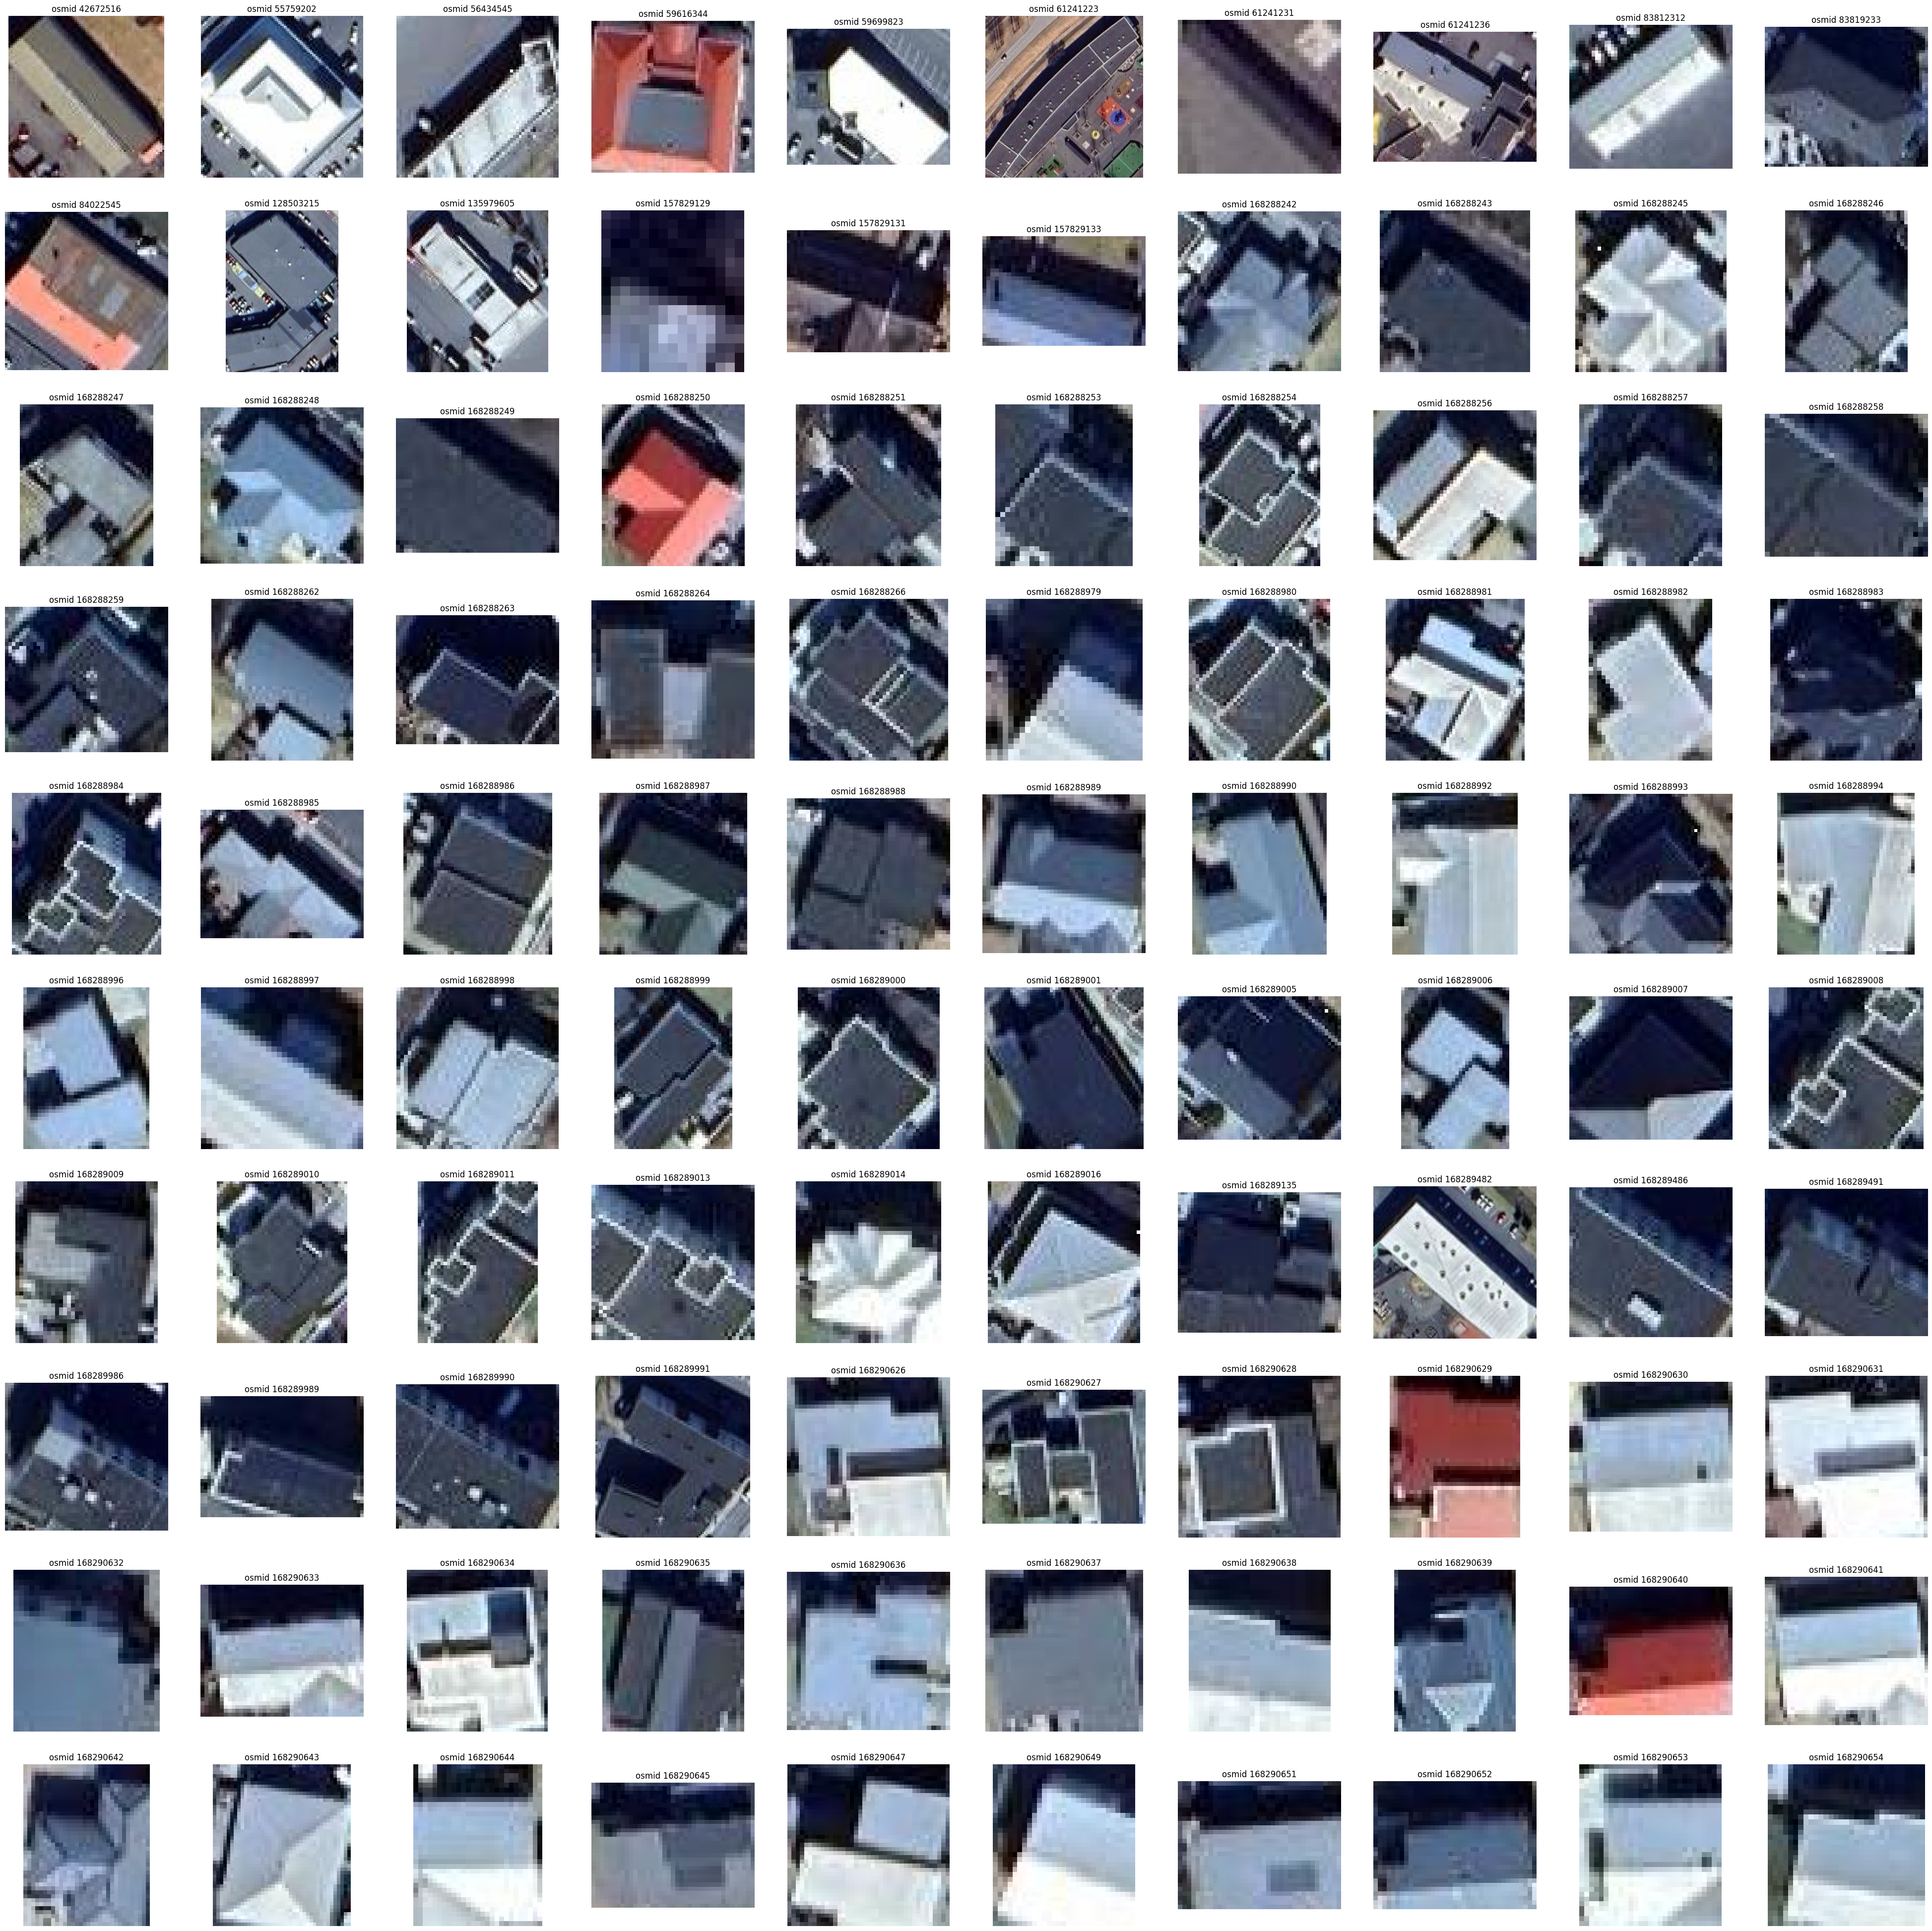

In [20]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os

dir = 'img'
path = os.path.join(dir,'building_'+fid+'.tif')
# Get the list of cropped image files
cropped_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.tif')]

# Limit to the first 100 files
cropped_files = cropped_files[:100]

# Determine subplot grid size
n = len(cropped_files)
cols = 10  # Number of columns in the subplot grid
rows = (n // cols) + (n % cols > 0)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(50, 5 * rows))
axes = axes.flatten()

# Plot each cropped image as RGB
i = 0
for idx, row in polygons_gdf.iterrows():
  fid = str(idx[1])
  file = os.path.join(dir,'building_'+fid+'.tif')
  with rasterio.open(file) as src:
        # Read all three bands (assuming RGB)
        r = src.read(1)
        g = src.read(2)
        b = src.read(3)

        # Stack the bands to create an RGB image
        rgb = np.dstack((r, g, b)).astype(np.float32)

        # Create a transparency mask where all bands are zero
        mask = (rgb == 0).all(axis=-1)

        # Set background (all-zero areas) to black for plotting
        rgb[mask] = [255, 255, 255]

        # Plot the image with an alpha mask for transparency
        axes[i].imshow(rgb / 255, cmap='gray')  # Normalize to [0, 1] for matplotlib
        axes[i].imshow(mask, cmap='gray', alpha=0)  # Apply transparency

  axes[i].set_title(f"osmid {fid}")
  axes[i].axis('off')  # Hide axis for cleaner visualization
  i = i+1

  # Hide any empty subplots
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [21]:
# Save image plot
filename = "building.png"
fig.savefig(filename)

# Download
from google.colab import files
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Zip the files of all images of roundabouts
!zip -r /content/img.zip /content/img

# Download zip file
from google.colab import files
files.download("/content/img.zip")

  adding: content/img/ (stored 0%)
  adding: content/img/building_700658811.tif (deflated 10%)
  adding: content/img/building_220804121.tif (deflated 12%)
  adding: content/img/building_756877600.tif (deflated 11%)
  adding: content/img/building_907747357.tif (deflated 13%)
  adding: content/img/building_222352659.tif (deflated 21%)
  adding: content/img/building_168448152.tif (deflated 6%)
  adding: content/img/building_220800773.tif (deflated 7%)
  adding: content/img/building_890844134.tif (deflated 6%)
  adding: content/img/building_220340805.tif (deflated 4%)
  adding: content/img/building_220939843.tif (deflated 8%)
  adding: content/img/building_221601166.tif (deflated 10%)
  adding: content/img/building_855391304.tif (deflated 7%)
  adding: content/img/building_1329962016.tif (deflated 8%)
  adding: content/img/building_220285625.tif (deflated 8%)
  adding: content/img/building_220285622.tif (deflated 6%)
  adding: content/img/building_865070368.tif (deflated 23%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Make Background image of all roundabouts

['img/building_700658811.tif', 'img/building_220804121.tif', 'img/building_756877600.tif', 'img/building_907747357.tif', 'img/building_222352659.tif', 'img/building_168448152.tif', 'img/building_220800773.tif', 'img/building_890844134.tif', 'img/building_220340805.tif', 'img/building_220939843.tif', 'img/building_221601166.tif', 'img/building_855391304.tif', 'img/building_1329962016.tif', 'img/building_220285625.tif', 'img/building_220285622.tif', 'img/building_865070368.tif', 'img/building_220939847.tif', 'img/building_850453855.tif', 'img/building_376839154.tif', 'img/building_724186236.tif', 'img/building_301241428.tif', 'img/building_865070365.tif', 'img/building_220938529.tif', 'img/building_978415144.tif', 'img/building_220938350.tif', 'img/building_220285484.tif', 'img/building_221837929.tif', 'img/building_220285228.tif', 'img/building_220922267.tif', 'img/building_221603442.tif', 'img/building_700658787.tif', 'img/building_221600397.tif', 'img/building_890768550.tif', 'img/bui

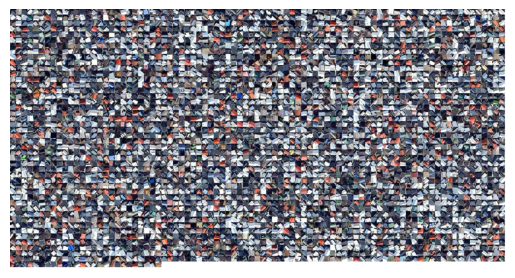

In [23]:
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the directory containing the images
image_dir = 'img'

# List to store image paths
image_paths = []

# Loop through the files in the directory
for file_name in os.listdir(image_dir):
    # Check if the file has a valid image extension
    if file_name.lower().endswith(('.tif')):
        # Construct the full file path
        full_path = os.path.join(image_dir, file_name)
        # Add the path to the list
        image_paths.append(full_path)

# Print the list of image paths
print(image_paths)


# Set A4 size in pixels (assuming 300 DPI)
dpi = 300
a4_width_in = 23 # A4 width in inches
a4_height_in = 12  # A4 height in inches
a4_width_px = int(a4_width_in * dpi)
a4_height_px = int(a4_height_in * dpi)

# Number of images per row and column
n_images = len(image_paths)
aspect_ratio = a4_width_px / a4_height_px
n_cols = int(np.sqrt(n_images * aspect_ratio))
n_rows = int(np.ceil(n_images / n_cols))

# Calculate individual image size
img_width_px = a4_width_px // n_cols
img_height_px = a4_height_px // n_rows

# Create a blank A4 image
background = Image.new("RGB", (a4_width_px, a4_height_px), (255, 255, 255))

# Iterate through the images and paste them
for idx, path in enumerate(image_paths):
    try:
        with rasterio.open(path) as src:
            # Read RGB bands and stack them
            r = src.read(1)
            g = src.read(2)
            b = src.read(3)
            rgb = np.dstack((r, g, b)).astype(np.uint8)

        # Convert the NumPy array to a PIL Image
        img = Image.fromarray(rgb)

        # Resize the image to fit the grid cell
        img_resized = img.resize((img_width_px, img_height_px), resample=Image.Resampling.LANCZOS)

        # Determine position in the grid
        row = idx // n_cols
        col = idx % n_cols
        x = col * img_width_px
        y = row * img_height_px

        # Paste the resized image onto the background
        background.paste(img_resized, (x, y))

    except Exception as e:
        print(f"Error processing {path}: {e}")

plt.imshow(background)
plt.axis('off')

# Save or display the A4 image
background.save("buildings_a4.jpg", "JPEG", dpi=(300, 300))